In this notebook the results of the models' forecasts were compared with baseline predictions

The comparison method is learning from the data, forecasting 60 steps ahead, calculating the MAE based on the true values, and then repeating the process over a +1 day window

As a result, the studied models did not show good results, which indicates the absence of a pattern in the price of gold.

In [45]:
import logging
import os
from datetime import datetime

import matplotlib.pyplot as plt
import mplcyberpunk
import numpy as np
import optuna
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import torch
import yfinance as yf
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import DistributionLoss
from neuralforecast.models import (
    SOFTS,
    DLinear,
    Informer,
    MLPMultivariate,
    NLinear,
    PatchTST,
    StemGNN,
    TiDE,
    TimeLLM,
    TimesNet,
    TSMixer,
    iTransformer,
)
from neuralforecast.tsdataset import TimeSeriesDataset
from nixtla import NixtlaClient
from pandas_datareader import data as pdr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsforecast import StatsForecast
from statsforecast.models import AutoCES, Naive, RandomWalkWithDrift, WindowAverage
from tqdm import tqdm
from utilsforecast.plotting import plot_series

import lightgbm as lgb

# Set the precision for float32 matrix multiplications to 'medium'
torch.set_float32_matmul_precision("medium")
logging.getLogger("pytorch_lightning").setLevel(logging.CRITICAL)
plt.style.use("cyberpunk")
os.environ["NIXTLA_ID_AS_COL"] = "1"
os.environ["PL_DISABLE_FORK"] = "1"

In [2]:
n_steps = 60
RND = 0
LEVEL = 95

In [3]:
def get_metrics(
    y_true: np.ndarray | pd.Series,
    y_pred: np.ndarray | pd.Series,
    y_train: np.ndarray,
    name: str,
) -> pd.DataFrame:
    """
    Generating tables with metrics for time series.

    Parameters
    ----------
    y_true: 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) labels.

    y_pred: 1d array-like, or label indicator array / sparse matrix
        Predicted labels, as returned by a classifier.

    y_train : np.ndarray or list
        Array of training data used to calculate the naive forecast error.

    name: str
        id of metrics

    Returns
    -------
    df: pd.DataFrame
    """
    df_metrics = pd.DataFrame()
    df_metrics["model"] = [name]
    df_metrics["MAE"] = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    df_metrics["MSE"] = mse
    df_metrics["RMSE"] = np.sqrt(mse)
    df_metrics["R²"] = r2_score(y_true, y_pred)
    df_metrics["MAPE"] = mean_absolute_percentage_error(y_true, y_pred)
    df_metrics["sMAPE"] = smape(y_true, y_pred)
    df_metrics["MASE"] = mean_absolute_scaled_error(y_true, y_pred, y_train)
    df_metrics["Mean residuals"] = np.mean(y_true - y_pred)
    return df_metrics


def mean_absolute_percentage_error(y_true, y_pred) -> float:
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def smape(y_true, y_pred):
    return (
        100
        / len(y_true)
        * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    )


def mean_absolute_scaled_error(
    y_true: np.ndarray | list, y_pred: np.ndarray | list, y_train: np.ndarray | list
) -> float:
    """
    Calculate the Mean Absolute Scaled Error (MASE).

    MASE is a metric used to evaluate the accuracy of forecasts by comparing the
    forecast error to the average error of a naive forecasting method (e.g., lag-1 difference).

    Parameters
    ----------
    y_true : np.ndarray or list
        Array of true values for the forecasted period.
    y_pred : np.ndarray or list
        Array of predicted values for the forecasted period.
    y_train : np.ndarray or list
        Array of training data used to calculate the naive forecast error.

    Returns
    -------
    float
        The Mean Absolute Scaled Error (MASE).

    Notes
    -----
    The MASE is defined as:

    .. math:: MASE = \frac{1}{n} \sum_{t=1}^n \frac{|y_t - \hat{y}_t|}{\frac{1}{T-1} \sum_{t=2}^T |y_t - y_{t-1}|}

    where:
    - :math:`y_t` are the true values,
    - :math:`\hat{y}_t` are the predicted values,
    - :math:`T` is the length of the training series.

    A value less than 1 indicates that the forecast is better than the naive forecast.
    A value greater than 1 indicates worse performance than the naive forecast.

    Examples
    --------
    >>> y_true = [100, 200, 300]
    >>> y_pred = [110, 190, 310]
    >>> y_train = [80, 90, 100, 120, 150, 200, 250]
    >>> mean_absolute_scaled_error(y_true, y_pred, y_train)
    0.8253968253968254
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_train = np.array(y_train)

    # Calculate the naive forecast error (denominator)
    naive_diff = np.abs(y_train[1:] - y_train[:-1])
    naive_error = np.mean(naive_diff)

    # Check for division by zero
    if naive_error == 0:
        raise ValueError("Naive forecast error is zero. MASE is undefined.")

    # Calculate the scaled error (numerator)
    scaled_errors = np.abs(y_true - y_pred) / naive_error

    # Return the mean absolute scaled error
    return np.mean(scaled_errors)

# Import data 

In [4]:
df = yf.download("GC=F", start="2000-01-01", end=datetime.today().strftime("%Y-%m-%d"))
df.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis=1, inplace=True)
df.rename(columns={"Close": "Price"}, inplace=True)
df_hist = pd.read_csv("Historical data.csv")
df_hist["Date"] = pd.to_datetime(df_hist["Date"])
df_hist.set_index("Date", inplace=True)
df = pd.concat((df_hist, df))
df.rename({"Price": "y"}, axis=1, inplace=True)

[*********************100%***********************]  1 of 1 completed


In [5]:
cpi_data = pdr.get_data_fred(
    "CPIAUCSL", start="1979-12-27", end=datetime.today().strftime("%Y-%m-%d")
)

In [6]:
latest_row = pd.DataFrame(
    {
        "DATE": [datetime.today()],
        "CPIAUCSL": [cpi_data.iloc[-1][0]],
    }
).set_index("DATE")

In [7]:
cpi_data = pd.concat([cpi_data, latest_row])

In [8]:
df["CPI"] = cpi_data.asfreq("B").interpolate(method="linear")

In [9]:
df["CPI"] = df["CPI"].interpolate(method="linear").bfill()

In [10]:
df["TNX"] = yf.download("^TNX", start="1979-12-27")["Close"]
df["TNX"] = df["TNX"].interpolate(method="linear")
df["TNX"].info()

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
DatetimeIndex: 11466 entries, 1979-12-27 to 2025-02-05
Series name: TNX
Non-Null Count  Dtype  
--------------  -----  
11466 non-null  float64
dtypes: float64(1)
memory usage: 179.2 KB


In [11]:
df["DJI"] = yf.download("^DJI", start="1979-12-27")["Close"]
df["DJI"] = df["DJI"].interpolate(method="linear").bfill()
df["DJI"].info()

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
DatetimeIndex: 11466 entries, 1979-12-27 to 2025-02-05
Series name: DJI
Non-Null Count  Dtype  
--------------  -----  
11466 non-null  float64
dtypes: float64(1)
memory usage: 179.2 KB


In [12]:
df["DX-Y.NYB"] = yf.download("DX-Y.NYB", start="1979-12-27")["Close"]
df["DX-Y.NYB"] = df["DX-Y.NYB"].interpolate(method="linear")

[*********************100%***********************]  1 of 1 completed


In [13]:
df["WTI"] = yf.download("CL=F", start="1979-12-27")["Close"]
df["WTI"] = df["WTI"].interpolate(method="linear").bfill()

[*********************100%***********************]  1 of 1 completed


In [14]:
df["IRX"] = yf.download("^IRX", start="1979-12-27")["Close"]
df["IRX"] = df["IRX"].interpolate(method="linear")

[*********************100%***********************]  1 of 1 completed


In [15]:
df["GDX"] = yf.download("GDX", start="1979-12-27")["Close"]
df["GDX"] = df["GDX"].interpolate(method="linear").bfill()

[*********************100%***********************]  1 of 1 completed


In [16]:
df["EURUSD"] = yf.download("EURUSD=X", start="1979-12-27")["Close"]
df["EURUSD"] = df["EURUSD"].interpolate(method="linear").bfill()

[*********************100%***********************]  1 of 1 completed


In [17]:
df["VIX"] = yf.download("^VIX", start="1979-12-27")["Close"]
df["VIX"] = df["VIX"].interpolate(method="linear").bfill()

[*********************100%***********************]  1 of 1 completed


In [18]:
df["SI"] = yf.download("SI=F", start="1979-12-27")["Close"]
df["SI"] = df["SI"].interpolate(method="linear").bfill()
df["SI"].info()

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.series.Series'>
DatetimeIndex: 11466 entries, 1979-12-27 to 2025-02-05
Series name: SI
Non-Null Count  Dtype  
--------------  -----  
11466 non-null  float64
dtypes: float64(1)
memory usage: 179.2 KB


In [19]:
df["GSPC"] = yf.download("^GSPC", start="1979-12-27")["Close"]
df["GSPC"] = df["GSPC"].interpolate(method="linear").bfill()

[*********************100%***********************]  1 of 1 completed


In [20]:
df = df.asfreq("B").interpolate(method="linear")

In [21]:
df

y         CPI      TNX           DJI    DX-Y.NYB  \
Date                                                                     
1979-12-27   515.500000   78.000000  10.4600   3172.399902   85.510002   
1979-12-28   512.000000   78.000000  10.4100   3172.399902   85.809998   
1979-12-31   512.000000   78.000000  10.4325   3172.399902   85.687498   
1980-01-01   512.000000   78.000000  10.4550   3172.399902   85.564999   
1980-01-02   559.750000   78.043478  10.5000   3172.399902   85.320000   
...                 ...         ...      ...           ...         ...   
2025-01-30  2823.000000  316.441000   4.5120  44882.128906  107.800003   
2025-01-31  2812.500000  316.441000   4.5690  44544.660156  108.370003   
2025-02-03  2833.899902  316.441000   4.5430  44421.910156  108.989998   
2025-02-04  2853.300049  316.441000   4.5130  44556.039062  107.959999   
2025-02-05  2871.600098  316.441000   4.4220  44873.281250  107.580002   

                  WTI      IRX        GDX    EURUSD        VIX         SI  \
Date                                                                        
1979-12-27  32.049999  11.9700  37.230000  1.196501  17.240000   4.930000   
1979-12-28  32.049999  11.9200  37.230000  1.196501  17.240000   4.930000   
1979-12-31  32.049999  11.9825  37.230000  1.196501  17.240000   4.930000   
1980-01-01  32.049999  12.0450  37.230000  1.196501  17.240000   4.930000   
1980-01-02  32.049999  12.1700  37.230000  1.196501  17.240000   4.930000   
...               ...      ...        ...       ...        ...        ...   
2025-01-30  72.730003   4.1820  39.419998  1.042525  15.840000  32.363998   
2025-01-31  72.529999   4.1880  38.959999  1.039728  16.430000  32.127998   
2025-02-03  73.160004   4.1900  39.560001  1.024779  18.620001  32.391998   
2025-02-04  72.699997   4.2130  40.029999  1.032738  17.209999  32.888000   
2025-02-05  71.029999   4.2100  41.040001  1.037280  15.770000  32.856998   

                   GSPC  
Date                     
1979-12-27   107.959999  
1979-12-28   107.839996  
1979-12-31   107.319998  
1980-01-01   106.799999  
1980-01-02   105.760002  
...                 ...  
2025-01-30  6071.169922  
2025-01-31  6040.529785  
2025-02-03  5994.569824  
2025-02-04  6037.879883  
2025-02-05  6061.479980  

[11770 rows x 12 columns]

In [22]:
exog_cols = [
    "DX-Y.NYB",
    "WTI",
    "IRX",
    "GDX",
    "EURUSD",
    "VIX",
    "GSPC",
    "CPI",
    "TNX",
    "DJI",
    "SI",
]

In [23]:
df["ds"] = df.index
df["unique_id"] = "gold"
df_train = df.iloc[:-n_steps]
df_test = df.iloc[-n_steps:]
Y_ts = df[["ds", "unique_id", "y"]].copy()
X_ts = df.drop(["y"], axis=1)
Y_train = Y_ts.iloc[:-n_steps]
Y_test = Y_ts.iloc[-n_steps:]

X_train = X_ts.iloc[:-n_steps]
X_test = X_ts.iloc[-n_steps:]

In [24]:
df_train

y         CPI      TNX           DJI    DX-Y.NYB  \
Date                                                                     
1979-12-27   515.500000   78.000000  10.4600   3172.399902   85.510002   
1979-12-28   512.000000   78.000000  10.4100   3172.399902   85.809998   
1979-12-31   512.000000   78.000000  10.4325   3172.399902   85.687498   
1980-01-01   512.000000   78.000000  10.4550   3172.399902   85.564999   
1980-01-02   559.750000   78.043478  10.5000   3172.399902   85.320000   
...                 ...         ...      ...           ...         ...   
2024-11-07  2698.399902  316.441000   4.3410  43729.339844  104.510002   
2024-11-08  2687.500000  316.441000   4.3060  43988.988281  105.000000   
2024-11-11  2611.199951  316.441000   4.3080  44293.128906  105.540001   
2024-11-12  2600.000000  316.441000   4.4320  43910.980469  106.019997   
2024-11-13  2580.800049  316.441000   4.4510  43958.191406  106.480003   

                  WTI      IRX        GDX    EURUSD    VIX         SI  \
Date                                                                    
1979-12-27  32.049999  11.9700  37.230000  1.196501  17.24   4.930000   
1979-12-28  32.049999  11.9200  37.230000  1.196501  17.24   4.930000   
1979-12-31  32.049999  11.9825  37.230000  1.196501  17.24   4.930000   
1980-01-01  32.049999  12.0450  37.230000  1.196501  17.24   4.930000   
1980-01-02  32.049999  12.1700  37.230000  1.196501  17.24   4.930000   
...               ...      ...        ...       ...    ...        ...   
2024-11-07  72.360001   4.4200  39.570000  1.073307  15.20  31.764999   
2024-11-08  70.379997   4.4230  39.020000  1.079517  14.94  31.358999   
2024-11-11  68.040001   4.4150  36.730000  1.071490  14.97  30.540001   
2024-11-12  68.120003   4.4230  36.110001  1.066439  14.71  30.686001   
2024-11-13  68.430000   4.3900  35.560001  1.061673  14.02  30.590000   

                   GSPC         ds unique_id  
Date                                          
1979-12-27   107.959999 1979-12-27      gold  
1979-12-28   107.839996 1979-12-28      gold  
1979-12-31   107.319998 1979-12-31      gold  
1980-01-01   106.799999 1980-01-01      gold  
1980-01-02   105.760002 1980-01-02      gold  
...                 ...        ...       ...  
2024-11-07  5973.100098 2024-11-07      gold  
2024-11-08  5995.540039 2024-11-08      gold  
2024-11-11  6001.350098 2024-11-11      gold  
2024-11-12  5983.990234 2024-11-12      gold  
2024-11-13  5985.379883 2024-11-13      gold  

[11710 rows x 14 columns]

In [25]:
dataset, *_ = TimeSeriesDataset.from_df(df_train)

# Baseline

In [26]:
models = [
    Naive(),
    RandomWalkWithDrift(),
    WindowAverage(window_size=n_steps),
]
columns = [model.__class__.__name__ for model in models]

In [27]:
index = []
errors = []
for h in tqdm(range(-n_steps * 2, -n_steps + 1)):
    Y_ts = df[["ds", "unique_id", "y"]].copy()
    df_train = df.iloc[:h]
    Y_train = Y_ts.iloc[:h]
    if h + n_steps == 0:
        df_test = df.iloc[h:]
        Y_test = Y_ts.iloc[h:]
    else:
        df_test = df.iloc[h : h + n_steps]
        Y_test = Y_ts.iloc[h : h + n_steps]

    for model in models:
        model.fit(y=Y_train.y.values)
    forecasts = {
        model.__class__.__name__: model.predict(h=n_steps)["mean"] for model in models
    }
    predicted_df = pd.DataFrame(
        {
            "ds": Y_test.ds,
            "unique_id": Y_test.unique_id,
        }
    )
    predicted_df = predicted_df.assign(**forecasts)
    err_row = []
    index.append(Y_train.ds[-1])
    for model in models:
        mae = mean_absolute_error(
            Y_test["y"].values, predicted_df[model.__class__.__name__]
        )
        err_row.append(mae)
    errors.append(err_row)
metrics_df = pd.DataFrame(errors, index=index, columns=columns)
metrics_df

100%|█████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 648.47it/s]


Naive  RandomWalkWithDrift  WindowAverage
2024-08-21  118.969240           114.133406     240.451666
2024-08-22  145.855927           140.715695     239.673334
2024-08-23  120.429242           115.497309     237.536668
2024-08-26  115.480865           110.669537     236.233339
2024-08-27  118.409170           113.539392     234.910008
...                ...                  ...            ...
2024-11-07   58.168294            59.287252      56.704084
2024-11-08   55.138346            55.837236      56.700863
2024-11-11   65.623368            60.774142      58.973832
2024-11-12   78.988338            73.753943      61.573139
2024-11-13  100.854960            95.492835      64.240001

[61 rows x 3 columns]

In [28]:
metrics_df["Baseline"] = metrics_df.min(axis=1)

In [29]:
metrics_df.drop(columns, axis=1, inplace=True)

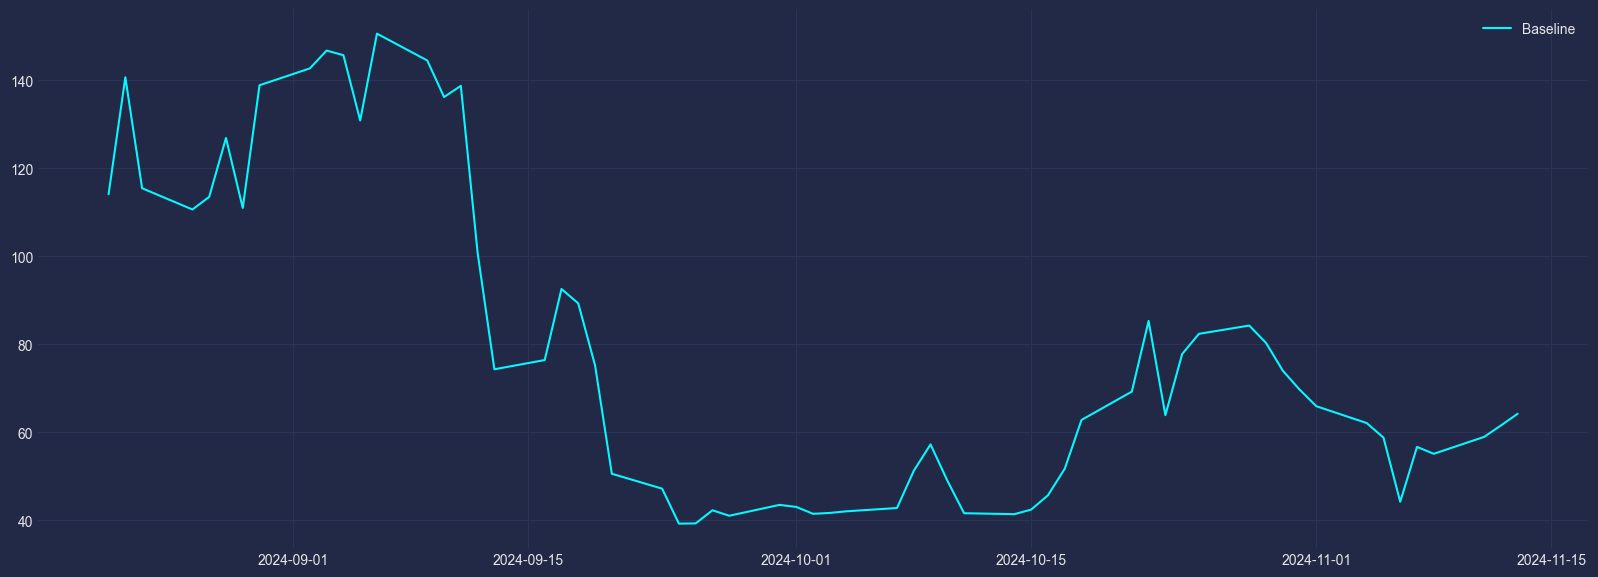

In [30]:
plt.figure(figsize=(20, 7))
sns.lineplot(metrics_df)
plt.show()

# DLinear

In [48]:
def objective_dlinear(trial, dataset):
    params = {
        "input_size": trial.suggest_categorical(
            "input_size",
            [n_steps, n_steps * 2, n_steps * 3, n_steps * 4, n_steps * 5],
        ),
        "moving_avg_window": trial.suggest_categorical(
            "moving_avg_window",
            [11, 25, 51],
        ),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "scaler_type": trial.suggest_categorical(
            "scaler_type", ["minmax1", None, "robust", "standard", "identity"]
        ),
        "max_steps": trial.suggest_int("max_steps", 500, 1500, step=500),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128, 256]),
        "windows_batch_size": trial.suggest_categorical(
            "windows_batch_size", [128, 256, 512, 1024]
        ),
    }
    model = DLinear(h=n_steps, random_seed=RND, **params)
    model.fit(dataset, val_size=n_steps, test_size=n_steps, random_seed=RND)
    return model.metrics["ptl/val_loss"]

In [49]:
index = []
errors = []
for i, h in enumerate(tqdm(range(-n_steps * 2, -n_steps + 1))):
    Y_ts = df[["ds", "unique_id", "y"]].copy()
    df_train = df.iloc[:h]
    Y_train = Y_ts.iloc[:h]
    if h + n_steps == 0:
        df_test = df.iloc[h:]
        Y_test = Y_ts.iloc[h:]
    else:
        df_test = df.iloc[h : h + n_steps]
        Y_test = Y_ts.iloc[h : h + n_steps]
    study_path = "study_dlinear_e1.db"
    study = optuna.create_study(
        storage="sqlite:///{}".format(study_path),
        study_name=study_path,
        direction="minimize",
        load_if_exists=True,
    )
    dataset, *_ = TimeSeriesDataset.from_df(df_train)
    func = lambda x: objective_dlinear(x, dataset)
    study.optimize(
        func,
        n_trials=10 if i == 0 else 1,
        show_progress_bar=True,
        n_jobs=1,
        gc_after_trial=True,
    )
    dataset, *_ = TimeSeriesDataset.from_df(df_train)
    model = DLinear(h=n_steps, random_seed=RND, **study.best_params)
    model.fit(dataset=dataset, random_seed=RND)
    y_hat = model.predict(dataset=dataset, random_seed=RND)
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = np.mean(y_hat, axis=1)
    y_hat = y_hat.flatten()
    predicted_df = pd.DataFrame(
        {
            model.__class__.__name__: y_hat,
            "ds": Y_test.ds,
            "unique_id": Y_test.unique_id,
        }
    )
    index.append(Y_train.ds[-1])
    mae = mean_absolute_error(
        Y_test["y"].values, predicted_df[model.__class__.__name__]
    )
    errors.append(mae)

  0%|                                                                                           | 0/61 [00:00<?, ?it/s][I 2025-02-05 17:23:28,288] A new study created in RDB with name: study_dlinear_e1.db


  0%|          | 0/10 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
  0%|                                                                                           | 0/61 [00:05<?, ?it/s]

[I 2025-02-05 17:23:33,859] Trial 0 finished with value: 194.71316528320312 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.0012157040513251943, 'scaler_type': 'identity', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 512}. Best is trial 0 with value: 194.71316528320312.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
  0%|                                                                                           | 0/61 [00:16<?, ?it/s]

[I 2025-02-05 17:23:44,828] Trial 1 finished with value: 170.84242248535156 and parameters: {'input_size': 60, 'moving_avg_window': 11, 'learning_rate': 0.004877480335853194, 'scaler_type': None, 'max_steps': 1000, 'batch_size': 32, 'windows_batch_size': 512}. Best is trial 1 with value: 170.84242248535156.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
  0%|                                                                                           | 0/61 [00:35<?, ?it/s]

[I 2025-02-05 17:24:03,412] Trial 2 finished with value: 114.94920349121094 and parameters: {'input_size': 180, 'moving_avg_window': 11, 'learning_rate': 0.031598453279762774, 'scaler_type': 'robust', 'max_steps': 1500, 'batch_size': 64, 'windows_batch_size': 128}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
  0%|                                                                                           | 0/61 [00:41<?, ?it/s]

[I 2025-02-05 17:24:09,436] Trial 3 finished with value: 209.6012725830078 and parameters: {'input_size': 180, 'moving_avg_window': 11, 'learning_rate': 0.007769959284490875, 'scaler_type': None, 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 512}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
  0%|                                                                                           | 0/61 [00:47<?, ?it/s]

[I 2025-02-05 17:24:15,376] Trial 4 finished with value: 139.52969360351562 and parameters: {'input_size': 120, 'moving_avg_window': 51, 'learning_rate': 0.010678045639852227, 'scaler_type': 'minmax1', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 1024}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
  0%|                                                                                           | 0/61 [00:53<?, ?it/s]

[I 2025-02-05 17:24:21,198] Trial 5 finished with value: 146.0203094482422 and parameters: {'input_size': 60, 'moving_avg_window': 11, 'learning_rate': 0.040326856436869556, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64, 'windows_batch_size': 128}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
  0%|                                                                                           | 0/61 [01:04<?, ?it/s]

[I 2025-02-05 17:24:32,857] Trial 6 finished with value: 164.20538330078125 and parameters: {'input_size': 240, 'moving_avg_window': 51, 'learning_rate': 0.00480515909308029, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 1024}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
  0%|                                                                                           | 0/61 [01:21<?, ?it/s]

[I 2025-02-05 17:24:49,612] Trial 7 finished with value: 1256.0872802734375 and parameters: {'input_size': 300, 'moving_avg_window': 51, 'learning_rate': 0.026415303684689875, 'scaler_type': 'identity', 'max_steps': 1500, 'batch_size': 256, 'windows_batch_size': 256}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
  0%|                                                                                           | 0/61 [01:37<?, ?it/s]

[I 2025-02-05 17:25:06,037] Trial 8 finished with value: 150.72987365722656 and parameters: {'input_size': 120, 'moving_avg_window': 51, 'learning_rate': 0.00031998302928205646, 'scaler_type': 'minmax1', 'max_steps': 1500, 'batch_size': 64, 'windows_batch_size': 256}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
  0%|                                                                                           | 0/61 [01:49<?, ?it/s]

[I 2025-02-05 17:25:17,250] Trial 9 finished with value: 256.3677978515625 and parameters: {'input_size': 240, 'moving_avg_window': 51, 'learning_rate': 0.006734291565936084, 'scaler_type': 'identity', 'max_steps': 1000, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

  2%|█▎                                                                              | 1/61 [02:06<2:06:47, 126.80s/it][I 2025-02-05 17:25:35,011] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
  2%|█▎                                                                              | 1/61 [02:24<2:06:47, 126.80s/it]

[I 2025-02-05 17:25:52,387] Trial 10 finished with value: 157.8567352294922 and parameters: {'input_size': 180, 'moving_avg_window': 25, 'learning_rate': 0.057951175980182866, 'scaler_type': 'robust', 'max_steps': 1500, 'batch_size': 64, 'windows_batch_size': 128}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

  3%|██▋                                                                              | 2/61 [02:41<1:11:37, 72.84s/it][I 2025-02-05 17:26:10,084] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
  3%|██▋                                                                              | 2/61 [02:52<1:11:37, 72.84s/it]

[I 2025-02-05 17:26:20,854] Trial 11 finished with value: 124.55231475830078 and parameters: {'input_size': 120, 'moving_avg_window': 11, 'learning_rate': 0.016571316004359373, 'scaler_type': 'minmax1', 'max_steps': 1000, 'batch_size': 256, 'windows_batch_size': 1024}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

  5%|████                                                                               | 3/61 [03:10<50:51, 52.62s/it][I 2025-02-05 17:26:38,626] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
  5%|████                                                                               | 3/61 [03:27<50:51, 52.62s/it]

[I 2025-02-05 17:26:56,068] Trial 12 finished with value: 143.59716796875 and parameters: {'input_size': 180, 'moving_avg_window': 11, 'learning_rate': 0.021129184649382498, 'scaler_type': 'robust', 'max_steps': 1500, 'batch_size': 256, 'windows_batch_size': 128}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

  7%|█████▍                                                                             | 4/61 [03:45<43:27, 45.75s/it][I 2025-02-05 17:27:13,862] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
  7%|█████▍                                                                             | 4/61 [03:57<43:27, 45.75s/it]

[I 2025-02-05 17:27:25,916] Trial 13 finished with value: 135.56536865234375 and parameters: {'input_size': 300, 'moving_avg_window': 11, 'learning_rate': 0.0008962114715929321, 'scaler_type': 'robust', 'max_steps': 1000, 'batch_size': 256, 'windows_batch_size': 1024}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

  8%|██████▊                                                                            | 5/61 [04:15<37:19, 39.99s/it][I 2025-02-05 17:27:43,636] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
  8%|██████▊                                                                            | 5/61 [04:26<37:19, 39.99s/it]

[I 2025-02-05 17:27:54,797] Trial 14 finished with value: 162.13275146484375 and parameters: {'input_size': 180, 'moving_avg_window': 11, 'learning_rate': 0.08281072920088656, 'scaler_type': 'minmax1', 'max_steps': 1000, 'batch_size': 256, 'windows_batch_size': 128}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 10%|████████▏                                                                          | 6/61 [04:44<33:13, 36.24s/it][I 2025-02-05 17:28:12,604] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
 10%|████████▏                                                                          | 6/61 [05:01<33:13, 36.24s/it]

[I 2025-02-05 17:28:29,573] Trial 15 finished with value: 162.3887176513672 and parameters: {'input_size': 120, 'moving_avg_window': 11, 'learning_rate': 0.00010516756097929342, 'scaler_type': 'robust', 'max_steps': 1500, 'batch_size': 64, 'windows_batch_size': 1024}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 11%|█████████▌                                                                         | 7/61 [05:19<32:14, 35.82s/it][I 2025-02-05 17:28:47,545] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 11%|█████████▌                                                                         | 7/61 [05:30<32:14, 35.82s/it]

[I 2025-02-05 17:28:58,680] Trial 16 finished with value: 152.08407592773438 and parameters: {'input_size': 180, 'moving_avg_window': 11, 'learning_rate': 0.016601493035935822, 'scaler_type': 'minmax1', 'max_steps': 1000, 'batch_size': 256, 'windows_batch_size': 1024}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 13%|██████████▉                                                                        | 8/61 [05:48<29:41, 33.61s/it][I 2025-02-05 17:29:16,426] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
 13%|██████████▉                                                                        | 8/61 [06:05<29:41, 33.61s/it]

[I 2025-02-05 17:29:33,506] Trial 17 finished with value: 142.6923065185547 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.002095571739810587, 'scaler_type': 'robust', 'max_steps': 1500, 'batch_size': 64, 'windows_batch_size': 128}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 15%|████████████▏                                                                      | 9/61 [06:24<29:59, 34.60s/it][I 2025-02-05 17:29:53,199] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 15%|████████████▏                                                                      | 9/61 [06:36<29:59, 34.60s/it]

[I 2025-02-05 17:30:04,733] Trial 18 finished with value: 150.95668029785156 and parameters: {'input_size': 300, 'moving_avg_window': 11, 'learning_rate': 0.03257393688563336, 'scaler_type': 'minmax1', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 1024}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 16%|█████████████▍                                                                    | 10/61 [06:54<28:01, 32.98s/it][I 2025-02-05 17:30:22,554] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
 16%|█████████████▍                                                                    | 10/61 [07:10<28:01, 32.98s/it]

[I 2025-02-05 17:30:38,816] Trial 19 finished with value: 584.4736328125 and parameters: {'input_size': 240, 'moving_avg_window': 11, 'learning_rate': 0.013701957065028098, 'scaler_type': None, 'max_steps': 1500, 'batch_size': 256, 'windows_batch_size': 128}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 18%|██████████████▊                                                                   | 11/61 [07:28<27:46, 33.33s/it][I 2025-02-05 17:30:56,669] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 18%|██████████████▊                                                                   | 11/61 [07:39<27:46, 33.33s/it]

[I 2025-02-05 17:31:07,572] Trial 20 finished with value: 168.51254272460938 and parameters: {'input_size': 60, 'moving_avg_window': 25, 'learning_rate': 0.0029451163083415964, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 64, 'windows_batch_size': 1024}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 20%|████████████████▏                                                                 | 12/61 [07:57<26:05, 31.95s/it][I 2025-02-05 17:31:25,486] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 20%|████████████████▏                                                                 | 12/61 [08:09<26:05, 31.95s/it]

[I 2025-02-05 17:31:37,543] Trial 21 finished with value: 165.86143493652344 and parameters: {'input_size': 300, 'moving_avg_window': 11, 'learning_rate': 0.0007413593173436941, 'scaler_type': 'robust', 'max_steps': 1000, 'batch_size': 256, 'windows_batch_size': 1024}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 21%|█████████████████▍                                                                | 13/61 [08:27<25:05, 31.36s/it][I 2025-02-05 17:31:55,469] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 21%|█████████████████▍                                                                | 13/61 [08:39<25:05, 31.36s/it]

[I 2025-02-05 17:32:07,773] Trial 22 finished with value: 173.57620239257812 and parameters: {'input_size': 300, 'moving_avg_window': 11, 'learning_rate': 0.0004811368680917177, 'scaler_type': 'robust', 'max_steps': 1000, 'batch_size': 256, 'windows_batch_size': 1024}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 23%|██████████████████▊                                                               | 14/61 [08:57<24:21, 31.09s/it][I 2025-02-05 17:32:25,928] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 23%|██████████████████▊                                                               | 14/61 [09:10<24:21, 31.09s/it]

[I 2025-02-05 17:32:38,217] Trial 23 finished with value: 172.7766571044922 and parameters: {'input_size': 300, 'moving_avg_window': 11, 'learning_rate': 0.00018763812122963251, 'scaler_type': 'robust', 'max_steps': 1000, 'batch_size': 256, 'windows_batch_size': 1024}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 25%|████████████████████▏                                                             | 15/61 [09:28<23:38, 30.85s/it][I 2025-02-05 17:32:56,221] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 25%|████████████████████▏                                                             | 15/61 [09:40<23:38, 30.85s/it]

[I 2025-02-05 17:33:08,520] Trial 24 finished with value: 174.49928283691406 and parameters: {'input_size': 300, 'moving_avg_window': 11, 'learning_rate': 0.0017007807242655564, 'scaler_type': 'robust', 'max_steps': 1000, 'batch_size': 256, 'windows_batch_size': 1024}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 26%|█████████████████████▌                                                            | 16/61 [09:58<23:01, 30.69s/it][I 2025-02-05 17:33:26,557] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 26%|█████████████████████▌                                                            | 16/61 [10:04<23:01, 30.69s/it]

[I 2025-02-05 17:33:32,255] Trial 25 finished with value: 189.1911163330078 and parameters: {'input_size': 120, 'moving_avg_window': 11, 'learning_rate': 0.08584804427934885, 'scaler_type': 'minmax1', 'max_steps': 500, 'batch_size': 256, 'windows_batch_size': 128}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 28%|██████████████████████▊                                                           | 17/61 [10:22<20:57, 28.59s/it][I 2025-02-05 17:33:50,241] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
 28%|██████████████████████▊                                                           | 17/61 [10:39<20:57, 28.59s/it]

[I 2025-02-05 17:34:07,811] Trial 26 finished with value: 137.7106475830078 and parameters: {'input_size': 180, 'moving_avg_window': 11, 'learning_rate': 0.001018054200934495, 'scaler_type': 'robust', 'max_steps': 1500, 'batch_size': 64, 'windows_batch_size': 512}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 30%|████████████████████████▏                                                         | 18/61 [10:57<22:01, 30.73s/it][I 2025-02-05 17:34:25,965] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 30%|████████████████████████▏                                                         | 18/61 [11:09<22:01, 30.73s/it]

[I 2025-02-05 17:34:37,671] Trial 27 finished with value: 115.25315856933594 and parameters: {'input_size': 120, 'moving_avg_window': 11, 'learning_rate': 0.045413867441343105, 'scaler_type': 'robust', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 31%|█████████████████████████▌                                                        | 19/61 [11:27<21:19, 30.47s/it][I 2025-02-05 17:34:55,824] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
 31%|█████████████████████████▌                                                        | 19/61 [11:44<21:19, 30.47s/it]

[I 2025-02-05 17:35:12,279] Trial 28 finished with value: 144.8778533935547 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.048767083101302705, 'scaler_type': 'minmax1', 'max_steps': 1500, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 33%|██████████████████████████▉                                                       | 20/61 [12:02<21:38, 31.68s/it][I 2025-02-05 17:35:30,335] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 33%|██████████████████████████▉                                                       | 20/61 [12:07<21:38, 31.68s/it]

[I 2025-02-05 17:35:35,862] Trial 29 finished with value: 506.1041259765625 and parameters: {'input_size': 120, 'moving_avg_window': 11, 'learning_rate': 0.022870533976608022, 'scaler_type': 'identity', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 2 with value: 114.94920349121094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 34%|████████████████████████████▏                                                     | 21/61 [12:25<19:32, 29.30s/it][I 2025-02-05 17:35:54,086] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 34%|████████████████████████████▏                                                     | 21/61 [12:37<19:32, 29.30s/it]

[I 2025-02-05 17:36:05,364] Trial 30 finished with value: 60.557273864746094 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.011411320724790657, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 30 with value: 60.557273864746094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 36%|█████████████████████████████▌                                                    | 22/61 [12:48<17:49, 27.42s/it][I 2025-02-05 17:36:17,132] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 36%|█████████████████████████████▌                                                    | 22/61 [13:00<17:49, 27.42s/it]

[I 2025-02-05 17:36:28,443] Trial 31 finished with value: 63.05751037597656 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.01096103067264878, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 30 with value: 60.557273864746094.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 38%|██████████████████████████████▉                                                   | 23/61 [13:12<16:34, 26.17s/it][I 2025-02-05 17:36:40,366] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 38%|██████████████████████████████▉                                                   | 23/61 [13:23<16:34, 26.17s/it]

[I 2025-02-05 17:36:52,021] Trial 32 finished with value: 30.437467575073242 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.0107226854369338, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 32 with value: 30.437467575073242.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 39%|████████████████████████████████▎                                                 | 24/61 [13:35<15:37, 25.34s/it][I 2025-02-05 17:37:03,772] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 39%|████████████████████████████████▎                                                 | 24/61 [13:46<15:37, 25.34s/it]

[I 2025-02-05 17:37:15,053] Trial 33 finished with value: 31.950450897216797 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.008089304672597759, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 32 with value: 30.437467575073242.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 41%|█████████████████████████████████▌                                                | 25/61 [13:58<14:46, 24.62s/it][I 2025-02-05 17:37:26,721] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 41%|█████████████████████████████████▌                                                | 25/61 [14:09<14:46, 24.62s/it]

[I 2025-02-05 17:37:38,044] Trial 34 finished with value: 26.447132110595703 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.0044383423620893364, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 43%|██████████████████████████████████▉                                               | 26/61 [14:21<14:04, 24.14s/it][I 2025-02-05 17:37:49,741] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 43%|██████████████████████████████████▉                                               | 26/61 [14:32<14:04, 24.14s/it]

[I 2025-02-05 17:38:00,926] Trial 35 finished with value: 29.616411209106445 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.004512541357203487, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 44%|████████████████████████████████████▎                                             | 27/61 [14:44<13:27, 23.76s/it][I 2025-02-05 17:38:12,620] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 44%|████████████████████████████████████▎                                             | 27/61 [14:50<13:27, 23.76s/it]

[I 2025-02-05 17:38:18,404] Trial 36 finished with value: 29.143383026123047 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.003816404509491812, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 46%|█████████████████████████████████████▋                                            | 28/61 [15:01<12:01, 21.86s/it][I 2025-02-05 17:38:30,032] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 46%|█████████████████████████████████████▋                                            | 28/61 [15:07<12:01, 21.86s/it]

[I 2025-02-05 17:38:35,778] Trial 37 finished with value: 28.23615264892578 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.003888829586861249, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 48%|██████████████████████████████████████▉                                           | 29/61 [15:19<10:57, 20.53s/it][I 2025-02-05 17:38:47,483] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 48%|██████████████████████████████████████▉                                           | 29/61 [15:25<10:57, 20.53s/it]

[I 2025-02-05 17:38:53,361] Trial 38 finished with value: 40.69660949707031 and parameters: {'input_size': 60, 'moving_avg_window': 25, 'learning_rate': 0.004393676600957232, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 49%|████████████████████████████████████████▎                                         | 30/61 [15:37<10:12, 19.77s/it][I 2025-02-05 17:39:05,457] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 49%|████████████████████████████████████████▎                                         | 30/61 [15:43<10:12, 19.77s/it]

[I 2025-02-05 17:39:11,411] Trial 39 finished with value: 62.88639831542969 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.0033508054891151513, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 512}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 51%|█████████████████████████████████████████▋                                        | 31/61 [15:55<09:38, 19.29s/it][I 2025-02-05 17:39:23,640] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 51%|█████████████████████████████████████████▋                                        | 31/61 [16:01<09:38, 19.29s/it]

[I 2025-02-05 17:39:29,624] Trial 40 finished with value: 47.37881088256836 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.0015310746027540792, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 52%|███████████████████████████████████████████                                       | 32/61 [16:13<09:10, 18.98s/it][I 2025-02-05 17:39:41,882] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 52%|███████████████████████████████████████████                                       | 32/61 [16:19<09:10, 18.98s/it]

[I 2025-02-05 17:39:47,681] Trial 41 finished with value: 42.31571960449219 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.00593299268331174, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 54%|████████████████████████████████████████████▎                                     | 33/61 [16:31<08:39, 18.56s/it][I 2025-02-05 17:39:59,457] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 54%|████████████████████████████████████████████▎                                     | 33/61 [16:37<08:39, 18.56s/it]

[I 2025-02-05 17:40:05,279] Trial 42 finished with value: 57.71094512939453 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.002790204759476455, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 56%|█████████████████████████████████████████████▋                                    | 34/61 [16:48<08:13, 18.28s/it][I 2025-02-05 17:40:17,078] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 56%|█████████████████████████████████████████████▋                                    | 34/61 [16:54<08:13, 18.28s/it]

[I 2025-02-05 17:40:22,971] Trial 43 finished with value: 26.608821868896484 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.004633083987912963, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 57%|███████████████████████████████████████████████                                   | 35/61 [17:06<07:50, 18.10s/it][I 2025-02-05 17:40:34,753] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 57%|███████████████████████████████████████████████                                   | 35/61 [17:12<07:50, 18.10s/it]

[I 2025-02-05 17:40:40,801] Trial 44 finished with value: 30.609683990478516 and parameters: {'input_size': 240, 'moving_avg_window': 25, 'learning_rate': 0.004035491192532614, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 59%|████████████████████████████████████████████████▍                                 | 36/61 [17:24<07:30, 18.02s/it][I 2025-02-05 17:40:52,583] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 59%|████████████████████████████████████████████████▍                                 | 36/61 [17:29<07:30, 18.02s/it]

[I 2025-02-05 17:40:58,085] Trial 45 finished with value: 41.81317138671875 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.0021738068878018827, 'scaler_type': None, 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 61%|█████████████████████████████████████████████████▋                                | 37/61 [17:41<07:07, 17.80s/it][I 2025-02-05 17:41:09,861] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 61%|█████████████████████████████████████████████████▋                                | 37/61 [17:47<07:07, 17.80s/it]

[I 2025-02-05 17:41:15,698] Trial 46 finished with value: 47.3953857421875 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.00640692373446492, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 62%|███████████████████████████████████████████████████                               | 38/61 [17:59<06:47, 17.73s/it][I 2025-02-05 17:41:27,445] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 62%|███████████████████████████████████████████████████                               | 38/61 [18:04<06:47, 17.73s/it]

[I 2025-02-05 17:41:33,179] Trial 47 finished with value: 36.2392692565918 and parameters: {'input_size': 60, 'moving_avg_window': 51, 'learning_rate': 0.007524871606601733, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 64%|████████████████████████████████████████████████████▍                             | 39/61 [18:16<06:28, 17.64s/it][I 2025-02-05 17:41:44,876] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 64%|████████████████████████████████████████████████████▍                             | 39/61 [18:22<06:28, 17.64s/it]

[I 2025-02-05 17:41:50,716] Trial 48 finished with value: 35.5063591003418 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.005295909869620507, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 512}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 66%|█████████████████████████████████████████████████████▊                            | 40/61 [18:34<06:09, 17.62s/it][I 2025-02-05 17:42:02,431] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 66%|█████████████████████████████████████████████████████▊                            | 40/61 [18:39<06:09, 17.62s/it]

[I 2025-02-05 17:42:07,939] Trial 49 finished with value: 71.61949920654297 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.003765044431757096, 'scaler_type': 'identity', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 67%|███████████████████████████████████████████████████████                           | 41/61 [18:51<05:50, 17.55s/it][I 2025-02-05 17:42:19,808] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 67%|███████████████████████████████████████████████████████                           | 41/61 [18:57<05:50, 17.55s/it]

[I 2025-02-05 17:42:25,924] Trial 50 finished with value: 61.68442153930664 and parameters: {'input_size': 240, 'moving_avg_window': 25, 'learning_rate': 0.0022943429824712046, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 69%|████████████████████████████████████████████████████████▍                         | 42/61 [19:09<05:35, 17.67s/it][I 2025-02-05 17:42:37,781] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 69%|████████████████████████████████████████████████████████▍                         | 42/61 [19:20<05:35, 17.67s/it]

[I 2025-02-05 17:42:49,103] Trial 51 finished with value: 58.41749954223633 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.008238616498941512, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 70%|█████████████████████████████████████████████████████████▊                        | 43/61 [19:32<05:47, 19.31s/it][I 2025-02-05 17:43:00,903] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 70%|█████████████████████████████████████████████████████████▊                        | 43/61 [19:38<05:47, 19.31s/it]

[I 2025-02-05 17:43:06,693] Trial 52 finished with value: 58.05405044555664 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.004536923061978956, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 72%|███████████████████████████████████████████████████████████▏                      | 44/61 [19:50<05:19, 18.81s/it][I 2025-02-05 17:43:18,548] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 72%|███████████████████████████████████████████████████████████▏                      | 44/61 [20:01<05:19, 18.81s/it]

[I 2025-02-05 17:43:29,769] Trial 53 finished with value: 60.73545837402344 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.009411652634920402, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 74%|████████████████████████████████████████████████████████████▍                     | 45/61 [20:13<05:20, 20.06s/it][I 2025-02-05 17:43:41,536] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 74%|████████████████████████████████████████████████████████████▍                     | 45/61 [20:18<05:20, 20.06s/it]

[I 2025-02-05 17:43:47,059] Trial 54 finished with value: 218.0001678466797 and parameters: {'input_size': 120, 'moving_avg_window': 51, 'learning_rate': 0.015996136579135126, 'scaler_type': None, 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 75%|█████████████████████████████████████████████████████████████▊                    | 46/61 [20:30<04:49, 19.29s/it][I 2025-02-05 17:43:59,030] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 75%|█████████████████████████████████████████████████████████████▊                    | 46/61 [20:42<04:49, 19.29s/it]

[I 2025-02-05 17:44:10,364] Trial 55 finished with value: 36.05704116821289 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.0015741901132525914, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 77%|███████████████████████████████████████████████████████████████▏                  | 47/61 [20:53<04:46, 20.43s/it][I 2025-02-05 17:44:22,129] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 77%|███████████████████████████████████████████████████████████████▏                  | 47/61 [21:05<04:46, 20.43s/it]

[I 2025-02-05 17:44:33,483] Trial 56 finished with value: 42.66185760498047 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.002860413461763653, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 79%|████████████████████████████████████████████████████████████████▌                 | 48/61 [21:17<04:36, 21.27s/it][I 2025-02-05 17:44:45,353] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 79%|████████████████████████████████████████████████████████████████▌                 | 48/61 [21:28<04:36, 21.27s/it]

[I 2025-02-05 17:44:56,461] Trial 57 finished with value: 37.118003845214844 and parameters: {'input_size': 60, 'moving_avg_window': 25, 'learning_rate': 0.0049795720898865355, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 80%|█████████████████████████████████████████████████████████████████▊                | 49/61 [21:40<04:21, 21.76s/it][I 2025-02-05 17:45:08,258] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 80%|█████████████████████████████████████████████████████████████████▊                | 49/61 [21:45<04:21, 21.76s/it]

[I 2025-02-05 17:45:14,138] Trial 58 finished with value: 36.07329559326172 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.006199456065916814, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 512}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 82%|███████████████████████████████████████████████████████████████████▏              | 50/61 [21:57<03:46, 20.57s/it][I 2025-02-05 17:45:26,051] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 82%|███████████████████████████████████████████████████████████████████▏              | 50/61 [22:09<03:46, 20.57s/it]

[I 2025-02-05 17:45:37,194] Trial 59 finished with value: 49.40804672241211 and parameters: {'input_size': 180, 'moving_avg_window': 51, 'learning_rate': 0.001262854648367291, 'scaler_type': 'identity', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 84%|████████████████████████████████████████████████████████████████████▌             | 51/61 [22:20<03:32, 21.28s/it][I 2025-02-05 17:45:48,979] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 84%|████████████████████████████████████████████████████████████████████▌             | 51/61 [22:26<03:32, 21.28s/it]

[I 2025-02-05 17:45:54,815] Trial 60 finished with value: 49.06584930419922 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.003495905785276589, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 85%|█████████████████████████████████████████████████████████████████████▉            | 52/61 [22:38<03:01, 20.21s/it][I 2025-02-05 17:46:06,691] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 85%|█████████████████████████████████████████████████████████████████████▉            | 52/61 [22:44<03:01, 20.21s/it]

[I 2025-02-05 17:46:12,811] Trial 61 finished with value: 44.90553665161133 and parameters: {'input_size': 240, 'moving_avg_window': 25, 'learning_rate': 0.004063525707750222, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 87%|███████████████████████████████████████████████████████████████████████▏          | 53/61 [22:56<02:36, 19.56s/it][I 2025-02-05 17:46:24,725] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 87%|███████████████████████████████████████████████████████████████████████▏          | 53/61 [23:02<02:36, 19.56s/it]

[I 2025-02-05 17:46:30,803] Trial 62 finished with value: 60.74775314331055 and parameters: {'input_size': 240, 'moving_avg_window': 25, 'learning_rate': 0.0027780481181174893, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 89%|████████████████████████████████████████████████████████████████████████▌         | 54/61 [23:14<02:13, 19.07s/it][I 2025-02-05 17:46:42,669] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 89%|████████████████████████████████████████████████████████████████████████▌         | 54/61 [23:20<02:13, 19.07s/it]

[I 2025-02-05 17:46:48,805] Trial 63 finished with value: 116.59583282470703 and parameters: {'input_size': 240, 'moving_avg_window': 25, 'learning_rate': 0.013043428836292763, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 90%|█████████████████████████████████████████████████████████████████████████▉        | 55/61 [23:32<01:52, 18.73s/it][I 2025-02-05 17:47:00,604] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 90%|█████████████████████████████████████████████████████████████████████████▉        | 55/61 [23:38<01:52, 18.73s/it]

[I 2025-02-05 17:47:06,729] Trial 64 finished with value: 85.1139907836914 and parameters: {'input_size': 240, 'moving_avg_window': 25, 'learning_rate': 0.0019774021486883443, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 92%|███████████████████████████████████████████████████████████████████████████▎      | 56/61 [23:50<01:32, 18.52s/it][I 2025-02-05 17:47:18,629] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 92%|███████████████████████████████████████████████████████████████████████████▎      | 56/61 [24:01<01:32, 18.52s/it]

[I 2025-02-05 17:47:29,950] Trial 65 finished with value: 313.52874755859375 and parameters: {'input_size': 240, 'moving_avg_window': 25, 'learning_rate': 0.00927863268243803, 'scaler_type': None, 'max_steps': 1000, 'batch_size': 64, 'windows_batch_size': 128}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 93%|████████████████████████████████████████████████████████████████████████████▌     | 57/61 [24:13<01:19, 19.94s/it][I 2025-02-05 17:47:41,896] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 93%|████████████████████████████████████████████████████████████████████████████▌     | 57/61 [24:25<01:19, 19.94s/it]

[I 2025-02-05 17:47:53,323] Trial 66 finished with value: 41.992759704589844 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.00537002458592799, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 58/61 [24:37<01:03, 21.01s/it][I 2025-02-05 17:48:05,385] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 95%|█████████████████████████████████████████████████████████████████████████████▉    | 58/61 [24:43<01:03, 21.01s/it]

[I 2025-02-05 17:48:11,255] Trial 67 finished with value: 44.82905197143555 and parameters: {'input_size': 120, 'moving_avg_window': 25, 'learning_rate': 0.0025300251672889817, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 97%|███████████████████████████████████████████████████████████████████████████████▎  | 59/61 [24:55<00:40, 20.06s/it][I 2025-02-05 17:48:23,248] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 97%|███████████████████████████████████████████████████████████████████████████████▎  | 59/61 [25:01<00:40, 20.06s/it]

[I 2025-02-05 17:48:29,408] Trial 68 finished with value: 49.4894905090332 and parameters: {'input_size': 240, 'moving_avg_window': 25, 'learning_rate': 0.0033390234443206076, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 98%|████████████████████████████████████████████████████████████████████████████████▋ | 60/61 [25:13<00:19, 19.50s/it][I 2025-02-05 17:48:41,420] Using an existing study with name 'study_dlinear_e1.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 98%|████████████████████████████████████████████████████████████████████████████████▋ | 60/61 [25:24<00:19, 19.50s/it]

[I 2025-02-05 17:48:53,150] Trial 69 finished with value: 49.69465255737305 and parameters: {'input_size': 180, 'moving_avg_window': 51, 'learning_rate': 0.0038150815289336145, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 34 with value: 26.447132110595703.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [25:36<00:00, 25.20s/it]


In [61]:
metrics_df["DLinear"] = errors

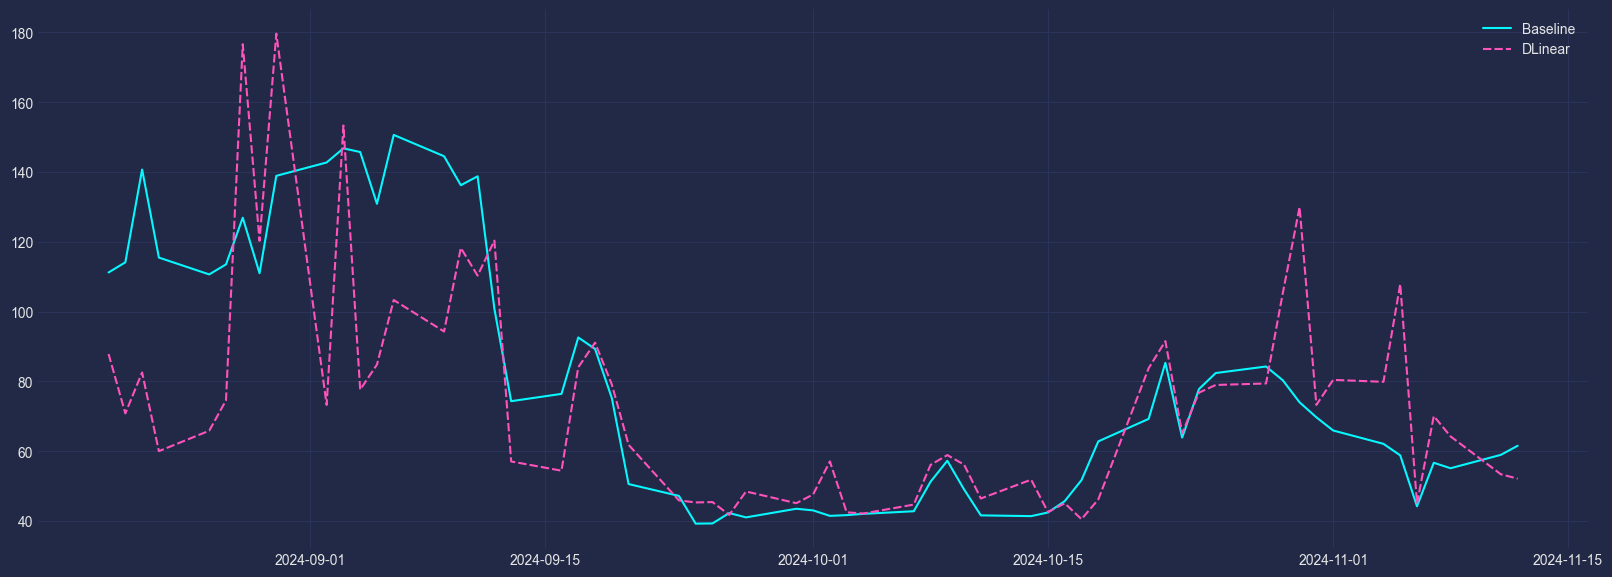

In [62]:
plt.figure(figsize=(20, 7))
sns.lineplot(metrics_df)
plt.show()

# TimesNET

In [34]:
def objective_timesnet(trial, dataset):
    params = {
        "input_size": trial.suggest_categorical(
            "input_size",
            [n_steps, n_steps * 2, n_steps * 3, n_steps * 4, n_steps * 5],
        ),
        "hidden_size": trial.suggest_categorical("hidden_size", [32, 64, 128]),
        "conv_hidden_size": trial.suggest_categorical(
            "conv_hidden_size", [32, 64, 128]
        ),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "scaler_type": trial.suggest_categorical("scaler_type", ["robust", "standard"]),
        "max_steps": trial.suggest_categorical("max_steps", [500, 1000]),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128]),
        "windows_batch_size": trial.suggest_categorical(
            "windows_batch_size", [32, 64, 128, 256]
        ),
    }
    model = TimesNet(h=n_steps, random_seed=RND, **params)
    model.fit(dataset, val_size=n_steps, test_size=n_steps, random_seed=RND)
    return model.metrics["ptl/val_loss"]

In [35]:
index = []
errors = []
for i, h in enumerate(tqdm(range(-n_steps * 2, -n_steps + 1))):
    Y_ts = df[["ds", "unique_id", "y"]].copy()
    df_train = df.iloc[:h]
    Y_train = Y_ts.iloc[:h]
    if h + n_steps == 0:
        df_test = df.iloc[h:]
        Y_test = Y_ts.iloc[h:]
    else:
        df_test = df.iloc[h : h + n_steps]
        Y_test = Y_ts.iloc[h : h + n_steps]
    study_path = "study_timesnet_e3.db"
    study = optuna.create_study(
        storage="sqlite:///{}".format(study_path),
        study_name=study_path,
        direction="minimize",
        load_if_exists=True,
    )
    dataset, *_ = TimeSeriesDataset.from_df(df_train)
    func = lambda x: objective_timesnet(x, dataset)
    study.optimize(
        func,
        n_trials=1 if i == 0 else 1,
        show_progress_bar=True,
        n_jobs=1,
        gc_after_trial=True,
    )
    dataset, *_ = TimeSeriesDataset.from_df(df_train)
    model = TimesNet(
        h=n_steps,
        random_seed=RND,
        enable_progress_bar=False,
        # loss=DistributionLoss(distribution="Normal", level=[80]),
        **study.best_params
    )
    model.fit(dataset=dataset, random_seed=RND)
    y_hat = model.predict(dataset=dataset, random_seed=RND)
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = np.mean(y_hat, axis=1)
    y_hat = y_hat.flatten()
    predicted_df = pd.DataFrame(
        {
            model.__class__.__name__: y_hat,
            "ds": Y_test.ds,
            "unique_id": Y_test.unique_id,
        }
    )
    index.append(Y_train.ds[-1])
    mae = mean_absolute_error(
        Y_test["y"].values, predicted_df[model.__class__.__name__]
    )
    errors.append(mae)
    torch.cuda.empty_cache()


  0%|                                                                                           | 0/61 [00:00<?, ?it/s][I 2025-02-06 11:38:54,667] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
  0%|                                                                                         | 0/61 [1:10:43<?, ?it/s]

[I 2025-02-06 12:49:38,130] Trial 21 finished with value: 168.91171264648438 and parameters: {'input_size': 180, 'hidden_size': 128, 'conv_hidden_size': 128, 'learning_rate': 0.03246497374182165, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 3 with value: 87.33814239501953.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  2%|█▏                                                                          | 1/61 [1:11:18<71:18:10, 4278.17s/it][I 2025-02-06 12:50:12,836] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
  2%|█▏                                                                          | 1/61 [1:12:40<71:18:10, 4278.17s/it]

[I 2025-02-06 12:51:35,600] Trial 22 finished with value: 212.6287078857422 and parameters: {'input_size': 300, 'hidden_size': 64, 'conv_hidden_size': 64, 'learning_rate': 0.011884263689490472, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 64}. Best is trial 3 with value: 87.33814239501953.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  3%|██▍                                                                         | 2/61 [1:13:14<29:59:38, 1830.14s/it][I 2025-02-06 12:52:09,348] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
  3%|██▍                                                                         | 2/61 [1:14:48<29:59:38, 1830.14s/it]Seed set to 0


[I 2025-02-06 12:53:43,483] Trial 23 finished with value: 247.0314178466797 and parameters: {'input_size': 120, 'hidden_size': 64, 'conv_hidden_size': 64, 'learning_rate': 0.08854177478743289, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 64}. Best is trial 3 with value: 87.33814239501953.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  5%|███▋                                                                        | 3/61 [1:15:23<16:58:00, 1053.12s/it][I 2025-02-06 12:54:17,818] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
  5%|███▋                                                                        | 3/61 [1:16:53<16:58:00, 1053.12s/it]

[I 2025-02-06 12:55:48,635] Trial 24 finished with value: 178.16995239257812 and parameters: {'input_size': 120, 'hidden_size': 64, 'conv_hidden_size': 64, 'learning_rate': 0.09360503112073416, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 64}. Best is trial 3 with value: 87.33814239501953.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  7%|█████                                                                        | 4/61 [1:17:27<10:52:12, 686.54s/it][I 2025-02-06 12:56:22,393] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
  7%|█████                                                                        | 4/61 [1:18:53<10:52:12, 686.54s/it]

[I 2025-02-06 12:57:48,423] Trial 25 finished with value: 170.15994262695312 and parameters: {'input_size': 120, 'hidden_size': 64, 'conv_hidden_size': 64, 'learning_rate': 0.01749725826147136, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 64}. Best is trial 3 with value: 87.33814239501953.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  8%|██████▍                                                                       | 5/61 [1:19:27<7:29:58, 482.12s/it][I 2025-02-06 12:58:22,053] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
  8%|██████▍                                                                       | 5/61 [1:20:51<7:29:58, 482.12s/it]

[I 2025-02-06 12:59:45,742] Trial 26 finished with value: 183.7036590576172 and parameters: {'input_size': 120, 'hidden_size': 64, 'conv_hidden_size': 64, 'learning_rate': 0.05696501506368212, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 64}. Best is trial 3 with value: 87.33814239501953.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 10%|███████▋                                                                      | 6/61 [1:21:23<5:28:00, 357.83s/it][I 2025-02-06 13:00:18,617] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 10%|███████▋                                                                      | 6/61 [1:22:31<5:28:00, 357.83s/it]Seed set to 0
GPU available: True (cuda), used: True


[I 2025-02-06 13:01:26,157] Trial 27 finished with value: 175.55865478515625 and parameters: {'input_size': 240, 'hidden_size': 32, 'conv_hidden_size': 32, 'learning_rate': 0.019248437805272592, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 64, 'windows_batch_size': 64}. Best is trial 3 with value: 87.33814239501953.


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 11%|████████▉                                                                     | 7/61 [1:23:04<4:06:16, 273.64s/it][I 2025-02-06 13:01:58,937] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 11%|████████▉                                                                     | 7/61 [1:25:32<4:06:16, 273.64s/it]

[I 2025-02-06 13:04:27,528] Trial 28 finished with value: 100.13806915283203 and parameters: {'input_size': 120, 'hidden_size': 64, 'conv_hidden_size': 64, 'learning_rate': 0.05678426986606435, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 128}. Best is trial 3 with value: 87.33814239501953.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 13%|██████████▏                                                                   | 8/61 [1:26:06<3:35:52, 244.39s/it][I 2025-02-06 13:05:00,681] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 13%|██████████▏                                                                   | 8/61 [1:28:50<3:35:52, 244.39s/it]

[I 2025-02-06 13:07:45,544] Trial 29 finished with value: 162.67337036132812 and parameters: {'input_size': 120, 'hidden_size': 64, 'conv_hidden_size': 64, 'learning_rate': 0.005670489106687927, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 128}. Best is trial 3 with value: 87.33814239501953.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 15%|███████████▌                                                                  | 9/61 [1:29:23<3:19:03, 229.69s/it][I 2025-02-06 13:08:18,046] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 15%|███████████▌                                                                  | 9/61 [1:33:39<3:19:03, 229.69s/it]Seed set to 0
GPU available: True (cuda), used: True


[I 2025-02-06 13:12:33,750] Trial 30 finished with value: 187.55767822265625 and parameters: {'input_size': 120, 'hidden_size': 128, 'conv_hidden_size': 128, 'learning_rate': 0.024034488977279857, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 128}. Best is trial 3 with value: 87.33814239501953.


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 16%|████████████▌                                                                | 10/61 [1:34:11<3:30:41, 247.88s/it][I 2025-02-06 13:13:06,646] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 16%|████████████▌                                                                | 10/61 [1:35:54<3:30:41, 247.88s/it]Seed set to 0
GPU available: True (cuda), used: True


[I 2025-02-06 13:14:48,795] Trial 31 finished with value: 196.0018768310547 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 32, 'learning_rate': 0.05265742321206688, 'scaler_type': 'robust', 'max_steps': 1000, 'batch_size': 64, 'windows_batch_size': 128}. Best is trial 3 with value: 87.33814239501953.


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 18%|█████████████▉                                                               | 11/61 [1:36:27<2:57:50, 213.41s/it][I 2025-02-06 13:15:21,908] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 18%|█████████████▉                                                               | 11/61 [1:43:32<2:57:50, 213.41s/it]

[I 2025-02-06 13:22:26,996] Trial 32 finished with value: 193.41354370117188 and parameters: {'input_size': 240, 'hidden_size': 128, 'conv_hidden_size': 32, 'learning_rate': 0.00017240753428632988, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 64, 'windows_batch_size': 128}. Best is trial 3 with value: 87.33814239501953.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 20%|███████████████▏                                                             | 12/61 [1:44:05<3:55:03, 287.84s/it][I 2025-02-06 13:22:59,971] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 20%|███████████████▏                                                             | 12/61 [1:46:54<3:55:03, 287.84s/it]

[I 2025-02-06 13:25:48,927] Trial 33 finished with value: 189.59036254882812 and parameters: {'input_size': 120, 'hidden_size': 64, 'conv_hidden_size': 64, 'learning_rate': 0.06605966111904484, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 128}. Best is trial 3 with value: 87.33814239501953.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 21%|████████████████▍                                                            | 13/61 [1:47:28<3:29:42, 262.13s/it][I 2025-02-06 13:26:22,948] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 21%|████████████████▍                                                            | 13/61 [1:52:51<3:29:42, 262.13s/it]

[I 2025-02-06 13:31:46,520] Trial 34 finished with value: 178.7667694091797 and parameters: {'input_size': 120, 'hidden_size': 64, 'conv_hidden_size': 64, 'learning_rate': 0.09694904941042311, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 256}. Best is trial 3 with value: 87.33814239501953.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 23%|█████████████████▋                                                           | 14/61 [1:53:26<3:47:57, 291.02s/it][I 2025-02-06 13:32:20,716] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 23%|█████████████████▋                                                           | 14/61 [1:54:49<3:47:57, 291.02s/it]

[I 2025-02-06 13:33:44,601] Trial 35 finished with value: 169.2786102294922 and parameters: {'input_size': 300, 'hidden_size': 64, 'conv_hidden_size': 64, 'learning_rate': 0.0024909610563915493, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 32}. Best is trial 3 with value: 87.33814239501953.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 25%|██████████████████▉                                                          | 15/61 [1:55:23<3:02:58, 238.67s/it][I 2025-02-06 13:34:18,082] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 25%|██████████████████▉                                                          | 15/61 [1:57:09<3:02:58, 238.67s/it]

[I 2025-02-06 13:36:04,476] Trial 36 finished with value: 147.5060577392578 and parameters: {'input_size': 60, 'hidden_size': 64, 'conv_hidden_size': 64, 'learning_rate': 0.0008014277152411149, 'scaler_type': 'robust', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 128}. Best is trial 3 with value: 87.33814239501953.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 26%|████████████████████▏                                                        | 16/61 [1:57:43<2:36:47, 209.05s/it][I 2025-02-06 13:36:38,356] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 26%|████████████████████▏                                                        | 16/61 [1:58:24<2:36:47, 209.05s/it]

[I 2025-02-06 13:37:18,976] Trial 37 finished with value: 132.8329315185547 and parameters: {'input_size': 120, 'hidden_size': 64, 'conv_hidden_size': 64, 'learning_rate': 0.04089719161336128, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 64}. Best is trial 3 with value: 87.33814239501953.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 28%|█████████████████████▍                                                       | 17/61 [1:58:57<2:03:32, 168.48s/it][I 2025-02-06 13:37:52,464] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 28%|█████████████████████▍                                                       | 17/61 [1:59:35<2:03:32, 168.48s/it]

[I 2025-02-06 13:38:30,331] Trial 38 finished with value: 154.22964477539062 and parameters: {'input_size': 120, 'hidden_size': 64, 'conv_hidden_size': 64, 'learning_rate': 0.00025192622085696534, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128, 'windows_batch_size': 64}. Best is trial 3 with value: 87.33814239501953.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 30%|██████████████████████▋                                                      | 18/61 [2:00:09<1:39:50, 139.32s/it][I 2025-02-06 13:39:03,914] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 30%|██████████████████████▋                                                      | 18/61 [2:01:41<1:39:50, 139.32s/it]

[I 2025-02-06 13:40:35,857] Trial 39 finished with value: 156.64743041992188 and parameters: {'input_size': 60, 'hidden_size': 32, 'conv_hidden_size': 64, 'learning_rate': 0.024546481197049233, 'scaler_type': 'robust', 'max_steps': 1000, 'batch_size': 128, 'windows_batch_size': 128}. Best is trial 3 with value: 87.33814239501953.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 31%|███████████████████████▉                                                     | 19/61 [2:02:15<1:34:40, 135.26s/it][I 2025-02-06 13:41:09,711] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 31%|███████████████████████▉                                                     | 19/61 [2:04:02<1:34:40, 135.26s/it]

[I 2025-02-06 13:42:57,174] Trial 40 finished with value: 77.13367462158203 and parameters: {'input_size': 180, 'hidden_size': 64, 'conv_hidden_size': 128, 'learning_rate': 0.06352759030804064, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 40 with value: 77.13367462158203.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 33%|█████████████████████████▏                                                   | 20/61 [2:05:36<1:45:54, 154.99s/it][I 2025-02-06 13:44:30,681] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 33%|█████████████████████████▏                                                   | 20/61 [2:06:52<1:45:54, 154.99s/it]

[I 2025-02-06 13:45:47,112] Trial 41 finished with value: 172.63096618652344 and parameters: {'input_size': 180, 'hidden_size': 128, 'conv_hidden_size': 128, 'learning_rate': 0.0140476788897989, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 32}. Best is trial 40 with value: 77.13367462158203.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 34%|██████████████████████████▌                                                  | 21/61 [2:08:27<1:46:39, 159.98s/it][I 2025-02-06 13:47:22,291] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 34%|██████████████████████████▌                                                  | 21/61 [2:13:19<1:46:39, 159.98s/it]

[I 2025-02-06 13:52:14,124] Trial 42 finished with value: 64.95928955078125 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.05729403806781982, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 42 with value: 64.95928955078125.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 36%|███████████████████████████▊                                                 | 22/61 [2:18:22<3:08:50, 290.52s/it][I 2025-02-06 13:57:17,258] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 36%|███████████████████████████▊                                                 | 22/61 [2:23:23<3:08:50, 290.52s/it]

[I 2025-02-06 14:02:18,232] Trial 43 finished with value: 106.7263412475586 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.05465377605328308, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 42 with value: 64.95928955078125.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 38%|█████████████████████████████                                                | 23/61 [2:28:17<4:01:49, 381.83s/it][I 2025-02-06 14:07:12,056] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 38%|█████████████████████████████                                                | 23/61 [2:33:15<4:01:49, 381.83s/it]

[I 2025-02-06 14:12:10,171] Trial 44 finished with value: 63.37025451660156 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.03577708598475163, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 44 with value: 63.37025451660156.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 39%|██████████████████████████████▎                                              | 24/61 [2:38:21<4:36:31, 448.43s/it][I 2025-02-06 14:17:15,839] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 39%|██████████████████████████████▎                                              | 24/61 [2:43:16<4:36:31, 448.43s/it]

[I 2025-02-06 14:22:10,985] Trial 45 finished with value: 28.242528915405273 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.03296468580706182, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 41%|███████████████████████████████▌                                             | 25/61 [2:48:13<4:54:58, 491.63s/it][I 2025-02-06 14:27:08,246] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 41%|███████████████████████████████▌                                             | 25/61 [2:53:10<4:54:58, 491.63s/it]

[I 2025-02-06 14:32:05,020] Trial 46 finished with value: 63.355613708496094 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.030381629146083465, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 43%|████████████████████████████████▊                                            | 26/61 [2:58:16<5:06:18, 525.11s/it][I 2025-02-06 14:37:11,474] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 43%|████████████████████████████████▊                                            | 26/61 [3:03:18<5:06:18, 525.11s/it]

[I 2025-02-06 14:42:13,300] Trial 47 finished with value: 58.51356887817383 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.03011332121830423, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 44%|██████████████████████████████████                                           | 27/61 [3:08:14<5:09:49, 546.76s/it][I 2025-02-06 14:47:08,753] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 44%|██████████████████████████████████                                           | 27/61 [3:13:11<5:09:49, 546.76s/it]

[I 2025-02-06 14:52:05,974] Trial 48 finished with value: 32.42927551269531 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.0281913996176777, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 46%|███████████████████████████████████▎                                         | 28/61 [3:18:03<5:07:41, 559.45s/it][I 2025-02-06 14:56:57,818] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 46%|███████████████████████████████████▎                                         | 28/61 [3:23:05<5:07:41, 559.45s/it]

[I 2025-02-06 15:01:59,805] Trial 49 finished with value: 45.74360656738281 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.03003608923545527, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 48%|████████████████████████████████████▌                                        | 29/61 [3:27:48<5:02:35, 567.37s/it][I 2025-02-06 15:06:43,655] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 48%|████████████████████████████████████▌                                        | 29/61 [3:32:51<5:02:35, 567.37s/it]

[I 2025-02-06 15:11:46,172] Trial 50 finished with value: 33.82355499267578 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.008848311595684735, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 49%|█████████████████████████████████████▊                                       | 30/61 [3:37:50<4:58:28, 577.70s/it][I 2025-02-06 15:16:45,454] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 49%|█████████████████████████████████████▊                                       | 30/61 [3:42:52<4:58:28, 577.70s/it]

[I 2025-02-06 15:21:46,875] Trial 51 finished with value: 38.78103256225586 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.008177688190257845, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 51%|███████████████████████████████████████▏                                     | 31/61 [3:47:42<4:51:01, 582.03s/it][I 2025-02-06 15:26:37,602] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 51%|███████████████████████████████████████▏                                     | 31/61 [3:52:53<4:51:01, 582.03s/it]

[I 2025-02-06 15:31:48,300] Trial 52 finished with value: 126.25994110107422 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.007394083051842418, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 52%|████████████████████████████████████████▍                                    | 32/61 [3:57:50<4:44:58, 589.60s/it][I 2025-02-06 15:36:44,863] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 52%|████████████████████████████████████████▍                                    | 32/61 [4:02:48<4:44:58, 589.60s/it]

[I 2025-02-06 15:41:43,075] Trial 53 finished with value: 62.32855224609375 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.01613731132989813, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 54%|█████████████████████████████████████████▋                                   | 33/61 [4:07:53<4:37:01, 593.63s/it][I 2025-02-06 15:46:47,903] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 54%|█████████████████████████████████████████▋                                   | 33/61 [4:13:04<4:37:01, 593.63s/it]

[I 2025-02-06 15:51:58,866] Trial 54 finished with value: 39.634334564208984 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.008159220841465606, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 56%|██████████████████████████████████████████▉                                  | 34/61 [4:18:09<4:30:13, 600.50s/it][I 2025-02-06 15:57:04,430] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 56%|██████████████████████████████████████████▉                                  | 34/61 [4:22:52<4:30:13, 600.50s/it]

[I 2025-02-06 16:01:47,053] Trial 55 finished with value: 99.3582992553711 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.0031179011828229315, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 57%|████████████████████████████████████████████▏                                | 35/61 [4:27:55<4:18:20, 596.17s/it][I 2025-02-06 16:06:50,484] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 57%|████████████████████████████████████████████▏                                | 35/61 [4:32:54<4:18:20, 596.17s/it]

[I 2025-02-06 16:11:48,709] Trial 56 finished with value: 63.208213806152344 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.007797832676492052, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 59%|█████████████████████████████████████████████▍                               | 36/61 [4:37:39<4:06:52, 592.50s/it][I 2025-02-06 16:16:34,427] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 59%|█████████████████████████████████████████████▍                               | 36/61 [4:42:53<4:06:52, 592.50s/it]

[I 2025-02-06 16:21:48,073] Trial 57 finished with value: 50.9783821105957 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.011916832049021983, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 61%|██████████████████████████████████████████████▋                              | 37/61 [4:47:53<3:59:33, 598.91s/it][I 2025-02-06 16:26:48,311] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 61%|██████████████████████████████████████████████▋                              | 37/61 [4:52:22<3:59:33, 598.91s/it]

[I 2025-02-06 16:31:17,425] Trial 58 finished with value: 87.29005432128906 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.005487708200016919, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 62%|███████████████████████████████████████████████▉                             | 38/61 [4:57:29<3:46:53, 591.89s/it][I 2025-02-06 16:36:23,813] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 62%|███████████████████████████████████████████████▉                             | 38/61 [5:02:25<3:46:53, 591.89s/it]

[I 2025-02-06 16:41:19,864] Trial 59 finished with value: 72.40184020996094 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.022612985232099883, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 64%|█████████████████████████████████████████████████▏                           | 39/61 [5:07:27<3:37:46, 593.93s/it][I 2025-02-06 16:46:22,513] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 64%|█████████████████████████████████████████████████▏                           | 39/61 [5:12:23<3:37:46, 593.93s/it]

[I 2025-02-06 16:51:18,091] Trial 60 finished with value: 103.01412963867188 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.008103011733873504, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 66%|██████████████████████████████████████████████████▍                          | 40/61 [5:17:39<3:29:45, 599.30s/it][I 2025-02-06 16:56:34,337] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 66%|██████████████████████████████████████████████████▍                          | 40/61 [5:22:42<3:29:45, 599.30s/it]

[I 2025-02-06 17:01:36,864] Trial 61 finished with value: 111.5650405883789 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.004033836202839373, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 67%|███████████████████████████████████████████████████▊                         | 41/61 [5:27:50<3:20:53, 602.68s/it][I 2025-02-06 17:06:44,917] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 67%|███████████████████████████████████████████████████▊                         | 41/61 [5:33:08<3:20:53, 602.68s/it]

[I 2025-02-06 17:12:03,185] Trial 62 finished with value: 97.3353500366211 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.012471834394678498, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 69%|█████████████████████████████████████████████████████                        | 42/61 [5:38:17<3:13:09, 609.99s/it][I 2025-02-06 17:17:11,961] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 69%|█████████████████████████████████████████████████████                        | 42/61 [5:43:32<3:13:09, 609.99s/it]

[I 2025-02-06 17:22:26,839] Trial 63 finished with value: 110.7557144165039 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.0104057645907769, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 70%|██████████████████████████████████████████████████████▎                      | 43/61 [5:48:36<3:03:50, 612.81s/it][I 2025-02-06 17:27:31,346] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 70%|██████████████████████████████████████████████████████▎                      | 43/61 [5:53:59<3:03:50, 612.81s/it]

[I 2025-02-06 17:32:54,265] Trial 64 finished with value: 82.10262298583984 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.014468639321100686, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 72%|███████████████████████████████████████████████████████▌                     | 44/61 [5:59:13<2:55:41, 620.08s/it][I 2025-02-06 17:38:08,377] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 72%|███████████████████████████████████████████████████████▌                     | 44/61 [6:03:44<2:55:41, 620.08s/it]

[I 2025-02-06 17:42:39,170] Trial 65 finished with value: 112.28858184814453 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.0064113785984890904, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 74%|████████████████████████████████████████████████████████▊                    | 45/61 [6:09:08<2:43:17, 612.34s/it][I 2025-02-06 17:48:02,671] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 74%|████████████████████████████████████████████████████████▊                    | 45/61 [6:13:41<2:43:17, 612.34s/it]

[I 2025-02-06 17:52:36,089] Trial 66 finished with value: 124.48526763916016 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.009176827610152701, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 75%|██████████████████████████████████████████████████████████                   | 46/61 [6:18:44<2:30:23, 601.56s/it][I 2025-02-06 17:57:39,078] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 75%|██████████████████████████████████████████████████████████                   | 46/61 [8:28:39<2:30:23, 601.56s/it]

[I 2025-02-06 20:07:34,228] Trial 67 finished with value: 57.1873893737793 and parameters: {'input_size': 300, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.0042340586465507285, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 77%|█████████████████████████████████████████████████████████▊                 | 47/61 [8:33:48<11:05:30, 2852.21s/it][I 2025-02-06 20:12:42,800] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 77%|█████████████████████████████████████████████████████████▊                 | 47/61 [8:38:57<11:05:30, 2852.21s/it]

[I 2025-02-06 20:17:52,466] Trial 68 finished with value: 32.83298873901367 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.01842666192995016, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 79%|███████████████████████████████████████████████████████████▊                | 48/61 [8:44:08<7:52:53, 2182.61s/it][I 2025-02-06 20:23:03,013] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 79%|███████████████████████████████████████████████████████████▊                | 48/61 [8:49:44<7:52:53, 2182.61s/it]

[I 2025-02-06 20:28:39,024] Trial 69 finished with value: 91.88151550292969 and parameters: {'input_size': 240, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.019961067521054403, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 80%|█████████████████████████████████████████████████████████████               | 49/61 [8:54:45<5:43:47, 1718.94s/it][I 2025-02-06 20:33:40,067] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 80%|█████████████████████████████████████████████████████████████               | 49/61 [8:59:45<5:43:47, 1718.94s/it]

[I 2025-02-06 20:38:39,807] Trial 70 finished with value: 85.6875991821289 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.025695174688102475, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 82%|██████████████████████████████████████████████████████████████▎             | 50/61 [9:04:30<4:12:48, 1378.94s/it][I 2025-02-06 20:43:25,661] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 82%|██████████████████████████████████████████████████████████████▎             | 50/61 [9:07:19<4:12:48, 1378.94s/it]

[I 2025-02-06 20:46:13,787] Trial 71 finished with value: 55.9928092956543 and parameters: {'input_size': 60, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.03803982609091437, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 84%|███████████████████████████████████████████████████████████████▌            | 51/61 [9:12:00<3:03:20, 1100.04s/it][I 2025-02-06 20:50:54,935] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 84%|███████████████████████████████████████████████████████████████▌            | 51/61 [9:13:50<3:03:20, 1100.04s/it]

[I 2025-02-06 20:52:45,600] Trial 72 finished with value: 70.03396606445312 and parameters: {'input_size': 180, 'hidden_size': 128, 'conv_hidden_size': 128, 'learning_rate': 0.04545630835434176, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 32}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 85%|█████████████████████████████████████████████████████████████████▋           | 52/61 [9:18:23<2:12:44, 884.91s/it][I 2025-02-06 20:57:17,871] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 85%|█████████████████████████████████████████████████████████████████▋           | 52/61 [9:23:01<2:12:44, 884.91s/it]

[I 2025-02-06 21:01:56,185] Trial 73 finished with value: 44.95409393310547 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.012310397038478405, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 87%|██████████████████████████████████████████████████████████████████▉          | 53/61 [9:28:06<1:45:56, 794.54s/it][I 2025-02-06 21:07:01,565] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 87%|██████████████████████████████████████████████████████████████████▉          | 53/61 [9:33:03<1:45:56, 794.54s/it]

[I 2025-02-06 21:11:58,410] Trial 74 finished with value: 61.410648345947266 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.018609255196359226, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 89%|████████████████████████████████████████████████████████████████████▏        | 54/61 [9:38:22<1:26:25, 740.74s/it][I 2025-02-06 21:17:16,754] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 89%|████████████████████████████████████████████████████████████████████▏        | 54/61 [9:43:41<1:26:25, 740.74s/it]

[I 2025-02-06 21:22:36,511] Trial 75 finished with value: 46.51802444458008 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.009752910417736637, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 90%|█████████████████████████████████████████████████████████████████████▍       | 55/61 [9:49:02<1:11:03, 710.53s/it][I 2025-02-06 21:27:56,788] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 90%|█████████████████████████████████████████████████████████████████████▍       | 55/61 [9:54:19<1:11:03, 710.53s/it]

[I 2025-02-06 21:33:13,853] Trial 76 finished with value: 30.240108489990234 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.01683238910673344, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 92%|████████████████████████████████████████████████████████████████████████▌      | 56/61 [9:59:31<57:10, 686.20s/it][I 2025-02-06 21:38:26,216] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 92%|███████████████████████████████████████████████████████████████████████▌      | 56/61 [10:09:23<57:10, 686.20s/it]

[I 2025-02-06 21:48:17,907] Trial 77 finished with value: 81.93032836914062 and parameters: {'input_size': 300, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.01607473367856708, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 93%|████████████████████████████████████████████████████████████████████████▉     | 57/61 [10:14:28<49:58, 749.53s/it][I 2025-02-06 21:53:23,535] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 93%|████████████████████████████████████████████████████████████████████████▉     | 57/61 [10:19:37<49:58, 749.53s/it]

[I 2025-02-06 21:58:31,808] Trial 78 finished with value: 43.58883285522461 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.013007366830817711, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 95%|██████████████████████████████████████████████████████████████████████████▏   | 58/61 [10:24:43<35:27, 709.13s/it][I 2025-02-06 22:03:38,381] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 95%|██████████████████████████████████████████████████████████████████████████▏   | 58/61 [10:31:18<35:27, 709.13s/it]

[I 2025-02-06 22:10:13,400] Trial 79 finished with value: 108.47644805908203 and parameters: {'input_size': 240, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.02089265099047799, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 97%|███████████████████████████████████████████████████████████████████████████▍  | 59/61 [10:36:35<23:39, 709.88s/it][I 2025-02-06 22:15:30,008] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 97%|███████████████████████████████████████████████████████████████████████████▍  | 59/61 [10:41:41<23:39, 709.88s/it]

[I 2025-02-06 22:20:35,995] Trial 80 finished with value: 59.65385437011719 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 128, 'learning_rate': 0.004703519193240995, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64, 'windows_batch_size': 256}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

 98%|████████████████████████████████████████████████████████████████████████████▋ | 60/61 [10:47:00<11:24, 684.38s/it][I 2025-02-06 22:25:54,903] Using an existing study with name 'study_timesnet_e3.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 98%|████████████████████████████████████████████████████████████████████████████▋ | 60/61 [10:47:30<11:24, 684.38s/it]

[I 2025-02-06 22:26:25,309] Trial 81 finished with value: 80.81658172607422 and parameters: {'input_size': 180, 'hidden_size': 32, 'conv_hidden_size': 32, 'learning_rate': 0.006555930429374915, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32, 'windows_batch_size': 32}. Best is trial 45 with value: 28.242528915405273.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

100%|██████████████████████████████████████████████████████████████████████████████| 61/61 [10:52:51<00:00, 642.15s/it]


In [36]:
metrics_df["TimesNet"] = errors

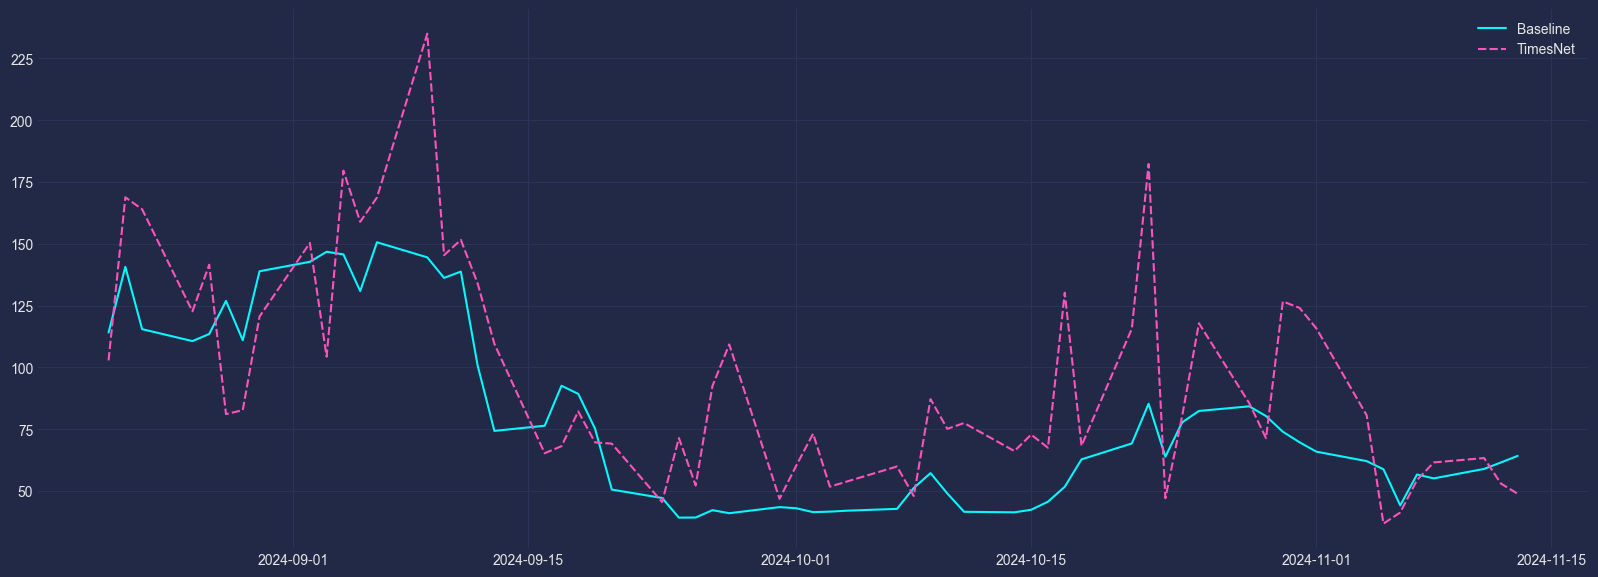

In [37]:
plt.figure(figsize=(20, 7))
sns.lineplot(metrics_df)
plt.show()

# MLPMultivariate

In [39]:
def objective_mlpmultivariate(trial, dataset):
    params = {
        "input_size": trial.suggest_categorical(
            "input_size",
            [n_steps, n_steps * 2, n_steps * 3, n_steps * 4, n_steps * 5],
        ),
        "hidden_size": trial.suggest_categorical("hidden_size", [256, 512, 1024]),
        "num_layers": trial.suggest_int("num_layers", 2, 6),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "scaler_type": trial.suggest_categorical(
            "scaler_type", [None, "robust", "standard"]
        ),
        "max_steps": trial.suggest_categorical("max_steps", [500, 1000]),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128, 256]),
    }
    # print(params)

    model = MLPMultivariate(
        h=n_steps, n_series=1, hist_exog_list=exog_cols, random_seed=RND, **params
    )
    model.fit(dataset, val_size=n_steps, test_size=n_steps, random_seed=RND)
    return model.metrics["ptl/val_loss"]

In [42]:
index = []
errors = []
for i, h in enumerate(tqdm(range(-n_steps * 2, -n_steps + 1))):
    Y_ts = df[["ds", "unique_id", "y"]].copy()
    df_train = df.iloc[:h]
    Y_train = Y_ts.iloc[:h]
    if h + n_steps == 0:
        df_test = df.iloc[h:]
        Y_test = Y_ts.iloc[h:]
    else:
        df_test = df.iloc[h : h + n_steps]
        Y_test = Y_ts.iloc[h : h + n_steps]
    study_path = "study_mlpmultivariate_e.db"
    study = optuna.create_study(
        storage="sqlite:///{}".format(study_path),
        study_name=study_path,
        direction="minimize",
        load_if_exists=True,
    )
    dataset, *_ = TimeSeriesDataset.from_df(df_train)
    func = lambda x: objective_mlpmultivariate(x, dataset)
    study.optimize(
        func,
        n_trials=10 if i == 0 else 1,
        show_progress_bar=True,
        n_jobs=1,
        gc_after_trial=True,
    )
    dataset, *_ = TimeSeriesDataset.from_df(df_train)
    model = MLPMultivariate(
        h=n_steps,
        n_series=1,
        hist_exog_list=exog_cols,
        random_seed=RND,
        enable_progress_bar=True,
        **study.best_params
    )
    model.fit(dataset=dataset, random_seed=RND)
    y_hat = model.predict(dataset=dataset, random_seed=RND)
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = np.mean(y_hat, axis=1)
    y_hat = y_hat.flatten()
    predicted_df = pd.DataFrame(
        {
            model.__class__.__name__: y_hat,
            "ds": Y_test.ds,
            "unique_id": Y_test.unique_id,
        }
    )
    index.append(Y_train.ds[-1])
    mae = mean_absolute_error(
        Y_test["y"].values, predicted_df[model.__class__.__name__]
    )
    errors.append(mae)
    torch.cuda.empty_cache()


  0%|                                                                                           | 0/61 [00:00<?, ?it/s][I 2025-02-06 23:06:47,242] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/10 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
  0%|                                                                                           | 0/61 [00:14<?, ?it/s]

[I 2025-02-06 23:07:01,289] Trial 1 finished with value: 23.92369842529297 and parameters: {'input_size': 60, 'hidden_size': 1024, 'num_layers': 5, 'learning_rate': 0.08438379821512235, 'scaler_type': 'robust', 'max_steps': 1000, 'batch_size': 128}. Best is trial 1 with value: 23.92369842529297.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
  0%|                                                                                           | 0/61 [00:25<?, ?it/s]

[I 2025-02-06 23:07:12,895] Trial 2 finished with value: 236.96435546875 and parameters: {'input_size': 60, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.0005891453629646291, 'scaler_type': None, 'max_steps': 1000, 'batch_size': 256}. Best is trial 1 with value: 23.92369842529297.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
  0%|                                                                                           | 0/61 [00:38<?, ?it/s]

[I 2025-02-06 23:07:25,560] Trial 3 finished with value: 2.8881661891937256 and parameters: {'input_size': 120, 'hidden_size': 512, 'num_layers': 4, 'learning_rate': 0.0018858078145792408, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 32}. Best is trial 3 with value: 2.8881661891937256.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
  0%|                                                                                           | 0/61 [00:51<?, ?it/s]

[I 2025-02-06 23:07:38,293] Trial 4 finished with value: 4.057221412658691 and parameters: {'input_size': 240, 'hidden_size': 512, 'num_layers': 4, 'learning_rate': 0.000129770998276208, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 64}. Best is trial 3 with value: 2.8881661891937256.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
  0%|                                                                                           | 0/61 [01:03<?, ?it/s]

[I 2025-02-06 23:07:50,577] Trial 5 finished with value: 4.955538749694824 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 4, 'learning_rate': 0.059826371271954386, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 256}. Best is trial 3 with value: 2.8881661891937256.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
  0%|                                                                                           | 0/61 [01:14<?, ?it/s]

[I 2025-02-06 23:08:02,211] Trial 6 finished with value: 232.77456665039062 and parameters: {'input_size': 180, 'hidden_size': 1024, 'num_layers': 3, 'learning_rate': 0.00017376967881009808, 'scaler_type': None, 'max_steps': 1000, 'batch_size': 128}. Best is trial 3 with value: 2.8881661891937256.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
  0%|                                                                                           | 0/61 [01:26<?, ?it/s]

[I 2025-02-06 23:08:13,306] Trial 7 finished with value: 366.6346130371094 and parameters: {'input_size': 180, 'hidden_size': 1024, 'num_layers': 2, 'learning_rate': 0.003262824989689732, 'scaler_type': None, 'max_steps': 1000, 'batch_size': 32}. Best is trial 3 with value: 2.8881661891937256.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
  0%|                                                                                           | 0/61 [01:32<?, ?it/s]

[I 2025-02-06 23:08:19,314] Trial 8 finished with value: 187.7240447998047 and parameters: {'input_size': 120, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.0006394501917658375, 'scaler_type': None, 'max_steps': 500, 'batch_size': 128}. Best is trial 3 with value: 2.8881661891937256.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
  0%|                                                                                           | 0/61 [01:39<?, ?it/s]

[I 2025-02-06 23:08:26,581] Trial 9 finished with value: 2.0322983264923096 and parameters: {'input_size': 120, 'hidden_size': 256, 'num_layers': 6, 'learning_rate': 0.0003349029539083152, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32}. Best is trial 9 with value: 2.0322983264923096.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
  0%|                                                                                           | 0/61 [01:51<?, ?it/s]

[I 2025-02-06 23:08:38,439] Trial 10 finished with value: 3.872027635574341 and parameters: {'input_size': 180, 'hidden_size': 1024, 'num_layers': 2, 'learning_rate': 0.0010743150269396026, 'scaler_type': 'robust', 'max_steps': 1000, 'batch_size': 256}. Best is trial 9 with value: 2.0322983264923096.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


  2%|█▎                                                                              | 1/61 [01:58<1:58:05, 118.10s/it][I 2025-02-06 23:08:45,340] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
  2%|█▎                                                                              | 1/61 [02:04<1:58:05, 118.10s/it]

[I 2025-02-06 23:08:51,766] Trial 11 finished with value: 4.094156742095947 and parameters: {'input_size': 300, 'hidden_size': 256, 'num_layers': 6, 'learning_rate': 0.010029055333781789, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32}. Best is trial 9 with value: 2.0322983264923096.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


  3%|██▋                                                                                | 2/61 [02:11<55:29, 56.44s/it][I 2025-02-06 23:08:58,614] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
  3%|██▋                                                                                | 2/61 [02:17<55:29, 56.44s/it]

[I 2025-02-06 23:09:04,957] Trial 12 finished with value: 2.290712833404541 and parameters: {'input_size': 120, 'hidden_size': 512, 'num_layers': 6, 'learning_rate': 0.0033082011388292395, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32}. Best is trial 9 with value: 2.0322983264923096.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


  5%|████                                                                               | 3/61 [02:24<35:27, 36.67s/it][I 2025-02-06 23:09:11,772] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
  5%|████                                                                               | 3/61 [02:31<35:27, 36.67s/it]

[I 2025-02-06 23:09:18,774] Trial 13 finished with value: 2.9946649074554443 and parameters: {'input_size': 120, 'hidden_size': 512, 'num_layers': 6, 'learning_rate': 0.008052591801212544, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32}. Best is trial 9 with value: 2.0322983264923096.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


  7%|█████▍                                                                             | 4/61 [02:38<26:23, 27.78s/it][I 2025-02-06 23:09:25,905] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
  7%|█████▍                                                                             | 4/61 [02:45<26:23, 27.78s/it]

[I 2025-02-06 23:09:32,619] Trial 14 finished with value: 0.7455235123634338 and parameters: {'input_size': 120, 'hidden_size': 512, 'num_layers': 5, 'learning_rate': 0.0065409162176972655, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32}. Best is trial 14 with value: 0.7455235123634338.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


  8%|██████▊                                                                            | 5/61 [02:52<21:09, 22.67s/it][I 2025-02-06 23:09:39,513] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
  8%|██████▊                                                                            | 5/61 [02:58<21:09, 22.67s/it]

[I 2025-02-06 23:09:45,717] Trial 15 finished with value: 1.9839309453964233 and parameters: {'input_size': 120, 'hidden_size': 256, 'num_layers': 5, 'learning_rate': 0.02094185344719541, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64}. Best is trial 14 with value: 0.7455235123634338.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 10%|████████▏                                                                          | 6/61 [03:05<17:45, 19.37s/it][I 2025-02-06 23:09:52,489] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 10%|████████▏                                                                          | 6/61 [03:11<17:45, 19.37s/it]

[I 2025-02-06 23:09:58,885] Trial 16 finished with value: 4.523012161254883 and parameters: {'input_size': 300, 'hidden_size': 512, 'num_layers': 5, 'learning_rate': 0.022248097611739803, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64}. Best is trial 14 with value: 0.7455235123634338.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 11%|█████████▌                                                                         | 7/61 [03:18<15:35, 17.32s/it][I 2025-02-06 23:10:05,595] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 11%|█████████▌                                                                         | 7/61 [03:24<15:35, 17.32s/it]

[I 2025-02-06 23:10:12,206] Trial 17 finished with value: 10.031065940856934 and parameters: {'input_size': 120, 'hidden_size': 512, 'num_layers': 5, 'learning_rate': 0.025738124856182574, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 64}. Best is trial 14 with value: 0.7455235123634338.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 13%|██████████▉                                                                        | 8/61 [03:31<14:10, 16.04s/it][I 2025-02-06 23:10:18,880] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 13%|██████████▉                                                                        | 8/61 [03:37<14:10, 16.04s/it]

[I 2025-02-06 23:10:25,065] Trial 18 finished with value: 1.2488840818405151 and parameters: {'input_size': 120, 'hidden_size': 256, 'num_layers': 5, 'learning_rate': 0.009591856365149093, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64}. Best is trial 14 with value: 0.7455235123634338.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 15%|████████████▏                                                                      | 9/61 [03:44<13:02, 15.06s/it][I 2025-02-06 23:10:31,777] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 15%|████████████▏                                                                      | 9/61 [03:50<13:02, 15.06s/it]

[I 2025-02-06 23:10:37,666] Trial 19 finished with value: 1.9461385011672974 and parameters: {'input_size': 120, 'hidden_size': 512, 'num_layers': 3, 'learning_rate': 0.006707998579767271, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64}. Best is trial 14 with value: 0.7455235123634338.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 16%|█████████████▍                                                                    | 10/61 [03:57<12:08, 14.29s/it][I 2025-02-06 23:10:44,340] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 16%|█████████████▍                                                                    | 10/61 [04:03<12:08, 14.29s/it]

[I 2025-02-06 23:10:50,700] Trial 20 finished with value: 13.319917678833008 and parameters: {'input_size': 60, 'hidden_size': 256, 'num_layers': 5, 'learning_rate': 0.004513763622695829, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 64}. Best is trial 14 with value: 0.7455235123634338.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 18%|██████████████▊                                                                   | 11/61 [04:10<11:40, 14.00s/it][I 2025-02-06 23:10:57,704] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 18%|██████████████▊                                                                   | 11/61 [04:16<11:40, 14.00s/it]

[I 2025-02-06 23:11:03,619] Trial 21 finished with value: 3.248143434524536 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 3, 'learning_rate': 0.001516007287105988, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32}. Best is trial 14 with value: 0.7455235123634338.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 20%|████████████████▏                                                                 | 12/61 [04:23<11:08, 13.65s/it][I 2025-02-06 23:11:10,534] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 20%|████████████████▏                                                                 | 12/61 [04:29<11:08, 13.65s/it]

[I 2025-02-06 23:11:16,469] Trial 22 finished with value: 3.082695484161377 and parameters: {'input_size': 120, 'hidden_size': 512, 'num_layers': 3, 'learning_rate': 0.008243675304544245, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64}. Best is trial 14 with value: 0.7455235123634338.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 21%|█████████████████▍                                                                | 13/61 [04:35<10:38, 13.31s/it][I 2025-02-06 23:11:23,063] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 21%|█████████████████▍                                                                | 13/61 [04:41<10:38, 13.31s/it]

[I 2025-02-06 23:11:28,997] Trial 23 finished with value: 2.795893430709839 and parameters: {'input_size': 120, 'hidden_size': 512, 'num_layers': 3, 'learning_rate': 0.01434387464138765, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64}. Best is trial 14 with value: 0.7455235123634338.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 23%|██████████████████▊                                                               | 14/61 [04:48<10:16, 13.12s/it][I 2025-02-06 23:11:35,740] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 23%|██████████████████▊                                                               | 14/61 [04:54<10:16, 13.12s/it]

[I 2025-02-06 23:11:41,950] Trial 24 finished with value: 3.0439789295196533 and parameters: {'input_size': 120, 'hidden_size': 512, 'num_layers': 4, 'learning_rate': 0.00553245742576006, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64}. Best is trial 14 with value: 0.7455235123634338.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 25%|████████████████████▏                                                             | 15/61 [05:01<09:58, 13.00s/it][I 2025-02-06 23:11:48,469] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 25%|████████████████████▏                                                             | 15/61 [05:07<09:58, 13.00s/it]

[I 2025-02-06 23:11:54,858] Trial 25 finished with value: 4.2532219886779785 and parameters: {'input_size': 300, 'hidden_size': 512, 'num_layers': 5, 'learning_rate': 0.044762931690785254, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64}. Best is trial 14 with value: 0.7455235123634338.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 26%|█████████████████████▌                                                            | 16/61 [05:14<09:51, 13.14s/it][I 2025-02-06 23:12:01,943] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 26%|█████████████████████▌                                                            | 16/61 [05:21<09:51, 13.14s/it]

[I 2025-02-06 23:12:08,426] Trial 26 finished with value: 2.866917610168457 and parameters: {'input_size': 120, 'hidden_size': 512, 'num_layers': 4, 'learning_rate': 0.014902302619417895, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64}. Best is trial 14 with value: 0.7455235123634338.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 28%|██████████████████████▊                                                           | 17/61 [05:28<09:44, 13.28s/it][I 2025-02-06 23:12:15,541] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 28%|██████████████████████▊                                                           | 17/61 [05:34<09:44, 13.28s/it]

[I 2025-02-06 23:12:21,872] Trial 27 finished with value: 2.6121652126312256 and parameters: {'input_size': 120, 'hidden_size': 512, 'num_layers': 3, 'learning_rate': 0.002220839059772294, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128}. Best is trial 14 with value: 0.7455235123634338.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 30%|████████████████████████▏                                                         | 18/61 [05:41<09:30, 13.27s/it][I 2025-02-06 23:12:28,793] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 30%|████████████████████████▏                                                         | 18/61 [05:48<09:30, 13.27s/it]

[I 2025-02-06 23:12:35,307] Trial 28 finished with value: 2.55165958404541 and parameters: {'input_size': 120, 'hidden_size': 512, 'num_layers': 5, 'learning_rate': 0.004436925166212975, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 256}. Best is trial 14 with value: 0.7455235123634338.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 31%|█████████████████████████▌                                                        | 19/61 [05:54<09:19, 13.32s/it][I 2025-02-06 23:12:42,225] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 31%|█████████████████████████▌                                                        | 19/61 [06:00<09:19, 13.32s/it]

[I 2025-02-06 23:12:48,106] Trial 29 finished with value: 1899.9979248046875 and parameters: {'input_size': 120, 'hidden_size': 1024, 'num_layers': 4, 'learning_rate': 0.03695113203614144, 'scaler_type': None, 'max_steps': 500, 'batch_size': 64}. Best is trial 14 with value: 0.7455235123634338.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 33%|██████████████████████████▉                                                       | 20/61 [06:07<08:56, 13.09s/it][I 2025-02-06 23:12:54,780] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 33%|██████████████████████████▉                                                       | 20/61 [06:14<08:56, 13.09s/it]

[I 2025-02-06 23:13:01,441] Trial 30 finished with value: 13.702303886413574 and parameters: {'input_size': 60, 'hidden_size': 256, 'num_layers': 5, 'learning_rate': 0.08886875471990117, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 128}. Best is trial 14 with value: 0.7455235123634338.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 34%|████████████████████████████▏                                                     | 21/61 [06:21<08:49, 13.25s/it][I 2025-02-06 23:13:08,395] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 34%|████████████████████████████▏                                                     | 21/61 [06:27<08:49, 13.25s/it]

[I 2025-02-06 23:13:14,805] Trial 31 finished with value: 2.3047053813934326 and parameters: {'input_size': 180, 'hidden_size': 1024, 'num_layers': 6, 'learning_rate': 0.006537828224754096, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32}. Best is trial 14 with value: 0.7455235123634338.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 36%|█████████████████████████████▌                                                    | 22/61 [06:34<08:36, 13.24s/it][I 2025-02-06 23:13:21,607] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 36%|█████████████████████████████▌                                                    | 22/61 [06:40<08:36, 13.24s/it]

[I 2025-02-06 23:13:27,864] Trial 32 finished with value: 2.071483612060547 and parameters: {'input_size': 120, 'hidden_size': 256, 'num_layers': 5, 'learning_rate': 0.014759723377373142, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64}. Best is trial 14 with value: 0.7455235123634338.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 38%|██████████████████████████████▉                                                   | 23/61 [06:47<08:19, 13.15s/it][I 2025-02-06 23:13:34,543] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 38%|██████████████████████████████▉                                                   | 23/61 [06:53<08:19, 13.15s/it]

[I 2025-02-06 23:13:40,823] Trial 33 finished with value: 2.3832545280456543 and parameters: {'input_size': 120, 'hidden_size': 256, 'num_layers': 5, 'learning_rate': 0.02540544064988636, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64}. Best is trial 14 with value: 0.7455235123634338.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 39%|████████████████████████████████▎                                                 | 24/61 [07:00<08:05, 13.11s/it][I 2025-02-06 23:13:47,568] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 39%|████████████████████████████████▎                                                 | 24/61 [07:06<08:05, 13.11s/it]

[I 2025-02-06 23:13:53,595] Trial 34 finished with value: 0.3745456635951996 and parameters: {'input_size': 60, 'hidden_size': 256, 'num_layers': 4, 'learning_rate': 0.01139247201895218, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 41%|█████████████████████████████████▌                                                | 25/61 [07:13<07:47, 12.98s/it][I 2025-02-06 23:14:00,250] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 41%|█████████████████████████████████▌                                                | 25/61 [07:19<07:47, 12.98s/it]

[I 2025-02-06 23:14:06,235] Trial 35 finished with value: 0.8354761004447937 and parameters: {'input_size': 60, 'hidden_size': 256, 'num_layers': 4, 'learning_rate': 0.01125847353101914, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 43%|██████████████████████████████████▉                                               | 26/61 [07:25<07:31, 12.91s/it][I 2025-02-06 23:14:12,990] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 43%|██████████████████████████████████▉                                               | 26/61 [07:37<07:31, 12.91s/it]

[I 2025-02-06 23:14:24,857] Trial 36 finished with value: 1.7713450193405151 and parameters: {'input_size': 60, 'hidden_size': 256, 'num_layers': 4, 'learning_rate': 0.011774081481170026, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 256}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 44%|████████████████████████████████████▎                                             | 27/61 [07:44<08:17, 14.63s/it][I 2025-02-06 23:14:31,626] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 44%|████████████████████████████████████▎                                             | 27/61 [07:50<08:17, 14.63s/it]

[I 2025-02-06 23:14:37,495] Trial 37 finished with value: 207.24534606933594 and parameters: {'input_size': 60, 'hidden_size': 256, 'num_layers': 4, 'learning_rate': 0.0025268112132162254, 'scaler_type': None, 'max_steps': 500, 'batch_size': 64}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 46%|█████████████████████████████████████▋                                            | 28/61 [07:56<07:41, 13.99s/it][I 2025-02-06 23:14:44,119] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 46%|█████████████████████████████████████▋                                            | 28/61 [08:09<07:41, 13.99s/it]

[I 2025-02-06 23:14:56,372] Trial 38 finished with value: 2.6775269508361816 and parameters: {'input_size': 60, 'hidden_size': 256, 'num_layers': 4, 'learning_rate': 0.03733994105112304, 'scaler_type': 'robust', 'max_steps': 1000, 'batch_size': 64}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 48%|██████████████████████████████████████▉                                           | 29/61 [08:15<08:14, 15.44s/it][I 2025-02-06 23:15:02,954] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 48%|██████████████████████████████████████▉                                           | 29/61 [08:21<08:14, 15.44s/it]

[I 2025-02-06 23:15:09,130] Trial 39 finished with value: 1.8125241994857788 and parameters: {'input_size': 60, 'hidden_size': 256, 'num_layers': 4, 'learning_rate': 0.06062743443749062, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 32}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 49%|████████████████████████████████████████▎                                         | 30/61 [08:28<07:33, 14.63s/it][I 2025-02-06 23:15:15,698] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 49%|████████████████████████████████████████▎                                         | 30/61 [08:39<07:33, 14.63s/it]

[I 2025-02-06 23:15:27,126] Trial 40 finished with value: 258.9903564453125 and parameters: {'input_size': 60, 'hidden_size': 256, 'num_layers': 4, 'learning_rate': 0.004330249330595641, 'scaler_type': None, 'max_steps': 1000, 'batch_size': 128}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 51%|█████████████████████████████████████████▋                                        | 31/61 [08:46<07:49, 15.66s/it][I 2025-02-06 23:15:33,765] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 51%|█████████████████████████████████████████▋                                        | 31/61 [08:52<07:49, 15.66s/it]

[I 2025-02-06 23:15:40,040] Trial 41 finished with value: 1.1801658868789673 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 4, 'learning_rate': 0.0013428766842227165, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 256}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 52%|███████████████████████████████████████████                                       | 32/61 [08:59<07:10, 14.86s/it][I 2025-02-06 23:15:46,753] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 52%|███████████████████████████████████████████                                       | 32/61 [09:05<07:10, 14.86s/it]

[I 2025-02-06 23:15:52,884] Trial 42 finished with value: 0.643320620059967 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 4, 'learning_rate': 0.0013124748322934534, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 256}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 54%|████████████████████████████████████████████▎                                     | 33/61 [09:12<06:38, 14.25s/it][I 2025-02-06 23:15:59,569] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 54%|████████████████████████████████████████████▎                                     | 33/61 [09:18<06:38, 14.25s/it]

[I 2025-02-06 23:16:05,597] Trial 43 finished with value: 0.8227697610855103 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 4, 'learning_rate': 0.0008519888844172751, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 256}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 56%|█████████████████████████████████████████████▋                                    | 34/61 [09:25<06:13, 13.82s/it][I 2025-02-06 23:16:12,386] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 56%|█████████████████████████████████████████████▋                                    | 34/61 [09:31<06:13, 13.82s/it]

[I 2025-02-06 23:16:18,695] Trial 44 finished with value: 0.59040766954422 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 4, 'learning_rate': 0.0006997752862090036, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 256}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 57%|███████████████████████████████████████████████                                   | 35/61 [09:38<05:52, 13.55s/it][I 2025-02-06 23:16:25,308] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 57%|███████████████████████████████████████████████                                   | 35/61 [09:44<05:52, 13.55s/it]

[I 2025-02-06 23:16:31,448] Trial 45 finished with value: 0.6758849024772644 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 4, 'learning_rate': 0.0007642519369781111, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 256}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 59%|████████████████████████████████████████████████▍                                 | 36/61 [09:50<05:33, 13.34s/it][I 2025-02-06 23:16:38,153] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 59%|████████████████████████████████████████████████▍                                 | 36/61 [10:02<05:33, 13.34s/it]

[I 2025-02-06 23:16:50,156] Trial 46 finished with value: 0.7686135768890381 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 3, 'learning_rate': 0.0005314299400317056, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 256}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 61%|█████████████████████████████████████████████████▋                                | 37/61 [10:09<06:00, 15.03s/it][I 2025-02-06 23:16:57,123] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 61%|█████████████████████████████████████████████████▋                                | 37/61 [10:16<06:00, 15.03s/it]

[I 2025-02-06 23:17:03,393] Trial 47 finished with value: 0.9372408390045166 and parameters: {'input_size': 240, 'hidden_size': 1024, 'num_layers': 4, 'learning_rate': 0.00025700113328669296, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 256}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 62%|███████████████████████████████████████████████████                               | 38/61 [10:22<05:32, 14.44s/it][I 2025-02-06 23:17:10,192] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 62%|███████████████████████████████████████████████████                               | 38/61 [10:28<05:32, 14.44s/it]

[I 2025-02-06 23:17:16,057] Trial 48 finished with value: 396.4549865722656 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 4, 'learning_rate': 0.0003370744840608989, 'scaler_type': None, 'max_steps': 500, 'batch_size': 256}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 64%|████████████████████████████████████████████████████▍                             | 39/61 [10:35<05:04, 13.85s/it][I 2025-02-06 23:17:22,659] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 64%|████████████████████████████████████████████████████▍                             | 39/61 [10:41<05:04, 13.85s/it]

[I 2025-02-06 23:17:28,827] Trial 49 finished with value: 0.8583902716636658 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 3, 'learning_rate': 0.0007441285382201108, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 256}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 66%|█████████████████████████████████████████████████████▊                            | 40/61 [10:48<04:43, 13.52s/it][I 2025-02-06 23:17:35,421] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.

                                                                                                                    
 66%|█████████████████████████████████████████████████████▊                            | 40/61 [10:54<04:43, 13.52s/it]

[I 2025-02-06 23:17:41,808] Trial 50 finished with value: 1.8727952241897583 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 4, 'learning_rate': 0.0004949489154613568, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 256}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 67%|███████████████████████████████████████████████████████                           | 41/61 [11:01<04:29, 13.49s/it][I 2025-02-06 23:17:48,833] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 67%|███████████████████████████████████████████████████████                           | 41/61 [11:14<04:29, 13.49s/it]

[I 2025-02-06 23:18:01,755] Trial 51 finished with value: 0.7752102017402649 and parameters: {'input_size': 240, 'hidden_size': 1024, 'num_layers': 4, 'learning_rate': 0.0011142666889893307, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 256}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 69%|████████████████████████████████████████████████████████▍                         | 42/61 [11:21<04:53, 15.44s/it][I 2025-02-06 23:18:08,821] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 69%|████████████████████████████████████████████████████████▍                         | 42/61 [11:33<04:53, 15.44s/it]

[I 2025-02-06 23:18:20,936] Trial 52 finished with value: 0.6139838099479675 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.0004628383805588153, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 256}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 70%|█████████████████████████████████████████████████████████▊                        | 43/61 [11:41<05:00, 16.67s/it][I 2025-02-06 23:18:28,364] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 70%|█████████████████████████████████████████████████████████▊                        | 43/61 [11:53<05:00, 16.67s/it]

[I 2025-02-06 23:18:40,581] Trial 53 finished with value: 0.8564655780792236 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.0001377921475672198, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 256}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 72%|███████████████████████████████████████████████████████████▏                      | 44/61 [12:00<04:55, 17.39s/it][I 2025-02-06 23:18:47,431] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 72%|███████████████████████████████████████████████████████████▏                      | 44/61 [12:12<04:55, 17.39s/it]

[I 2025-02-06 23:18:59,214] Trial 54 finished with value: 0.5440770983695984 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.0003932756206256652, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 256}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 74%|████████████████████████████████████████████████████████████▍                     | 45/61 [12:18<04:43, 17.74s/it][I 2025-02-06 23:19:05,979] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 74%|████████████████████████████████████████████████████████████▍                     | 45/61 [12:30<04:43, 17.74s/it]

[I 2025-02-06 23:19:17,815] Trial 55 finished with value: 0.5288811922073364 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.0003773878854896633, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 256}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 75%|█████████████████████████████████████████████████████████████▊                    | 46/61 [12:37<04:30, 18.01s/it][I 2025-02-06 23:19:24,617] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 75%|█████████████████████████████████████████████████████████████▊                    | 46/61 [12:49<04:30, 18.01s/it]

[I 2025-02-06 23:19:36,390] Trial 56 finished with value: 0.9616267085075378 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.00037606184425586586, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 256}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 77%|███████████████████████████████████████████████████████████████▏                  | 47/61 [12:55<04:14, 18.17s/it][I 2025-02-06 23:19:43,178] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 77%|███████████████████████████████████████████████████████████████▏                  | 47/61 [13:07<04:14, 18.17s/it]

[I 2025-02-06 23:19:54,962] Trial 57 finished with value: 1.2321144342422485 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.0002548342201927331, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 256}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 79%|████████████████████████████████████████████████████████████████▌                 | 48/61 [13:14<03:57, 18.29s/it][I 2025-02-06 23:20:01,745] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 79%|████████████████████████████████████████████████████████████████▌                 | 48/61 [13:26<03:57, 18.29s/it]

[I 2025-02-06 23:20:13,547] Trial 58 finished with value: 0.6684015989303589 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.00021386234508670123, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 256}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 80%|█████████████████████████████████████████████████████████████████▊                | 49/61 [13:33<03:40, 18.40s/it][I 2025-02-06 23:20:20,386] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 80%|█████████████████████████████████████████████████████████████████▊                | 49/61 [13:44<03:40, 18.40s/it]

[I 2025-02-06 23:20:32,092] Trial 59 finished with value: 1.3886655569076538 and parameters: {'input_size': 180, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.000566111109336268, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 256}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 82%|███████████████████████████████████████████████████████████████████▏              | 50/61 [13:51<03:22, 18.42s/it][I 2025-02-06 23:20:38,864] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 82%|███████████████████████████████████████████████████████████████████▏              | 50/61 [14:03<03:22, 18.42s/it]

[I 2025-02-06 23:20:50,794] Trial 60 finished with value: 0.8646264672279358 and parameters: {'input_size': 300, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.00046059788517638264, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 256}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 84%|████████████████████████████████████████████████████████████████████▌             | 51/61 [14:10<03:05, 18.53s/it][I 2025-02-06 23:20:57,634] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 84%|████████████████████████████████████████████████████████████████████▌             | 51/61 [14:22<03:05, 18.53s/it]

[I 2025-02-06 23:21:09,771] Trial 61 finished with value: 0.8259242177009583 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.00011227100220225855, 'scaler_type': 'robust', 'max_steps': 1000, 'batch_size': 256}. Best is trial 34 with value: 0.3745456635951996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 85%|█████████████████████████████████████████████████████████████████████▉            | 52/61 [14:29<02:48, 18.68s/it][I 2025-02-06 23:21:16,660] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 85%|█████████████████████████████████████████████████████████████████████▉            | 52/61 [14:41<02:48, 18.68s/it]

[I 2025-02-06 23:21:28,341] Trial 62 finished with value: 0.21469460427761078 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.0002267873143297528, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 256}. Best is trial 62 with value: 0.21469460427761078.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 87%|███████████████████████████████████████████████████████████████████████▏          | 53/61 [14:53<02:42, 20.27s/it][I 2025-02-06 23:21:40,638] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 87%|███████████████████████████████████████████████████████████████████████▏          | 53/61 [15:05<02:42, 20.27s/it]

[I 2025-02-06 23:21:52,645] Trial 63 finished with value: 0.5087582468986511 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.00017796159276140878, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 256}. Best is trial 62 with value: 0.21469460427761078.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 89%|████████████████████████████████████████████████████████████████████████▌         | 54/61 [15:17<02:30, 21.50s/it][I 2025-02-06 23:22:05,003] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 89%|████████████████████████████████████████████████████████████████████████▌         | 54/61 [15:29<02:30, 21.50s/it]

[I 2025-02-06 23:22:16,862] Trial 64 finished with value: 0.41311463713645935 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.00019603871365361471, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 256}. Best is trial 62 with value: 0.21469460427761078.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 90%|█████████████████████████████████████████████████████████████████████████▉        | 55/61 [15:41<02:13, 22.29s/it][I 2025-02-06 23:22:29,139] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 90%|█████████████████████████████████████████████████████████████████████████▉        | 55/61 [15:53<02:13, 22.29s/it]

[I 2025-02-06 23:22:41,162] Trial 65 finished with value: 0.3207198977470398 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.00017099935600700395, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 256}. Best is trial 62 with value: 0.21469460427761078.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 92%|███████████████████████████████████████████████████████████████████████████▎      | 56/61 [16:06<01:54, 22.91s/it][I 2025-02-06 23:22:53,490] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 92%|███████████████████████████████████████████████████████████████████████████▎      | 56/61 [16:18<01:54, 22.91s/it]

[I 2025-02-06 23:23:05,327] Trial 66 finished with value: 0.2622222900390625 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.00016747028671416735, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 256}. Best is trial 62 with value: 0.21469460427761078.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 93%|████████████████████████████████████████████████████████████████████████████▌     | 57/61 [16:30<01:33, 23.31s/it][I 2025-02-06 23:23:17,740] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 93%|████████████████████████████████████████████████████████████████████████████▌     | 57/61 [16:42<01:33, 23.31s/it]

[I 2025-02-06 23:23:29,660] Trial 67 finished with value: 0.30518755316734314 and parameters: {'input_size': 240, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.0001601309089759939, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 256}. Best is trial 62 with value: 0.21469460427761078.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 58/61 [16:54<01:10, 23.62s/it][I 2025-02-06 23:23:42,072] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 95%|█████████████████████████████████████████████████████████████████████████████▉    | 58/61 [17:06<01:10, 23.62s/it]

[I 2025-02-06 23:23:54,031] Trial 68 finished with value: 1.1125080585479736 and parameters: {'input_size': 300, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.00016693930100952038, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 128}. Best is trial 62 with value: 0.21469460427761078.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 59/61 [17:19<00:47, 23.86s/it][I 2025-02-06 23:24:06,493] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 97%|███████████████████████████████████████████████████████████████████████████████▎  | 59/61 [17:30<00:47, 23.86s/it]

[I 2025-02-06 23:24:17,835] Trial 69 finished with value: 132.36935424804688 and parameters: {'input_size': 180, 'hidden_size': 256, 'num_layers': 2, 'learning_rate': 0.000165640353272296, 'scaler_type': None, 'max_steps': 1000, 'batch_size': 256}. Best is trial 62 with value: 0.21469460427761078.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 98%|████████████████████████████████████████████████████████████████████████████████▋ | 60/61 [17:43<00:23, 23.86s/it][I 2025-02-06 23:24:30,367] Using an existing study with name 'study_mlpmultivariate_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.

                                                                                                                    
 98%|████████████████████████████████████████████████████████████████████████████████▋ | 60/61 [17:55<00:23, 23.86s/it]

[I 2025-02-06 23:24:42,284] Trial 70 finished with value: 0.4267900288105011 and parameters: {'input_size': 240, 'hidden_size': 1024, 'num_layers': 2, 'learning_rate': 0.00010566018806258069, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 256}. Best is trial 62 with value: 0.21469460427761078.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [18:07<00:00, 17.83s/it]


In [43]:
metrics_df["MLPMultivariate"] = errors

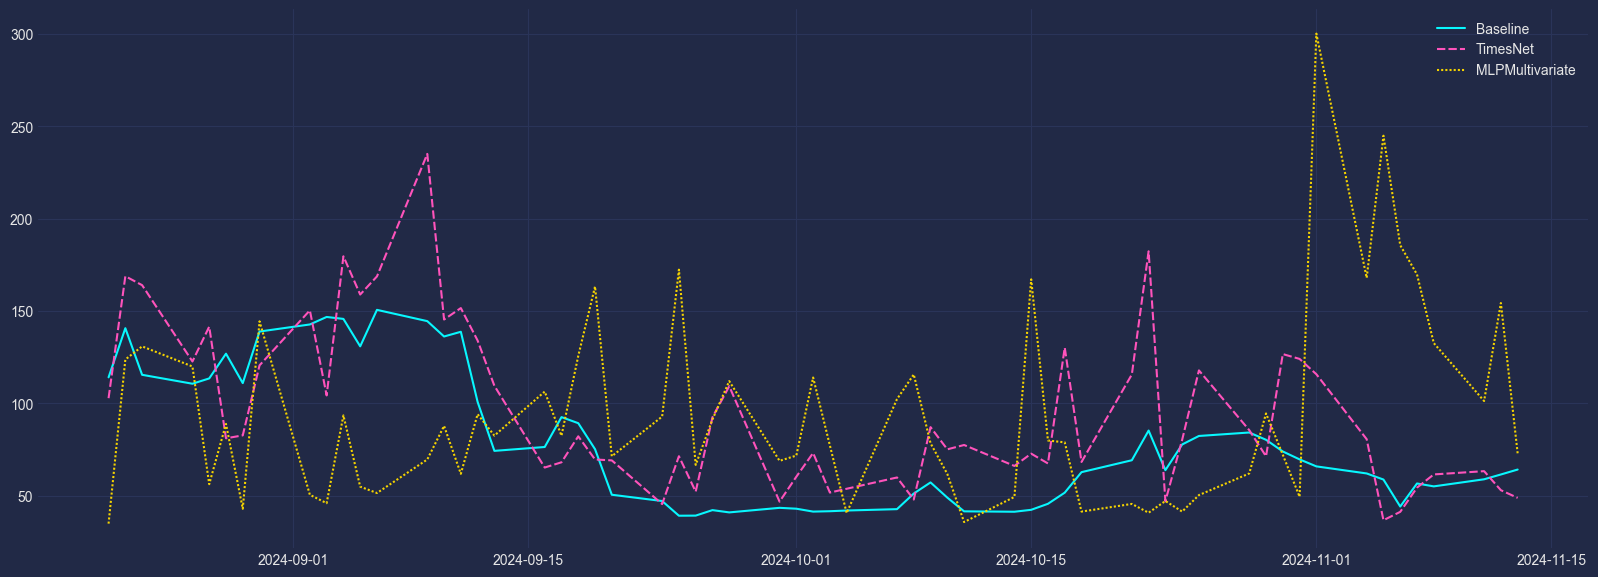

In [44]:
plt.figure(figsize=(20, 7))
sns.lineplot(metrics_df)
plt.show()

# SOFTS

In [46]:
def objective_softs(trial, dataset):
    params = {
        "input_size": trial.suggest_categorical(
            "input_size",
            [n_steps, n_steps * 2, n_steps * 3, n_steps * 4, n_steps * 5],
        ),
        "hidden_size": trial.suggest_categorical("hidden_size", [64, 128, 256, 512]),
        "d_core": trial.suggest_categorical("d_core", [64, 128, 256, 512]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "scaler_type": trial.suggest_categorical(
            "scaler_type", [None, "robust", "standard", "identity"]
        ),
        "max_steps": trial.suggest_categorical("max_steps", [500, 1000, 2000]),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128, 256]),
    }
    model = SOFTS(
        h=n_steps, n_series=1, hist_exog_list=exog_cols, random_seed=RND, **params
    )
    model.fit(dataset, val_size=n_steps, test_size=n_steps, random_seed=RND)
    return model.metrics["ptl/val_loss"]

In [47]:
index = []
errors = []
for i, h in enumerate(tqdm(range(-n_steps * 2, -n_steps + 1))):
    Y_ts = df[["ds", "unique_id", "y"]].copy()
    df_train = df.iloc[:h]
    Y_train = Y_ts.iloc[:h]
    if h + n_steps == 0:
        df_test = df.iloc[h:]
        Y_test = Y_ts.iloc[h:]
    else:
        df_test = df.iloc[h : h + n_steps]
        Y_test = Y_ts.iloc[h : h + n_steps]
    study_path = "study_softs_e.db"
    study = optuna.create_study(
        storage="sqlite:///{}".format(study_path),
        study_name=study_path,
        direction="minimize",
        load_if_exists=True,
    )
    dataset, *_ = TimeSeriesDataset.from_df(df_train)
    func = lambda x: objective_softs(x, dataset)
    study.optimize(
        func,
        n_trials=10 if i == 0 else 1,
        show_progress_bar=True,
        n_jobs=1,
        gc_after_trial=True,
    )
    dataset, *_ = TimeSeriesDataset.from_df(df_train)
    model = SOFTS(
        h=n_steps,
        n_series=1,
        hist_exog_list=exog_cols,
        random_seed=RND,
        enable_progress_bar=True,
        **study.best_params
    )
    model.fit(dataset=dataset, random_seed=RND)
    y_hat = model.predict(dataset=dataset, random_seed=RND)
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = np.mean(y_hat, axis=1)
    y_hat = y_hat.flatten()
    predicted_df = pd.DataFrame(
        {
            model.__class__.__name__: y_hat,
            "ds": Y_test.ds,
            "unique_id": Y_test.unique_id,
        }
    )
    index.append(Y_train.ds[-1])
    mae = mean_absolute_error(
        Y_test["y"].values, predicted_df[model.__class__.__name__]
    )
    errors.append(mae)
    torch.cuda.empty_cache()

  0%|                                                                                           | 0/61 [00:00<?, ?it/s][I 2025-02-06 23:38:43,276] A new study created in RDB with name: study_softs_e.db


  0%|          | 0/10 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
  0%|                                                                                           | 0/61 [00:10<?, ?it/s]

[I 2025-02-06 23:38:53,367] Trial 0 finished with value: 5.923508644104004 and parameters: {'input_size': 180, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.012305931464881228, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 128}. Best is trial 0 with value: 5.923508644104004.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
  0%|                                                                                           | 0/61 [00:20<?, ?it/s]

[I 2025-02-06 23:39:03,736] Trial 1 finished with value: 5.963009357452393 and parameters: {'input_size': 180, 'hidden_size': 128, 'd_core': 256, 'learning_rate': 0.03213565609557575, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 128}. Best is trial 0 with value: 5.923508644104004.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
  0%|                                                                                           | 0/61 [00:30<?, ?it/s]

[I 2025-02-06 23:39:13,944] Trial 2 finished with value: 2.855788230895996 and parameters: {'input_size': 180, 'hidden_size': 64, 'd_core': 256, 'learning_rate': 0.00015719600807338126, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 256}. Best is trial 2 with value: 2.855788230895996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=2000` reached.
  0%|                                                                                           | 0/61 [01:07<?, ?it/s]

[I 2025-02-06 23:39:51,129] Trial 3 finished with value: 127.89138793945312 and parameters: {'input_size': 120, 'hidden_size': 256, 'd_core': 256, 'learning_rate': 0.0005064155354247337, 'scaler_type': 'identity', 'max_steps': 2000, 'batch_size': 64}. Best is trial 2 with value: 2.855788230895996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=2000` reached.
  0%|                                                                                           | 0/61 [01:45<?, ?it/s]

[I 2025-02-06 23:40:28,859] Trial 4 finished with value: 4.4524312019348145 and parameters: {'input_size': 240, 'hidden_size': 256, 'd_core': 64, 'learning_rate': 0.0022014419051287473, 'scaler_type': 'standard', 'max_steps': 2000, 'batch_size': 32}. Best is trial 2 with value: 2.855788230895996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
  0%|                                                                                           | 0/61 [02:03<?, ?it/s]

[I 2025-02-06 23:40:47,134] Trial 5 finished with value: 140.63156127929688 and parameters: {'input_size': 180, 'hidden_size': 256, 'd_core': 64, 'learning_rate': 0.0010245088134257939, 'scaler_type': 'identity', 'max_steps': 1000, 'batch_size': 64}. Best is trial 2 with value: 2.855788230895996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
  0%|                                                                                           | 0/61 [02:22<?, ?it/s]

[I 2025-02-06 23:41:05,559] Trial 6 finished with value: 151.10910034179688 and parameters: {'input_size': 180, 'hidden_size': 128, 'd_core': 64, 'learning_rate': 0.0013576733977591433, 'scaler_type': None, 'max_steps': 1000, 'batch_size': 64}. Best is trial 2 with value: 2.855788230895996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=2000` reached.
  0%|                                                                                           | 0/61 [03:00<?, ?it/s]

[I 2025-02-06 23:41:44,003] Trial 7 finished with value: 2.8642828464508057 and parameters: {'input_size': 120, 'hidden_size': 512, 'd_core': 64, 'learning_rate': 0.023541989861714123, 'scaler_type': 'robust', 'max_steps': 2000, 'batch_size': 32}. Best is trial 2 with value: 2.855788230895996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=2000` reached.
  0%|                                                                                           | 0/61 [03:36<?, ?it/s]

[I 2025-02-06 23:42:19,667] Trial 8 finished with value: 169.8800811767578 and parameters: {'input_size': 240, 'hidden_size': 128, 'd_core': 256, 'learning_rate': 0.00011982493337679187, 'scaler_type': None, 'max_steps': 2000, 'batch_size': 64}. Best is trial 2 with value: 2.855788230895996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
  0%|                                                                                           | 0/61 [03:46<?, ?it/s]

[I 2025-02-06 23:42:29,243] Trial 9 finished with value: 227.519775390625 and parameters: {'input_size': 60, 'hidden_size': 128, 'd_core': 64, 'learning_rate': 0.013620694619870538, 'scaler_type': 'identity', 'max_steps': 500, 'batch_size': 256}. Best is trial 2 with value: 2.855788230895996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

  2%|█▎                                                                              | 1/61 [03:56<3:56:21, 236.35s/it][I 2025-02-06 23:42:39,554] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
  2%|█▎                                                                              | 1/61 [04:05<3:56:21, 236.35s/it]

[I 2025-02-06 23:42:49,118] Trial 10 finished with value: 3.0991804599761963 and parameters: {'input_size': 300, 'hidden_size': 64, 'd_core': 512, 'learning_rate': 0.00010157712284316765, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 256}. Best is trial 2 with value: 2.855788230895996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

  3%|██▌                                                                             | 2/61 [04:15<1:46:59, 108.80s/it][I 2025-02-06 23:42:59,071] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=2000` reached.
  3%|██▌                                                                             | 2/61 [04:52<1:46:59, 108.80s/it]

[I 2025-02-06 23:43:36,083] Trial 11 finished with value: 9.338382720947266 and parameters: {'input_size': 120, 'hidden_size': 512, 'd_core': 512, 'learning_rate': 0.07688668033460294, 'scaler_type': 'robust', 'max_steps': 2000, 'batch_size': 32}. Best is trial 2 with value: 2.855788230895996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

  5%|███▉                                                                             | 3/61 [05:02<1:17:52, 80.57s/it][I 2025-02-06 23:43:46,037] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
  5%|███▉                                                                             | 3/61 [05:12<1:17:52, 80.57s/it]

[I 2025-02-06 23:43:55,404] Trial 12 finished with value: 4.030082702636719 and parameters: {'input_size': 120, 'hidden_size': 512, 'd_core': 128, 'learning_rate': 0.0061758760886089885, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 256}. Best is trial 2 with value: 2.855788230895996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

  7%|█████▍                                                                             | 4/61 [05:22<53:36, 56.43s/it][I 2025-02-06 23:44:05,466] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=2000` reached.
  7%|█████▍                                                                             | 4/61 [05:59<53:36, 56.43s/it]

[I 2025-02-06 23:44:42,644] Trial 13 finished with value: 4.00081205368042 and parameters: {'input_size': 300, 'hidden_size': 64, 'd_core': 256, 'learning_rate': 0.00030136536051137845, 'scaler_type': 'robust', 'max_steps': 2000, 'batch_size': 32}. Best is trial 2 with value: 2.855788230895996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

  8%|██████▊                                                                            | 5/61 [06:09<49:30, 53.05s/it][I 2025-02-06 23:44:52,530] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
  8%|██████▊                                                                            | 5/61 [06:27<49:30, 53.05s/it]

[I 2025-02-06 23:45:10,793] Trial 14 finished with value: 5.3477253913879395 and parameters: {'input_size': 60, 'hidden_size': 64, 'd_core': 64, 'learning_rate': 0.08828521829563518, 'scaler_type': 'standard', 'max_steps': 1000, 'batch_size': 32}. Best is trial 2 with value: 2.855788230895996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 10%|████████▏                                                                          | 6/61 [06:37<40:52, 44.60s/it][I 2025-02-06 23:45:20,718] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 10%|████████▏                                                                          | 6/61 [06:47<40:52, 44.60s/it]

[I 2025-02-06 23:45:30,260] Trial 15 finished with value: 9.692462921142578 and parameters: {'input_size': 120, 'hidden_size': 512, 'd_core': 256, 'learning_rate': 0.00489866950761597, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 256}. Best is trial 2 with value: 2.855788230895996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 11%|█████████▌                                                                         | 7/61 [06:56<32:43, 36.36s/it][I 2025-02-06 23:45:40,110] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=2000` reached.
 11%|█████████▌                                                                         | 7/61 [07:34<32:43, 36.36s/it]

[I 2025-02-06 23:46:17,254] Trial 16 finished with value: 4.200778484344482 and parameters: {'input_size': 180, 'hidden_size': 64, 'd_core': 512, 'learning_rate': 0.021566817052882138, 'scaler_type': 'standard', 'max_steps': 2000, 'batch_size': 32}. Best is trial 2 with value: 2.855788230895996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 13%|██████████▉                                                                        | 8/61 [07:44<35:18, 39.97s/it][I 2025-02-06 23:46:27,816] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=2000` reached.
 13%|██████████▉                                                                        | 8/61 [08:20<35:18, 39.97s/it]

[I 2025-02-06 23:47:03,745] Trial 17 finished with value: 103.23590850830078 and parameters: {'input_size': 120, 'hidden_size': 512, 'd_core': 128, 'learning_rate': 0.0003312022492468098, 'scaler_type': None, 'max_steps': 2000, 'batch_size': 256}. Best is trial 2 with value: 2.855788230895996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 15%|████████████▏                                                                      | 9/61 [08:30<36:19, 41.91s/it][I 2025-02-06 23:47:13,978] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 15%|████████████▏                                                                      | 9/61 [08:40<36:19, 41.91s/it]

[I 2025-02-06 23:47:23,712] Trial 18 finished with value: 4.3713531494140625 and parameters: {'input_size': 300, 'hidden_size': 512, 'd_core': 256, 'learning_rate': 0.034578441049428074, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128}. Best is trial 2 with value: 2.855788230895996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 16%|█████████████▍                                                                    | 10/61 [08:50<29:55, 35.21s/it][I 2025-02-06 23:47:34,195] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 16%|█████████████▍                                                                    | 10/61 [09:10<29:55, 35.21s/it]

[I 2025-02-06 23:47:53,370] Trial 19 finished with value: 4.013899803161621 and parameters: {'input_size': 240, 'hidden_size': 64, 'd_core': 64, 'learning_rate': 0.004016399812882964, 'scaler_type': 'robust', 'max_steps': 1000, 'batch_size': 256}. Best is trial 2 with value: 2.855788230895996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 18%|██████████████▊                                                                   | 11/61 [09:20<27:48, 33.37s/it][I 2025-02-06 23:48:03,401] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=2000` reached.
 18%|██████████████▊                                                                   | 11/61 [09:56<27:48, 33.37s/it]

[I 2025-02-06 23:48:39,594] Trial 20 finished with value: 4.591170310974121 and parameters: {'input_size': 60, 'hidden_size': 512, 'd_core': 256, 'learning_rate': 0.009612300271687392, 'scaler_type': 'standard', 'max_steps': 2000, 'batch_size': 32}. Best is trial 2 with value: 2.855788230895996.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 20%|████████████████▏                                                                 | 12/61 [10:06<30:23, 37.22s/it][I 2025-02-06 23:48:49,431] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 20%|████████████████▏                                                                 | 12/61 [10:15<30:23, 37.22s/it]

[I 2025-02-06 23:48:59,047] Trial 21 finished with value: 2.5101420879364014 and parameters: {'input_size': 300, 'hidden_size': 64, 'd_core': 512, 'learning_rate': 0.00013022302481357928, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 256}. Best is trial 21 with value: 2.5101420879364014.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 21%|█████████████████▍                                                                | 13/61 [10:25<25:31, 31.91s/it][I 2025-02-06 23:49:09,126] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 21%|█████████████████▍                                                                | 13/61 [10:35<25:31, 31.91s/it]

[I 2025-02-06 23:49:18,529] Trial 22 finished with value: 2.389389753341675 and parameters: {'input_size': 300, 'hidden_size': 64, 'd_core': 512, 'learning_rate': 0.00023345026277495353, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 256}. Best is trial 22 with value: 2.389389753341675.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 23%|██████████████████▊                                                               | 14/61 [10:45<22:04, 28.19s/it][I 2025-02-06 23:49:28,710] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 23%|██████████████████▊                                                               | 14/61 [10:55<22:04, 28.19s/it]

[I 2025-02-06 23:49:38,480] Trial 23 finished with value: 2.300772190093994 and parameters: {'input_size': 300, 'hidden_size': 64, 'd_core': 512, 'learning_rate': 0.0001944811807027557, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 256}. Best is trial 23 with value: 2.300772190093994.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 25%|████████████████████▏                                                             | 15/61 [11:05<19:48, 25.83s/it][I 2025-02-06 23:49:49,076] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 25%|████████████████████▏                                                             | 15/61 [11:15<19:48, 25.83s/it]

[I 2025-02-06 23:49:59,095] Trial 24 finished with value: 2.782862663269043 and parameters: {'input_size': 300, 'hidden_size': 64, 'd_core': 512, 'learning_rate': 0.00019761733509060314, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 256}. Best is trial 23 with value: 2.300772190093994.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 26%|█████████████████████▌                                                            | 16/61 [11:26<18:12, 24.28s/it][I 2025-02-06 23:50:09,745] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 26%|█████████████████████▌                                                            | 16/61 [11:36<18:12, 24.28s/it]

[I 2025-02-06 23:50:19,841] Trial 25 finished with value: 2.508671522140503 and parameters: {'input_size': 300, 'hidden_size': 64, 'd_core': 512, 'learning_rate': 0.0006568094657461942, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 256}. Best is trial 23 with value: 2.300772190093994.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 28%|██████████████████████▊                                                           | 17/61 [11:47<17:00, 23.20s/it][I 2025-02-06 23:50:30,452] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 28%|██████████████████████▊                                                           | 17/61 [11:57<17:00, 23.20s/it]

[I 2025-02-06 23:50:40,375] Trial 26 finished with value: 2.562891721725464 and parameters: {'input_size': 300, 'hidden_size': 64, 'd_core': 512, 'learning_rate': 0.0006131143313971084, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 256}. Best is trial 23 with value: 2.300772190093994.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 30%|████████████████████████▏                                                         | 18/61 [12:07<15:55, 22.22s/it][I 2025-02-06 23:50:50,378] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 30%|████████████████████████▏                                                         | 18/61 [12:16<15:55, 22.22s/it]

[I 2025-02-06 23:50:59,801] Trial 27 finished with value: 2.446403980255127 and parameters: {'input_size': 300, 'hidden_size': 64, 'd_core': 512, 'learning_rate': 0.0007629144164554556, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 256}. Best is trial 23 with value: 2.300772190093994.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 31%|█████████████████████████▌                                                        | 19/61 [12:26<14:58, 21.39s/it][I 2025-02-06 23:51:09,839] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 31%|█████████████████████████▌                                                        | 19/61 [12:36<14:58, 21.39s/it]

[I 2025-02-06 23:51:19,574] Trial 28 finished with value: 2.0039234161376953 and parameters: {'input_size': 300, 'hidden_size': 64, 'd_core': 512, 'learning_rate': 0.0002850108990107918, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 256}. Best is trial 28 with value: 2.0039234161376953.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 33%|██████████████████████████▉                                                       | 20/61 [12:46<14:18, 20.94s/it][I 2025-02-06 23:51:29,720] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 33%|██████████████████████████▉                                                       | 20/61 [12:56<14:18, 20.94s/it]

[I 2025-02-06 23:51:39,333] Trial 29 finished with value: 1.747186303138733 and parameters: {'input_size': 300, 'hidden_size': 64, 'd_core': 512, 'learning_rate': 0.00026312085279993976, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128}. Best is trial 29 with value: 1.747186303138733.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 34%|████████████████████████████▏                                                     | 21/61 [13:06<13:41, 20.53s/it][I 2025-02-06 23:51:49,314] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 34%|████████████████████████████▏                                                     | 21/61 [13:15<13:41, 20.53s/it]

[I 2025-02-06 23:51:58,582] Trial 30 finished with value: 173.69097900390625 and parameters: {'input_size': 300, 'hidden_size': 64, 'd_core': 512, 'learning_rate': 0.0018389201063218437, 'scaler_type': None, 'max_steps': 500, 'batch_size': 128}. Best is trial 29 with value: 1.747186303138733.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 36%|█████████████████████████████▌                                                    | 22/61 [13:25<13:07, 20.19s/it][I 2025-02-06 23:52:08,716] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 36%|█████████████████████████████▌                                                    | 22/61 [13:35<13:07, 20.19s/it]

[I 2025-02-06 23:52:18,266] Trial 31 finished with value: 1.5553128719329834 and parameters: {'input_size': 300, 'hidden_size': 64, 'd_core': 512, 'learning_rate': 0.00033317244580355, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128}. Best is trial 31 with value: 1.5553128719329834.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 38%|██████████████████████████████▉                                                   | 23/61 [13:45<12:40, 20.00s/it][I 2025-02-06 23:52:28,268] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 38%|██████████████████████████████▉                                                   | 23/61 [13:54<12:40, 20.00s/it]

[I 2025-02-06 23:52:37,829] Trial 32 finished with value: 1.410685420036316 and parameters: {'input_size': 300, 'hidden_size': 64, 'd_core': 512, 'learning_rate': 0.0003649319113461077, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128}. Best is trial 32 with value: 1.410685420036316.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 39%|████████████████████████████████▎                                                 | 24/61 [14:04<12:14, 19.84s/it][I 2025-02-06 23:52:47,741] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 39%|████████████████████████████████▎                                                 | 24/61 [14:13<12:14, 19.84s/it]

[I 2025-02-06 23:52:56,849] Trial 33 finished with value: 1.3186028003692627 and parameters: {'input_size': 300, 'hidden_size': 64, 'd_core': 512, 'learning_rate': 0.00036447245771692596, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128}. Best is trial 33 with value: 1.3186028003692627.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 41%|█████████████████████████████████▌                                                | 25/61 [14:23<11:46, 19.62s/it][I 2025-02-06 23:53:06,857] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 41%|█████████████████████████████████▌                                                | 25/61 [14:32<11:46, 19.62s/it]

[I 2025-02-06 23:53:15,922] Trial 34 finished with value: 125.15428161621094 and parameters: {'input_size': 300, 'hidden_size': 64, 'd_core': 512, 'learning_rate': 0.00040753850039727525, 'scaler_type': 'identity', 'max_steps': 500, 'batch_size': 128}. Best is trial 33 with value: 1.3186028003692627.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 43%|██████████████████████████████████▉                                               | 26/61 [14:42<11:19, 19.43s/it][I 2025-02-06 23:53:25,825] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 43%|██████████████████████████████████▉                                               | 26/61 [14:52<11:19, 19.43s/it]

[I 2025-02-06 23:53:35,394] Trial 35 finished with value: 1.1806385517120361 and parameters: {'input_size': 300, 'hidden_size': 64, 'd_core': 128, 'learning_rate': 0.0004770927101538091, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128}. Best is trial 35 with value: 1.1806385517120361.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 44%|████████████████████████████████████▎                                             | 27/61 [15:02<11:02, 19.49s/it][I 2025-02-06 23:53:45,468] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 44%|████████████████████████████████████▎                                             | 27/61 [15:11<11:02, 19.49s/it]

[I 2025-02-06 23:53:54,877] Trial 36 finished with value: 0.6016183495521545 and parameters: {'input_size': 300, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.0010218572729889003, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128}. Best is trial 36 with value: 0.6016183495521545.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 46%|█████████████████████████████████████▋                                            | 28/61 [15:21<10:44, 19.52s/it][I 2025-02-06 23:54:05,061] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 46%|█████████████████████████████████████▋                                            | 28/61 [15:31<10:44, 19.52s/it]

[I 2025-02-06 23:54:14,365] Trial 37 finished with value: 0.33600014448165894 and parameters: {'input_size': 240, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.0010398722109400617, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 48%|██████████████████████████████████████▉                                           | 29/61 [15:41<10:21, 19.43s/it][I 2025-02-06 23:54:24,282] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 48%|██████████████████████████████████████▉                                           | 29/61 [15:58<10:21, 19.43s/it]

[I 2025-02-06 23:54:42,136] Trial 38 finished with value: 65.96415710449219 and parameters: {'input_size': 240, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.0011773038000955469, 'scaler_type': 'identity', 'max_steps': 1000, 'batch_size': 128}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 49%|████████████████████████████████████████▎                                         | 30/61 [16:08<11:19, 21.93s/it][I 2025-02-06 23:54:52,053] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 49%|████████████████████████████████████████▎                                         | 30/61 [16:18<11:19, 21.93s/it]

[I 2025-02-06 23:55:01,477] Trial 39 finished with value: 2.7776410579681396 and parameters: {'input_size': 240, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.0028249740717343204, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 51%|█████████████████████████████████████████▋                                        | 31/61 [16:28<10:34, 21.17s/it][I 2025-02-06 23:55:11,425] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 51%|█████████████████████████████████████████▋                                        | 31/61 [16:37<10:34, 21.17s/it]

[I 2025-02-06 23:55:20,488] Trial 40 finished with value: 80.9188003540039 and parameters: {'input_size': 240, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.0009053913449986163, 'scaler_type': None, 'max_steps': 500, 'batch_size': 128}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 52%|███████████████████████████████████████████                                       | 32/61 [16:47<09:53, 20.45s/it][I 2025-02-06 23:55:30,220] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 52%|███████████████████████████████████████████                                       | 32/61 [16:56<09:53, 20.45s/it]

[I 2025-02-06 23:55:39,360] Trial 41 finished with value: 0.8285561800003052 and parameters: {'input_size': 240, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.00046896393280867, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 54%|████████████████████████████████████████████▎                                     | 33/61 [17:06<09:21, 20.07s/it][I 2025-02-06 23:55:49,387] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 54%|████████████████████████████████████████████▎                                     | 33/61 [17:16<09:21, 20.07s/it]

[I 2025-02-06 23:55:59,470] Trial 42 finished with value: 0.33841168880462646 and parameters: {'input_size': 240, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.0017763588312143792, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 56%|█████████████████████████████████████████████▋                                    | 34/61 [17:26<09:07, 20.26s/it][I 2025-02-06 23:56:10,110] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 56%|█████████████████████████████████████████████▋                                    | 34/61 [17:36<09:07, 20.26s/it]

[I 2025-02-06 23:56:20,023] Trial 43 finished with value: 0.9094251394271851 and parameters: {'input_size': 240, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.0016115891799768371, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 57%|███████████████████████████████████████████████                                   | 35/61 [17:47<08:48, 20.32s/it][I 2025-02-06 23:56:30,569] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 57%|███████████████████████████████████████████████                                   | 35/61 [17:57<08:48, 20.32s/it]

[I 2025-02-06 23:56:40,471] Trial 44 finished with value: 0.9121814966201782 and parameters: {'input_size': 240, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.0016771230522722002, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 128}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 59%|████████████████████████████████████████████████▍                                 | 36/61 [18:08<08:30, 20.42s/it][I 2025-02-06 23:56:51,204] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 59%|████████████████████████████████████████████████▍                                 | 36/61 [18:26<08:30, 20.42s/it]

[I 2025-02-06 23:57:09,457] Trial 45 finished with value: 183.0607147216797 and parameters: {'input_size': 240, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.0024894661417785113, 'scaler_type': 'identity', 'max_steps': 1000, 'batch_size': 128}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 61%|█████████████████████████████████████████████████▋                                | 37/61 [18:36<09:05, 22.74s/it][I 2025-02-06 23:57:19,354] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 61%|█████████████████████████████████████████████████▋                                | 37/61 [18:46<09:05, 22.74s/it]

[I 2025-02-06 23:57:29,183] Trial 46 finished with value: 0.43964913487434387 and parameters: {'input_size': 240, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.0014194167787739023, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 62%|███████████████████████████████████████████████████                               | 38/61 [18:56<08:25, 21.98s/it][I 2025-02-06 23:57:39,556] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 62%|███████████████████████████████████████████████████                               | 38/61 [19:06<08:25, 21.98s/it]

[I 2025-02-06 23:57:49,200] Trial 47 finished with value: 0.48640498518943787 and parameters: {'input_size': 240, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.0011232237912200515, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 64%|████████████████████████████████████████████████████▍                             | 39/61 [19:15<07:47, 21.26s/it][I 2025-02-06 23:57:59,159] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 64%|████████████████████████████████████████████████████▍                             | 39/61 [19:25<07:47, 21.26s/it]

[I 2025-02-06 23:58:08,671] Trial 48 finished with value: 0.3726138770580292 and parameters: {'input_size': 240, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.001173492238463482, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 66%|█████████████████████████████████████████████████████▊                            | 40/61 [19:35<07:15, 20.73s/it][I 2025-02-06 23:58:18,637] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 66%|█████████████████████████████████████████████████████▊                            | 40/61 [19:45<07:15, 20.73s/it]

[I 2025-02-06 23:58:28,264] Trial 49 finished with value: 1.6367167234420776 and parameters: {'input_size': 240, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.0012754957005664726, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 64}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 67%|███████████████████████████████████████████████████████                           | 41/61 [19:54<06:47, 20.36s/it][I 2025-02-06 23:58:38,135] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 67%|███████████████████████████████████████████████████████                           | 41/61 [20:13<06:47, 20.36s/it]

[I 2025-02-06 23:58:56,702] Trial 50 finished with value: 255.1576385498047 and parameters: {'input_size': 240, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.0032800350388100703, 'scaler_type': None, 'max_steps': 1000, 'batch_size': 64}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 69%|████████████████████████████████████████████████████████▍                         | 42/61 [20:23<07:13, 22.81s/it][I 2025-02-06 23:59:06,653] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 69%|████████████████████████████████████████████████████████▍                         | 42/61 [20:33<07:13, 22.81s/it]

[I 2025-02-06 23:59:16,472] Trial 51 finished with value: 0.7954368591308594 and parameters: {'input_size': 240, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.000911861374618391, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 70%|█████████████████████████████████████████████████████████▊                        | 43/61 [20:43<06:34, 21.89s/it][I 2025-02-06 23:59:26,412] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 70%|█████████████████████████████████████████████████████████▊                        | 43/61 [20:53<06:34, 21.89s/it]

[I 2025-02-06 23:59:36,402] Trial 52 finished with value: 2.3201308250427246 and parameters: {'input_size': 240, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.002291236640446828, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 72%|███████████████████████████████████████████████████████████▏                      | 44/61 [21:03<06:03, 21.37s/it][I 2025-02-06 23:59:46,570] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 72%|███████████████████████████████████████████████████████████▏                      | 44/61 [21:13<06:03, 21.37s/it]

[I 2025-02-06 23:59:56,320] Trial 53 finished with value: 1.0108212232589722 and parameters: {'input_size': 180, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.0010484219215421949, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 74%|████████████████████████████████████████████████████████████▍                     | 45/61 [21:23<05:34, 20.92s/it][I 2025-02-07 00:00:06,444] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 74%|████████████████████████████████████████████████████████████▍                     | 45/61 [21:32<05:34, 20.92s/it]

[I 2025-02-07 00:00:15,899] Trial 54 finished with value: 0.6482473015785217 and parameters: {'input_size': 240, 'hidden_size': 128, 'd_core': 128, 'learning_rate': 0.0013666035597030082, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 75%|█████████████████████████████████████████████████████████████▊                    | 46/61 [21:43<05:09, 20.64s/it][I 2025-02-07 00:00:26,435] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 75%|█████████████████████████████████████████████████████████████▊                    | 46/61 [21:52<05:09, 20.64s/it]

[I 2025-02-07 00:00:36,099] Trial 55 finished with value: 1.1747373342514038 and parameters: {'input_size': 240, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.0019411284141121002, 'scaler_type': 'standard', 'max_steps': 500, 'batch_size': 64}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 77%|███████████████████████████████████████████████████████████████▏                  | 47/61 [22:03<04:45, 20.42s/it][I 2025-02-07 00:00:46,343] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=2000` reached.
 77%|███████████████████████████████████████████████████████████████▏                  | 47/61 [22:40<04:45, 20.42s/it]

[I 2025-02-07 00:01:23,632] Trial 56 finished with value: 1.0626362562179565 and parameters: {'input_size': 240, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.005961836028597604, 'scaler_type': 'standard', 'max_steps': 2000, 'batch_size': 64}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 79%|████████████████████████████████████████████████████████████████▌                 | 48/61 [22:50<06:12, 28.63s/it][I 2025-02-07 00:01:34,128] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 79%|████████████████████████████████████████████████████████████████▌                 | 48/61 [23:00<06:12, 28.63s/it]

[I 2025-02-07 00:01:44,100] Trial 57 finished with value: 0.3623742461204529 and parameters: {'input_size': 60, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.0006156858359151134, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 64}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 80%|█████████████████████████████████████████████████████████████████▊                | 49/61 [23:11<05:13, 26.14s/it][I 2025-02-07 00:01:54,448] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 80%|█████████████████████████████████████████████████████████████████▊                | 49/61 [23:20<05:13, 26.14s/it]

[I 2025-02-07 00:02:04,166] Trial 58 finished with value: 0.47872766852378845 and parameters: {'input_size': 60, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.0007044798462688546, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 64}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 82%|███████████████████████████████████████████████████████████████████▏              | 50/61 [23:31<04:27, 24.31s/it][I 2025-02-07 00:02:14,486] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 82%|███████████████████████████████████████████████████████████████████▏              | 50/61 [23:41<04:27, 24.31s/it]

[I 2025-02-07 00:02:24,413] Trial 59 finished with value: 0.6135510802268982 and parameters: {'input_size': 60, 'hidden_size': 128, 'd_core': 64, 'learning_rate': 0.0006600859165136186, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 64}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 84%|████████████████████████████████████████████████████████████████████▌             | 51/61 [23:51<03:50, 23.01s/it][I 2025-02-07 00:02:34,469] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=1000` reached.
 84%|████████████████████████████████████████████████████████████████████▌             | 51/61 [24:09<03:50, 23.01s/it]

[I 2025-02-07 00:02:52,990] Trial 60 finished with value: 0.5534356832504272 and parameters: {'input_size': 60, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.0008113611764077132, 'scaler_type': 'robust', 'max_steps': 1000, 'batch_size': 64}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 85%|█████████████████████████████████████████████████████████████████████▉            | 52/61 [24:19<03:41, 24.63s/it][I 2025-02-07 00:03:02,888] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 85%|█████████████████████████████████████████████████████████████████████▉            | 52/61 [24:29<03:41, 24.63s/it]

[I 2025-02-07 00:03:12,258] Trial 61 finished with value: 0.5568504929542542 and parameters: {'input_size': 60, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.0005744325907868113, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 64}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 87%|███████████████████████████████████████████████████████████████████████▏          | 53/61 [24:39<03:04, 23.06s/it][I 2025-02-07 00:03:22,294] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 87%|███████████████████████████████████████████████████████████████████████▏          | 53/61 [24:48<03:04, 23.06s/it]

[I 2025-02-07 00:03:32,013] Trial 62 finished with value: 0.5379704833030701 and parameters: {'input_size': 60, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.0014686958203134726, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 64}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 89%|████████████████████████████████████████████████████████████████████████▌         | 54/61 [24:59<02:34, 22.13s/it][I 2025-02-07 00:03:42,238] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 89%|████████████████████████████████████████████████████████████████████████▌         | 54/61 [25:08<02:34, 22.13s/it]

[I 2025-02-07 00:03:52,079] Trial 63 finished with value: 0.8925348520278931 and parameters: {'input_size': 60, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.0007275604033196963, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 64}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 90%|█████████████████████████████████████████████████████████████████████████▉        | 55/61 [25:18<02:08, 21.41s/it][I 2025-02-07 00:04:01,986] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 90%|█████████████████████████████████████████████████████████████████████████▉        | 55/61 [25:28<02:08, 21.41s/it]

[I 2025-02-07 00:04:11,918] Trial 64 finished with value: 0.6412705183029175 and parameters: {'input_size': 60, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.0012463426200459888, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 64}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 92%|███████████████████████████████████████████████████████████████████████████▎      | 56/61 [25:38<01:44, 20.89s/it][I 2025-02-07 00:04:21,665] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=2000` reached.
 92%|███████████████████████████████████████████████████████████████████████████▎      | 56/61 [26:16<01:44, 20.89s/it]

[I 2025-02-07 00:04:59,603] Trial 65 finished with value: 3.7682955265045166 and parameters: {'input_size': 180, 'hidden_size': 256, 'd_core': 256, 'learning_rate': 0.0020238381850485776, 'scaler_type': 'robust', 'max_steps': 2000, 'batch_size': 64}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 93%|████████████████████████████████████████████████████████████████████████████▌     | 57/61 [26:26<01:56, 29.03s/it][I 2025-02-07 00:05:09,666] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 93%|████████████████████████████████████████████████████████████████████████████▌     | 57/61 [26:36<01:56, 29.03s/it]

[I 2025-02-07 00:05:19,605] Trial 66 finished with value: 2.491004467010498 and parameters: {'input_size': 120, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.0030821437564468386, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 64}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 58/61 [26:46<01:18, 26.31s/it][I 2025-02-07 00:05:29,642] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 95%|█████████████████████████████████████████████████████████████████████████████▉    | 58/61 [26:55<01:18, 26.31s/it]

[I 2025-02-07 00:05:39,103] Trial 67 finished with value: 255.54486083984375 and parameters: {'input_size': 240, 'hidden_size': 256, 'd_core': 128, 'learning_rate': 0.004012209158572978, 'scaler_type': 'identity', 'max_steps': 500, 'batch_size': 64}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 97%|███████████████████████████████████████████████████████████████████████████████▎  | 59/61 [27:05<00:48, 24.23s/it][I 2025-02-07 00:05:49,018] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 97%|███████████████████████████████████████████████████████████████████████████████▎  | 59/61 [27:15<00:48, 24.23s/it]

[I 2025-02-07 00:05:58,964] Trial 68 finished with value: 1.2370926141738892 and parameters: {'input_size': 60, 'hidden_size': 256, 'd_core': 64, 'learning_rate': 0.0005480859387937472, 'scaler_type': 'robust', 'max_steps': 500, 'batch_size': 32}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

 98%|████████████████████████████████████████████████████████████████████████████████▋ | 60/61 [27:26<00:23, 23.05s/it][I 2025-02-07 00:06:09,312] Using an existing study with name 'study_softs_e.db' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
 98%|████████████████████████████████████████████████████████████████████████████████▋ | 60/61 [27:35<00:23, 23.05s/it]

[I 2025-02-07 00:06:19,048] Trial 69 finished with value: 94.3862533569336 and parameters: {'input_size': 240, 'hidden_size': 128, 'd_core': 128, 'learning_rate': 0.00101745875945723, 'scaler_type': None, 'max_steps': 500, 'batch_size': 64}. Best is trial 37 with value: 0.33600014448165894.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [27:45<00:00, 27.31s/it]


In [48]:
metrics_df["SOFTS"] = errors

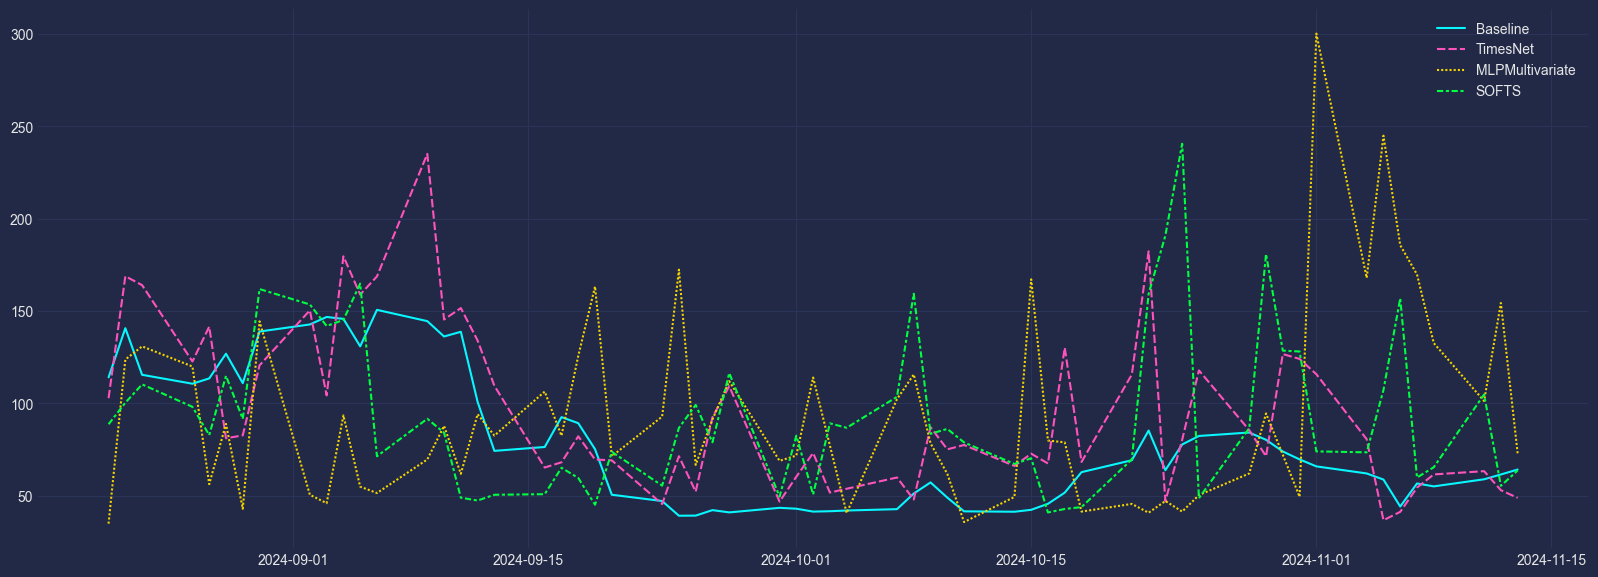

In [49]:
plt.figure(figsize=(20, 7))
sns.lineplot(metrics_df)
plt.show()

# TimeLLM

In [61]:
prompt_prefix = f"The dataset contains data on daily price of gold of exogenous columns. There is no visible seasonality. Predict price for next {n_steps} working days."

In [62]:
def objective_timellm(trial, dataset):
    params = {
        "input_size": trial.suggest_categorical(
            "input_size",
            [n_steps, n_steps * 2],
        ),
        "patch_len": trial.suggest_categorical("patch_len", [8, 16]),
        "stride": trial.suggest_categorical("stride", [4, 8]),
        "d_model": trial.suggest_categorical("d_model", [16, 32]),
        "top_k": trial.suggest_categorical("top_k", [4, 5, 6]),
        "d_ff": trial.suggest_categorical("d_ff", [16, 32, 64]),
        "dropout": trial.suggest_float("dropout", 1e-2, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 1e-1, log=True),
        "scaler_type": trial.suggest_categorical(
            "scaler_type", [None, "robust", "standard", "identity"]
        ),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64]),
        "windows_batch_size": trial.suggest_categorical("windows_batch_size", [32, 64]),
    }
    print(params)
    model = TimeLLM(
        h=n_steps,
        prompt_prefix=prompt_prefix,
        random_seed=RND,
        max_steps=100,
        dataloader_kwargs={"num_workers": 24, "persistent_workers": True},
        **params
    )
    model.fit(dataset, val_size=n_steps, test_size=n_steps, random_seed=RND)
    torch.cuda.empty_cache()
    return model.metrics["ptl/val_loss"]

In [65]:
torch.cuda.empty_cache()

In [66]:
index = []
errors = []
for i, h in enumerate(tqdm(range(-n_steps * 2, -n_steps + 1))):
    Y_ts = df[["ds", "unique_id", "y"]].copy()
    df_train = df.iloc[:h]
    Y_train = Y_ts.iloc[:h]
    if h + n_steps == 0:
        df_test = df.iloc[h:]
        Y_test = Y_ts.iloc[h:]
    else:
        df_test = df.iloc[h : h + n_steps]
        Y_test = Y_ts.iloc[h : h + n_steps]
    study_path = "study_tilellm_e5.db"
    study = optuna.create_study(
        storage="sqlite:///{}".format(study_path),
        study_name=study_path,
        direction="minimize",
        load_if_exists=True,
    )
    dataset, *_ = TimeSeriesDataset.from_df(df_train)
    func = lambda x: objective_timellm(x, dataset)
    study.optimize(
        func,
        n_trials=10 if i == 0 else 1,
        show_progress_bar=True,
        n_jobs=1,
        gc_after_trial=True,
    )
    dataset, *_ = TimeSeriesDataset.from_df(df_train)
    model = TimeLLM(
        h=n_steps,
        prompt_prefix=prompt_prefix,
        random_seed=RND,
        max_steps=200,
        dataloader_kwargs={"num_workers": 24, "persistent_workers": True},
        **study.best_params
    )
    model.fit(dataset=dataset, random_seed=RND)
    y_hat = model.predict(dataset=dataset, random_seed=RND)
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = np.mean(y_hat, axis=1)
    y_hat = y_hat.flatten()
    predicted_df = pd.DataFrame(
        {
            model.__class__.__name__: y_hat,
            "ds": Y_test.ds,
            "unique_id": Y_test.unique_id,
        }
    )
    index.append(Y_train.ds[-1])
    mae = mean_absolute_error(
        Y_test["y"].values, predicted_df[model.__class__.__name__]
    )
    errors.append(mae)
    print(errors)
    torch.cuda.empty_cache()


  0%|                                                                                           | 0/61 [00:00<?, ?it/s][I 2025-02-07 01:10:36,856] A new study created in RDB with name: study_tilellm_e5.db


  0%|          | 0/10 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 32, 'dropout': 0.030484262496266, 'learning_rate': 0.013454471929687163, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
  0%|                                                                                           | 0/61 [00:39<?, ?it/s]

[I 2025-02-07 01:11:16,213] Trial 0 finished with value: 224.11058044433594 and parameters: {'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 32, 'dropout': 0.030484262496266, 'learning_rate': 0.013454471929687163, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 0 with value: 224.11058044433594.


Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 4, 'd_ff': 16, 'dropout': 0.28676293563243926, 'learning_rate': 0.019382675085743546, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
  0%|                                                                                           | 0/61 [01:17<?, ?it/s]

[I 2025-02-07 01:11:54,256] Trial 1 finished with value: 242.07040405273438 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 4, 'd_ff': 16, 'dropout': 0.28676293563243926, 'learning_rate': 0.019382675085743546, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 0 with value: 224.11058044433594.


Seed set to 0


{'input_size': 60, 'patch_len': 8, 'stride': 4, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.41575042825066183, 'learning_rate': 0.030446650269480863, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
  0%|                                                                                           | 0/61 [02:11<?, ?it/s]

[I 2025-02-07 01:12:48,480] Trial 2 finished with value: 237.57904052734375 and parameters: {'input_size': 60, 'patch_len': 8, 'stride': 4, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.41575042825066183, 'learning_rate': 0.030446650269480863, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 0 with value: 224.11058044433594.


Seed set to 0


{'input_size': 120, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 4, 'd_ff': 64, 'dropout': 0.013263979574535201, 'learning_rate': 0.04510582761412844, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
  0%|                                                                                           | 0/61 [02:50<?, ?it/s]

[I 2025-02-07 01:13:27,324] Trial 3 finished with value: 178.19668579101562 and parameters: {'input_size': 120, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 4, 'd_ff': 64, 'dropout': 0.013263979574535201, 'learning_rate': 0.04510582761412844, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 3 with value: 178.19668579101562.


Seed set to 0


{'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.6987105566001457, 'learning_rate': 0.060081082657205076, 'scaler_type': 'identity', 'batch_size': 64, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
  0%|                                                                                           | 0/61 [03:43<?, ?it/s]

[I 2025-02-07 01:14:19,976] Trial 4 finished with value: 268.9584655761719 and parameters: {'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.6987105566001457, 'learning_rate': 0.060081082657205076, 'scaler_type': 'identity', 'batch_size': 64, 'windows_batch_size': 64}. Best is trial 3 with value: 178.19668579101562.


Seed set to 0


{'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 4, 'd_ff': 64, 'dropout': 0.6949786271149785, 'learning_rate': 0.047937455878665755, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
  0%|                                                                                           | 0/61 [04:21<?, ?it/s]

[I 2025-02-07 01:14:58,640] Trial 5 finished with value: 276.60357666015625 and parameters: {'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 4, 'd_ff': 64, 'dropout': 0.6949786271149785, 'learning_rate': 0.047937455878665755, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 3 with value: 178.19668579101562.


Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 4, 'd_ff': 32, 'dropout': 0.9643154234445219, 'learning_rate': 0.010495897919509214, 'scaler_type': 'identity', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
  0%|                                                                                           | 0/61 [05:00<?, ?it/s]

[I 2025-02-07 01:15:36,850] Trial 6 finished with value: 255.66397094726562 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 4, 'd_ff': 32, 'dropout': 0.9643154234445219, 'learning_rate': 0.010495897919509214, 'scaler_type': 'identity', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 3 with value: 178.19668579101562.


Seed set to 0


{'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 5, 'd_ff': 32, 'dropout': 0.45214765602366064, 'learning_rate': 0.03947983329855613, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
  0%|                                                                                           | 0/61 [05:51<?, ?it/s]

[I 2025-02-07 01:16:28,043] Trial 7 finished with value: 246.395263671875 and parameters: {'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 5, 'd_ff': 32, 'dropout': 0.45214765602366064, 'learning_rate': 0.03947983329855613, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 3 with value: 178.19668579101562.


Seed set to 0


{'input_size': 120, 'patch_len': 8, 'stride': 4, 'd_model': 32, 'top_k': 4, 'd_ff': 16, 'dropout': 0.3278645239143096, 'learning_rate': 0.06752282806526204, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
  0%|                                                                                           | 0/61 [06:30<?, ?it/s]

[I 2025-02-07 01:17:07,154] Trial 8 finished with value: 233.14266967773438 and parameters: {'input_size': 120, 'patch_len': 8, 'stride': 4, 'd_model': 32, 'top_k': 4, 'd_ff': 16, 'dropout': 0.3278645239143096, 'learning_rate': 0.06752282806526204, 'scaler_type': None, 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 3 with value: 178.19668579101562.


Seed set to 0


{'input_size': 60, 'patch_len': 8, 'stride': 4, 'd_model': 32, 'top_k': 4, 'd_ff': 64, 'dropout': 0.07058750742163643, 'learning_rate': 0.06317271351785551, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
  0%|                                                                                           | 0/61 [07:19<?, ?it/s]

[I 2025-02-07 01:17:56,395] Trial 9 finished with value: 237.26919555664062 and parameters: {'input_size': 60, 'patch_len': 8, 'stride': 4, 'd_model': 32, 'top_k': 4, 'd_ff': 64, 'dropout': 0.07058750742163643, 'learning_rate': 0.06317271351785551, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 64}. Best is trial 3 with value: 178.19668579101562.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


  2%|█▎                                                                              | 1/61 [08:11<8:11:52, 491.87s/it][I 2025-02-07 01:18:48,653] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 120, 'patch_len': 8, 'stride': 4, 'd_model': 16, 'top_k': 5, 'd_ff': 64, 'dropout': 0.18783287090384726, 'learning_rate': 0.023010923885523775, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
  2%|█▎                                                                              | 1/61 [08:52<8:11:52, 491.87s/it]

[I 2025-02-07 01:19:28,941] Trial 10 finished with value: 256.14874267578125 and parameters: {'input_size': 120, 'patch_len': 8, 'stride': 4, 'd_model': 16, 'top_k': 5, 'd_ff': 64, 'dropout': 0.18783287090384726, 'learning_rate': 0.023010923885523775, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 32}. Best is trial 3 with value: 178.19668579101562.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


  3%|██▌                                                                             | 2/61 [09:45<4:13:20, 257.64s/it][I 2025-02-07 01:20:22,330] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 64, 'dropout': 0.03678891835449022, 'learning_rate': 0.010612639256660306, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
  3%|██▌                                                                             | 2/61 [10:24<4:13:20, 257.64s/it]

[I 2025-02-07 01:21:01,006] Trial 11 finished with value: 193.1520538330078 and parameters: {'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 64, 'dropout': 0.03678891835449022, 'learning_rate': 0.010612639256660306, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 3 with value: 178.19668579101562.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


  5%|███▉                                                                            | 3/61 [11:19<2:56:38, 182.74s/it][I 2025-02-07 01:21:55,940] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 120, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 64, 'dropout': 0.15420467977025082, 'learning_rate': 0.09697957942851754, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
  5%|███▉                                                                            | 3/61 [12:00<2:56:38, 182.74s/it]

[I 2025-02-07 01:22:37,432] Trial 12 finished with value: 244.4137725830078 and parameters: {'input_size': 120, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 64, 'dropout': 0.15420467977025082, 'learning_rate': 0.09697957942851754, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 3 with value: 178.19668579101562.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


  7%|█████▏                                                                          | 4/61 [12:56<2:21:33, 149.01s/it][I 2025-02-07 01:23:33,254] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 64, 'dropout': 0.017793696261915664, 'learning_rate': 0.026581513565633066, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
  7%|█████▏                                                                          | 4/61 [13:37<2:21:33, 149.01s/it]

[I 2025-02-07 01:24:14,305] Trial 13 finished with value: 182.082275390625 and parameters: {'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 64, 'dropout': 0.017793696261915664, 'learning_rate': 0.026581513565633066, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 3 with value: 178.19668579101562.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


  8%|██████▌                                                                         | 5/61 [14:31<2:01:02, 129.69s/it][I 2025-02-07 01:25:08,685] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 64, 'dropout': 0.6498832874427043, 'learning_rate': 0.02814656837711861, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
  8%|██████▌                                                                         | 5/61 [15:11<2:01:02, 129.69s/it]

[I 2025-02-07 01:25:48,086] Trial 14 finished with value: 240.38970947265625 and parameters: {'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 64, 'dropout': 0.6498832874427043, 'learning_rate': 0.02814656837711861, 'scaler_type': 'robust', 'batch_size': 32, 'windows_batch_size': 32}. Best is trial 3 with value: 178.19668579101562.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 10%|███████▊                                                                        | 6/61 [16:06<1:48:01, 117.85s/it][I 2025-02-07 01:26:43,550] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 120, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 4, 'd_ff': 64, 'dropout': 0.20987712619637142, 'learning_rate': 0.018823041996910757, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 10%|███████▊                                                                        | 6/61 [16:46<1:48:01, 117.85s/it]

[I 2025-02-07 01:27:23,316] Trial 15 finished with value: 217.5238494873047 and parameters: {'input_size': 120, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 4, 'd_ff': 64, 'dropout': 0.20987712619637142, 'learning_rate': 0.018823041996910757, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 3 with value: 178.19668579101562.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 11%|█████████▏                                                                      | 7/61 [17:40<1:39:05, 110.09s/it][I 2025-02-07 01:28:17,673] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 16, 'dropout': 0.9972255190837992, 'learning_rate': 0.039744993494097054, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 11%|█████████▏                                                                      | 7/61 [18:20<1:39:05, 110.09s/it]

[I 2025-02-07 01:28:57,694] Trial 16 finished with value: 259.9979248046875 and parameters: {'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 16, 'dropout': 0.9972255190837992, 'learning_rate': 0.039744993494097054, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 3 with value: 178.19668579101562.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 13%|██████████▍                                                                     | 8/61 [19:15<1:32:51, 105.12s/it][I 2025-02-07 01:29:52,140] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 120, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 64, 'dropout': 0.5652344304452571, 'learning_rate': 0.03655974355923829, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 13%|██████████▍                                                                     | 8/61 [19:55<1:32:51, 105.12s/it]

[I 2025-02-07 01:30:32,651] Trial 17 finished with value: 213.5168914794922 and parameters: {'input_size': 120, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 64, 'dropout': 0.5652344304452571, 'learning_rate': 0.03655974355923829, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 3 with value: 178.19668579101562.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 15%|███████████▊                                                                    | 9/61 [20:49<1:28:03, 101.62s/it][I 2025-02-07 01:31:26,053] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 120, 'patch_len': 8, 'stride': 4, 'd_model': 32, 'top_k': 4, 'd_ff': 64, 'dropout': 0.31584408824883653, 'learning_rate': 0.02553926479251354, 'scaler_type': 'identity', 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 15%|███████████▊                                                                    | 9/61 [24:13<1:28:03, 101.62s/it]

[I 2025-02-07 01:34:49,986] Trial 18 finished with value: 238.8675994873047 and parameters: {'input_size': 120, 'patch_len': 8, 'stride': 4, 'd_model': 32, 'top_k': 4, 'd_ff': 64, 'dropout': 0.31584408824883653, 'learning_rate': 0.02553926479251354, 'scaler_type': 'identity', 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 3 with value: 178.19668579101562.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 16%|████████████▉                                                                  | 10/61 [25:08<2:07:47, 150.35s/it][I 2025-02-07 01:35:45,517] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 64, 'dropout': 0.8151726016647608, 'learning_rate': 0.04808061645850531, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 16%|████████████▉                                                                  | 10/61 [25:49<2:07:47, 150.35s/it]

[I 2025-02-07 01:36:25,860] Trial 19 finished with value: 221.38864135742188 and parameters: {'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 64, 'dropout': 0.8151726016647608, 'learning_rate': 0.04808061645850531, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 3 with value: 178.19668579101562.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 18%|██████████████▏                                                                | 11/61 [26:42<1:50:49, 132.99s/it][I 2025-02-07 01:37:19,158] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 120, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 4, 'd_ff': 16, 'dropout': 0.126132542989974, 'learning_rate': 0.09136994916473375, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 18%|██████████████▏                                                                | 11/61 [27:20<1:50:49, 132.99s/it]

[I 2025-02-07 01:37:57,518] Trial 20 finished with value: 213.64134216308594 and parameters: {'input_size': 120, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 4, 'd_ff': 16, 'dropout': 0.126132542989974, 'learning_rate': 0.09136994916473375, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 3 with value: 178.19668579101562.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 20%|███████████████▌                                                               | 12/61 [28:15<1:38:39, 120.80s/it][I 2025-02-07 01:38:52,075] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 64, 'dropout': 0.043137622314959004, 'learning_rate': 0.01211189009906991, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 20%|███████████████▌                                                               | 12/61 [28:53<1:38:39, 120.80s/it]

[I 2025-02-07 01:39:30,161] Trial 21 finished with value: 153.32192993164062 and parameters: {'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 64, 'dropout': 0.043137622314959004, 'learning_rate': 0.01211189009906991, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 21 with value: 153.32192993164062.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 21%|████████████████▊                                                              | 13/61 [29:45<1:29:18, 111.64s/it][I 2025-02-07 01:40:22,645] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 64, 'dropout': 0.015403509910613013, 'learning_rate': 0.0171085219863897, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 21%|████████████████▊                                                              | 13/61 [30:24<1:29:18, 111.64s/it]

[I 2025-02-07 01:41:01,373] Trial 22 finished with value: 136.73590087890625 and parameters: {'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 64, 'dropout': 0.015403509910613013, 'learning_rate': 0.0171085219863897, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 22 with value: 136.73590087890625.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 23%|██████████████████▏                                                            | 14/61 [31:17<1:22:45, 105.64s/it][I 2025-02-07 01:41:54,424] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 64, 'dropout': 0.11580975582026272, 'learning_rate': 0.01450943431761271, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 23%|██████████████████▏                                                            | 14/61 [31:56<1:22:45, 105.64s/it]

[I 2025-02-07 01:42:33,711] Trial 23 finished with value: 155.0124969482422 and parameters: {'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 64, 'dropout': 0.11580975582026272, 'learning_rate': 0.01450943431761271, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 22 with value: 136.73590087890625.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 25%|███████████████████▍                                                           | 15/61 [32:49<1:17:43, 101.38s/it][I 2025-02-07 01:43:25,909] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 64, 'dropout': 0.23505456097323715, 'learning_rate': 0.015073888258656704, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 25%|███████████████████▍                                                           | 15/61 [33:26<1:17:43, 101.38s/it]

[I 2025-02-07 01:44:02,939] Trial 24 finished with value: 208.03306579589844 and parameters: {'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 64, 'dropout': 0.23505456097323715, 'learning_rate': 0.015073888258656704, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 22 with value: 136.73590087890625.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 26%|████████████████████▉                                                           | 16/61 [34:18<1:13:14, 97.67s/it][I 2025-02-07 01:44:54,961] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 64, 'dropout': 0.1566012430846489, 'learning_rate': 0.013878965551350689, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 26%|████████████████████▉                                                           | 16/61 [34:56<1:13:14, 97.67s/it]

[I 2025-02-07 01:45:33,022] Trial 25 finished with value: 153.10365295410156 and parameters: {'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 64, 'dropout': 0.1566012430846489, 'learning_rate': 0.013878965551350689, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 22 with value: 136.73590087890625.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 28%|██████████████████████▎                                                         | 17/61 [35:47<1:09:44, 95.10s/it][I 2025-02-07 01:46:24,090] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 4, 'd_model': 32, 'top_k': 5, 'd_ff': 64, 'dropout': 0.11193167073902935, 'learning_rate': 0.012403060438465117, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 28%|██████████████████████▎                                                         | 17/61 [36:38<1:09:44, 95.10s/it]

[I 2025-02-07 01:47:15,214] Trial 26 finished with value: 206.95249938964844 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 4, 'd_model': 32, 'top_k': 5, 'd_ff': 64, 'dropout': 0.11193167073902935, 'learning_rate': 0.012403060438465117, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 22 with value: 136.73590087890625.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 30%|███████████████████████▌                                                        | 18/61 [37:30<1:09:56, 97.60s/it][I 2025-02-07 01:48:07,523] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 64, 'dropout': 0.3734846585799967, 'learning_rate': 0.017317849305022993, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 30%|███████████████████████▌                                                        | 18/61 [38:09<1:09:56, 97.60s/it]

[I 2025-02-07 01:48:46,481] Trial 27 finished with value: 235.56492614746094 and parameters: {'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 64, 'dropout': 0.3734846585799967, 'learning_rate': 0.017317849305022993, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 22 with value: 136.73590087890625.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 31%|████████████████████████▉                                                       | 19/61 [39:01<1:06:56, 95.62s/it][I 2025-02-07 01:49:38,528] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 16, 'dropout': 0.2318950513112124, 'learning_rate': 0.021839178313020544, 'scaler_type': 'identity', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 31%|████████████████████████▉                                                       | 19/61 [39:40<1:06:56, 95.62s/it]

[I 2025-02-07 01:50:17,166] Trial 28 finished with value: 167.95277404785156 and parameters: {'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 16, 'dropout': 0.2318950513112124, 'learning_rate': 0.021839178313020544, 'scaler_type': 'identity', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 22 with value: 136.73590087890625.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 33%|██████████████████████████▏                                                     | 20/61 [40:32<1:04:16, 94.06s/it][I 2025-02-07 01:51:08,953] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 64, 'dropout': 0.06986818011366278, 'learning_rate': 0.011877101312346417, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 33%|██████████████████████████▏                                                     | 20/61 [41:10<1:04:16, 94.06s/it]

[I 2025-02-07 01:51:47,559] Trial 29 finished with value: 108.50808715820312 and parameters: {'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 64, 'dropout': 0.06986818011366278, 'learning_rate': 0.011877101312346417, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 29 with value: 108.50808715820312.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 34%|███████████████████████████▌                                                    | 21/61 [42:02<1:01:55, 92.89s/it][I 2025-02-07 01:52:39,107] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 32, 'dropout': 0.09970983470139604, 'learning_rate': 0.01588404048839109, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 34%|███████████████████████████▌                                                    | 21/61 [42:40<1:01:55, 92.89s/it]

[I 2025-02-07 01:53:17,487] Trial 30 finished with value: 81.92105865478516 and parameters: {'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 32, 'dropout': 0.09970983470139604, 'learning_rate': 0.01588404048839109, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 30 with value: 81.92105865478516.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 36%|████████████████████████████▊                                                   | 22/61 [43:33<1:00:04, 92.43s/it][I 2025-02-07 01:54:10,460] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 32, 'dropout': 0.09709670411931466, 'learning_rate': 0.015932793010480374, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 36%|████████████████████████████▊                                                   | 22/61 [44:12<1:00:04, 92.43s/it]

[I 2025-02-07 01:54:49,741] Trial 31 finished with value: 144.8345489501953 and parameters: {'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 32, 'dropout': 0.09709670411931466, 'learning_rate': 0.015932793010480374, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 30 with value: 81.92105865478516.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 38%|██████████████████████████████▉                                                   | 23/61 [45:05<58:26, 92.28s/it][I 2025-02-07 01:55:42,386] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 32, 'dropout': 0.09136409608439891, 'learning_rate': 0.016648073499592898, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 38%|██████████████████████████████▉                                                   | 23/61 [45:43<58:26, 92.28s/it]

[I 2025-02-07 01:56:20,653] Trial 32 finished with value: 95.0089340209961 and parameters: {'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 32, 'dropout': 0.09136409608439891, 'learning_rate': 0.016648073499592898, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 30 with value: 81.92105865478516.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 39%|████████████████████████████████▎                                                 | 24/61 [46:36<56:37, 91.82s/it][I 2025-02-07 01:57:13,156] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 32, 'dropout': 0.2314800608027203, 'learning_rate': 0.02010276809050259, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 39%|████████████████████████████████▎                                                 | 24/61 [47:14<56:37, 91.82s/it]

[I 2025-02-07 01:57:51,115] Trial 33 finished with value: 116.10012817382812 and parameters: {'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 32, 'dropout': 0.2314800608027203, 'learning_rate': 0.02010276809050259, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 30 with value: 81.92105865478516.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 41%|█████████████████████████████████▌                                                | 25/61 [48:07<54:54, 91.51s/it][I 2025-02-07 01:58:43,921] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 32, 'dropout': 0.2709019369482016, 'learning_rate': 0.020507583146634083, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 41%|█████████████████████████████████▌                                                | 25/61 [48:45<54:54, 91.51s/it]

[I 2025-02-07 01:59:22,650] Trial 34 finished with value: 116.2421875 and parameters: {'input_size': 60, 'patch_len': 8, 'stride': 8, 'd_model': 16, 'top_k': 5, 'd_ff': 32, 'dropout': 0.2709019369482016, 'learning_rate': 0.020507583146634083, 'scaler_type': 'robust', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 30 with value: 81.92105865478516.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 43%|██████████████████████████████████▉                                               | 26/61 [49:38<53:19, 91.42s/it][I 2025-02-07 02:00:15,139] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.16850477926972945, 'learning_rate': 0.012043173386104172, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 32}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 43%|██████████████████████████████████▉                                               | 26/61 [50:17<53:19, 91.42s/it]

[I 2025-02-07 02:00:53,903] Trial 35 finished with value: 49.32461166381836 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.16850477926972945, 'learning_rate': 0.012043173386104172, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 32}. Best is trial 35 with value: 49.32461166381836.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 44%|████████████████████████████████████▎                                             | 27/61 [51:09<51:42, 91.25s/it][I 2025-02-07 02:01:45,991] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.1722392799345746, 'learning_rate': 0.012933596376673623, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 44%|████████████████████████████████████▎                                             | 27/61 [51:59<51:42, 91.25s/it]

[I 2025-02-07 02:02:35,992] Trial 36 finished with value: 51.755104064941406 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.1722392799345746, 'learning_rate': 0.012933596376673623, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 64}. Best is trial 35 with value: 49.32461166381836.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 46%|█████████████████████████████████████▋                                            | 28/61 [52:52<52:13, 94.95s/it][I 2025-02-07 02:03:29,563] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 4, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.36463784520031794, 'learning_rate': 0.010462542082729844, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 46%|█████████████████████████████████████▋                                            | 28/61 [53:44<52:13, 94.95s/it]

[I 2025-02-07 02:04:21,532] Trial 37 finished with value: 165.83706665039062 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 4, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.36463784520031794, 'learning_rate': 0.010462542082729844, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 35 with value: 49.32461166381836.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 48%|██████████████████████████████████████▉                                           | 29/61 [54:37<52:07, 97.74s/it][I 2025-02-07 02:05:13,805] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.46537448699942313, 'learning_rate': 0.01226705470674688, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 48%|██████████████████████████████████████▉                                           | 29/61 [55:29<52:07, 97.74s/it]

[I 2025-02-07 02:06:05,894] Trial 38 finished with value: 152.58172607421875 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.46537448699942313, 'learning_rate': 0.01226705470674688, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 64}. Best is trial 35 with value: 49.32461166381836.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 49%|███████████████████████████████████████▊                                         | 30/61 [56:22<51:41, 100.04s/it][I 2025-02-07 02:06:59,207] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.27125498285526195, 'learning_rate': 0.016905227433963943, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 49%|███████████████████████████████████████▊                                         | 30/61 [57:14<51:41, 100.04s/it]

[I 2025-02-07 02:07:51,274] Trial 39 finished with value: 72.53146362304688 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.27125498285526195, 'learning_rate': 0.016905227433963943, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 64}. Best is trial 35 with value: 49.32461166381836.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 51%|█████████████████████████████████████████▏                                       | 31/61 [58:07<50:45, 101.52s/it][I 2025-02-07 02:08:44,183] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.5563705018934241, 'learning_rate': 0.013506374583822658, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 51%|█████████████████████████████████████████▏                                       | 31/61 [59:00<50:45, 101.52s/it]

[I 2025-02-07 02:09:37,027] Trial 40 finished with value: 153.10205078125 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.5563705018934241, 'learning_rate': 0.013506374583822658, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 64}. Best is trial 35 with value: 49.32461166381836.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 52%|██████████████████████████████████████████▍                                      | 32/61 [59:51<49:24, 102.21s/it][I 2025-02-07 02:10:28,025] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.16051173213211423, 'learning_rate': 0.016511315629162134, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 52%|█████████████████████████████████████████▍                                     | 32/61 [1:00:39<49:24, 102.21s/it]

[I 2025-02-07 02:11:16,705] Trial 41 finished with value: 38.14076232910156 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.16051173213211423, 'learning_rate': 0.016511315629162134, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 64}. Best is trial 41 with value: 38.14076232910156.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 54%|██████████████████████████████████████████▋                                    | 33/61 [1:01:52<50:25, 108.04s/it][I 2025-02-07 02:12:29,663] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.27536070303485805, 'learning_rate': 0.01789316694750299, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 54%|██████████████████████████████████████████▋                                    | 33/61 [1:02:41<50:25, 108.04s/it]

[I 2025-02-07 02:13:18,420] Trial 42 finished with value: 107.79642486572266 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.27536070303485805, 'learning_rate': 0.01789316694750299, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 64}. Best is trial 41 with value: 38.14076232910156.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 56%|████████████████████████████████████████████                                   | 34/61 [1:03:56<50:43, 112.74s/it][I 2025-02-07 02:14:33,368] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.17132068808450074, 'learning_rate': 0.015072114968932742, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 56%|████████████████████████████████████████████                                   | 34/61 [1:04:45<50:43, 112.74s/it]

[I 2025-02-07 02:15:22,569] Trial 43 finished with value: 57.58517837524414 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.17132068808450074, 'learning_rate': 0.015072114968932742, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 64}. Best is trial 41 with value: 38.14076232910156.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 57%|█████████████████████████████████████████████▎                                 | 35/61 [1:06:01<50:23, 116.29s/it][I 2025-02-07 02:16:37,929] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.18167050549702551, 'learning_rate': 0.01009531102817798, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 57%|█████████████████████████████████████████████▎                                 | 35/61 [1:06:51<50:23, 116.29s/it]

[I 2025-02-07 02:17:28,684] Trial 44 finished with value: 89.16219329833984 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.18167050549702551, 'learning_rate': 0.01009531102817798, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 64}. Best is trial 41 with value: 38.14076232910156.


Seed set to 0


Using openai-community/gpt2 as default.


GPU available: True (cuda), used: True


Successfully loaded model: openai-community/gpt2


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 59%|██████████████████████████████████████████████▌                                | 36/61 [1:08:07<49:41, 119.25s/it][I 2025-02-07 02:18:44,092] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 4, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.31074078706967967, 'learning_rate': 0.011498533087407663, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 59%|██████████████████████████████████████████████▌                                | 36/61 [1:08:58<49:41, 119.25s/it]

[I 2025-02-07 02:19:35,348] Trial 45 finished with value: 96.32939147949219 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 4, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.31074078706967967, 'learning_rate': 0.011498533087407663, 'scaler_type': 'standard', 'batch_size': 64, 'windows_batch_size': 64}. Best is trial 41 with value: 38.14076232910156.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 61%|███████████████████████████████████████████████▉                               | 37/61 [1:10:11<48:18, 120.78s/it][I 2025-02-07 02:20:48,451] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.3744809699334241, 'learning_rate': 0.023629734901398247, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 61%|███████████████████████████████████████████████▉                               | 37/61 [1:11:02<48:18, 120.78s/it]

[I 2025-02-07 02:21:39,132] Trial 46 finished with value: 46.36871337890625 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.3744809699334241, 'learning_rate': 0.023629734901398247, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 41 with value: 38.14076232910156.


Seed set to 0


Using openai-community/gpt2 as default.


GPU available: True (cuda), used: True


Successfully loaded model: openai-community/gpt2


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 62%|█████████████████████████████████████████████████▏                             | 38/61 [1:12:17<46:54, 122.38s/it][I 2025-02-07 02:22:54,549] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625, 51.59965413411458]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.41578497734970277, 'learning_rate': 0.03329081516207706, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 62%|█████████████████████████████████████████████████▏                             | 38/61 [1:13:07<46:54, 122.38s/it]

[I 2025-02-07 02:23:44,418] Trial 47 finished with value: 83.27286529541016 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.41578497734970277, 'learning_rate': 0.03329081516207706, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 41 with value: 38.14076232910156.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 64%|██████████████████████████████████████████████████▌                            | 39/61 [1:14:21<45:03, 122.88s/it][I 2025-02-07 02:24:58,611] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625, 51.59965413411458, 66.56394856770834]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.18068425499682852, 'learning_rate': 0.0134450349581754, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 64%|██████████████████████████████████████████████████▌                            | 39/61 [1:15:11<45:03, 122.88s/it]

[I 2025-02-07 02:25:48,518] Trial 48 finished with value: 170.93711853027344 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.18068425499682852, 'learning_rate': 0.0134450349581754, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 41 with value: 38.14076232910156.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 66%|███████████████████████████████████████████████████▊                           | 40/61 [1:16:27<43:18, 123.76s/it][I 2025-02-07 02:27:04,419] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625, 51.59965413411458, 66.56394856770834, 55.07288411458333]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 4, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.36135912117548796, 'learning_rate': 0.025073458127646386, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 66%|███████████████████████████████████████████████████▊                           | 40/61 [1:17:18<43:18, 123.76s/it]

[I 2025-02-07 02:27:55,327] Trial 49 finished with value: 83.49190521240234 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 4, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.36135912117548796, 'learning_rate': 0.025073458127646386, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 41 with value: 38.14076232910156.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 67%|█████████████████████████████████████████████████████                          | 41/61 [1:18:33<41:30, 124.50s/it][I 2025-02-07 02:29:10,660] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625, 51.59965413411458, 66.56394856770834, 55.07288411458333, 64.21089680989583]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.4805879947380598, 'learning_rate': 0.023455121987139345, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 67%|█████████████████████████████████████████████████████                          | 41/61 [1:19:24<41:30, 124.50s/it]

[I 2025-02-07 02:30:01,046] Trial 50 finished with value: 74.45632934570312 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.4805879947380598, 'learning_rate': 0.023455121987139345, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 41 with value: 38.14076232910156.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 69%|██████████████████████████████████████████████████████▍                        | 42/61 [1:20:39<39:29, 124.71s/it][I 2025-02-07 02:31:15,851] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625, 51.59965413411458, 66.56394856770834, 55.07288411458333, 64.21089680989583, 47.16665445963542]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.2795803246966502, 'learning_rate': 0.019209756218330324, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 69%|██████████████████████████████████████████████████████▍                        | 42/61 [1:21:30<39:29, 124.71s/it]

[I 2025-02-07 02:32:07,284] Trial 51 finished with value: 46.95778274536133 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.2795803246966502, 'learning_rate': 0.019209756218330324, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 41 with value: 38.14076232910156.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 70%|███████████████████████████████████████████████████████▋                       | 43/61 [1:22:45<37:31, 125.09s/it][I 2025-02-07 02:33:21,834] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625, 51.59965413411458, 66.56394856770834, 55.07288411458333, 64.21089680989583, 47.16665445963542, 55.966898600260414]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.15681758473586455, 'learning_rate': 0.01855980600617095, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 70%|███████████████████████████████████████████████████████▋                       | 43/61 [1:23:35<37:31, 125.09s/it]

[I 2025-02-07 02:34:11,885] Trial 52 finished with value: 49.27729034423828 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.15681758473586455, 'learning_rate': 0.01855980600617095, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 41 with value: 38.14076232910156.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 72%|████████████████████████████████████████████████████████▉                      | 44/61 [1:24:50<35:27, 125.14s/it][I 2025-02-07 02:35:27,087] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625, 51.59965413411458, 66.56394856770834, 55.07288411458333, 64.21089680989583, 47.16665445963542, 55.966898600260414, 38.520467122395836]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.4041690704964177, 'learning_rate': 0.029187830436658794, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 72%|████████████████████████████████████████████████████████▉                      | 44/61 [1:25:40<35:27, 125.14s/it]

[I 2025-02-07 02:36:17,737] Trial 53 finished with value: 86.97257995605469 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.4041690704964177, 'learning_rate': 0.029187830436658794, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 41 with value: 38.14076232910156.


Seed set to 0


Using openai-community/gpt2 as default.


GPU available: True (cuda), used: True


Successfully loaded model: openai-community/gpt2


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 74%|██████████████████████████████████████████████████████████▎                    | 45/61 [1:26:53<33:12, 124.56s/it][I 2025-02-07 02:37:30,283] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625, 51.59965413411458, 66.56394856770834, 55.07288411458333, 64.21089680989583, 47.16665445963542, 55.966898600260414, 38.520467122395836, 45.745751953125]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.23175836203126576, 'learning_rate': 0.019273300624458003, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 74%|██████████████████████████████████████████████████████████▎                    | 45/61 [1:27:44<33:12, 124.56s/it]

[I 2025-02-07 02:38:21,724] Trial 54 finished with value: 119.09627532958984 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.23175836203126576, 'learning_rate': 0.019273300624458003, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 41 with value: 38.14076232910156.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 75%|███████████████████████████████████████████████████████████▌                   | 46/61 [1:28:59<31:13, 124.93s/it][I 2025-02-07 02:39:36,081] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625, 51.59965413411458, 66.56394856770834, 55.07288411458333, 64.21089680989583, 47.16665445963542, 55.966898600260414, 38.520467122395836, 45.745751953125, 43.006388346354164]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.14250031839782387, 'learning_rate': 0.02149836956556314, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 75%|███████████████████████████████████████████████████████████▌                   | 46/61 [1:29:50<31:13, 124.93s/it]

[I 2025-02-07 02:40:27,395] Trial 55 finished with value: 116.52521514892578 and parameters: {'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.14250031839782387, 'learning_rate': 0.02149836956556314, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 41 with value: 38.14076232910156.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 77%|████████████████████████████████████████████████████████████▊                  | 47/61 [1:31:03<29:06, 124.75s/it][I 2025-02-07 02:41:40,392] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625, 51.59965413411458, 66.56394856770834, 55.07288411458333, 64.21089680989583, 47.16665445963542, 55.966898600260414, 38.520467122395836, 45.745751953125, 43.006388346354164, 38.2667236328125]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.3344094740943423, 'learning_rate': 0.018539285394468707, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 77%|████████████████████████████████████████████████████████████▊                  | 47/61 [1:31:54<29:06, 124.75s/it]

[I 2025-02-07 02:42:31,319] Trial 56 finished with value: 97.3172378540039 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.3344094740943423, 'learning_rate': 0.018539285394468707, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 41 with value: 38.14076232910156.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 79%|██████████████████████████████████████████████████████████████▏                | 48/61 [1:33:11<27:14, 125.73s/it][I 2025-02-07 02:43:48,413] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625, 51.59965413411458, 66.56394856770834, 55.07288411458333, 64.21089680989583, 47.16665445963542, 55.966898600260414, 38.520467122395836, 45.745751953125, 43.006388346354164, 38.2667236328125, 49.69276529947917]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 16, 'dropout': 0.2113122028932902, 'learning_rate': 0.023172635817622134, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 79%|██████████████████████████████████████████████████████████████▏                | 48/61 [1:34:03<27:14, 125.73s/it]

[I 2025-02-07 02:44:40,466] Trial 57 finished with value: 61.466434478759766 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 16, 'dropout': 0.2113122028932902, 'learning_rate': 0.023172635817622134, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 41 with value: 38.14076232910156.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 80%|███████████████████████████████████████████████████████████████▍               | 49/61 [1:35:21<25:25, 127.10s/it][I 2025-02-07 02:45:58,731] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625, 51.59965413411458, 66.56394856770834, 55.07288411458333, 64.21089680989583, 47.16665445963542, 55.966898600260414, 38.520467122395836, 45.745751953125, 43.006388346354164, 38.2667236328125, 49.69276529947917, 39.89419759114583]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.2901331880131588, 'learning_rate': 0.031261458865818145, 'scaler_type': 'identity', 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 80%|███████████████████████████████████████████████████████████████▍               | 49/61 [1:36:13<25:25, 127.10s/it]

[I 2025-02-07 02:46:49,963] Trial 58 finished with value: 67.52892303466797 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 8, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.2901331880131588, 'learning_rate': 0.031261458865818145, 'scaler_type': 'identity', 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 41 with value: 38.14076232910156.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 82%|████████████████████████████████████████████████████████████████▊              | 50/61 [1:37:30<23:21, 127.42s/it][I 2025-02-07 02:48:06,897] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625, 51.59965413411458, 66.56394856770834, 55.07288411458333, 64.21089680989583, 47.16665445963542, 55.966898600260414, 38.520467122395836, 45.745751953125, 43.006388346354164, 38.2667236328125, 49.69276529947917, 39.89419759114583, 80.28189697265626]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.0558638812502012, 'learning_rate': 0.013090070801072658, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 82%|████████████████████████████████████████████████████████████████▊              | 50/61 [1:38:21<23:21, 127.42s/it]

[I 2025-02-07 02:48:58,646] Trial 59 finished with value: 55.69953918457031 and parameters: {'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.0558638812502012, 'learning_rate': 0.013090070801072658, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 41 with value: 38.14076232910156.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 84%|██████████████████████████████████████████████████████████████████             | 51/61 [1:39:38<21:17, 127.71s/it][I 2025-02-07 02:50:15,288] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625, 51.59965413411458, 66.56394856770834, 55.07288411458333, 64.21089680989583, 47.16665445963542, 55.966898600260414, 38.520467122395836, 45.745751953125, 43.006388346354164, 38.2667236328125, 49.69276529947917, 39.89419759114583, 80.28189697265626, 47.101192220052084]


  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 60, 'patch_len': 16, 'stride': 4, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.20539927992146587, 'learning_rate': 0.01116277886119317, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 84%|██████████████████████████████████████████████████████████████████             | 51/61 [1:40:31<21:17, 127.71s/it]

[I 2025-02-07 02:51:08,180] Trial 60 finished with value: 89.75333404541016 and parameters: {'input_size': 60, 'patch_len': 16, 'stride': 4, 'd_model': 16, 'top_k': 6, 'd_ff': 32, 'dropout': 0.20539927992146587, 'learning_rate': 0.01116277886119317, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 41 with value: 38.14076232910156.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 85%|███████████████████████████████████████████████████████████████████▎           | 52/61 [1:41:48<19:16, 128.51s/it][I 2025-02-07 02:52:25,649] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625, 51.59965413411458, 66.56394856770834, 55.07288411458333, 64.21089680989583, 47.16665445963542, 55.966898600260414, 38.520467122395836, 45.745751953125, 43.006388346354164, 38.2667236328125, 49.69276529947917, 39.89419759114583, 80.28189697265626, 47.101192220052084, 42.0517293294270

  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.06046599064107046, 'learning_rate': 0.013053346778402402, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 85%|███████████████████████████████████████████████████████████████████▎           | 52/61 [1:42:40<19:16, 128.51s/it]

[I 2025-02-07 02:53:17,716] Trial 61 finished with value: 50.036128997802734 and parameters: {'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.06046599064107046, 'learning_rate': 0.013053346778402402, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 41 with value: 38.14076232910156.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 87%|████████████████████████████████████████████████████████████████████▋          | 53/61 [1:43:57<17:08, 128.58s/it][I 2025-02-07 02:54:34,409] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625, 51.59965413411458, 66.56394856770834, 55.07288411458333, 64.21089680989583, 47.16665445963542, 55.966898600260414, 38.520467122395836, 45.745751953125, 43.006388346354164, 38.2667236328125, 49.69276529947917, 39.89419759114583, 80.28189697265626, 47.101192220052084, 42.0517293294270

  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.1371980905738537, 'learning_rate': 0.015386996397538367, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 87%|████████████████████████████████████████████████████████████████████▋          | 53/61 [1:44:49<17:08, 128.58s/it]

[I 2025-02-07 02:55:26,673] Trial 62 finished with value: 35.01573181152344 and parameters: {'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.1371980905738537, 'learning_rate': 0.015386996397538367, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 62 with value: 35.01573181152344.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 89%|█████████████████████████████████████████████████████████████████████▉         | 54/61 [1:46:28<15:46, 135.23s/it][I 2025-02-07 02:57:05,159] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625, 51.59965413411458, 66.56394856770834, 55.07288411458333, 64.21089680989583, 47.16665445963542, 55.966898600260414, 38.520467122395836, 45.745751953125, 43.006388346354164, 38.2667236328125, 49.69276529947917, 39.89419759114583, 80.28189697265626, 47.101192220052084, 42.0517293294270

  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.14857817156699554, 'learning_rate': 0.01536921381645922, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 89%|█████████████████████████████████████████████████████████████████████▉         | 54/61 [1:47:20<15:46, 135.23s/it]

[I 2025-02-07 02:57:56,887] Trial 63 finished with value: 55.82309341430664 and parameters: {'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.14857817156699554, 'learning_rate': 0.01536921381645922, 'scaler_type': 'standard', 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 62 with value: 35.01573181152344.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 90%|███████████████████████████████████████████████████████████████████████▏       | 55/61 [1:48:39<13:23, 133.87s/it][I 2025-02-07 02:59:15,838] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625, 51.59965413411458, 66.56394856770834, 55.07288411458333, 64.21089680989583, 47.16665445963542, 55.966898600260414, 38.520467122395836, 45.745751953125, 43.006388346354164, 38.2667236328125, 49.69276529947917, 39.89419759114583, 80.28189697265626, 47.101192220052084, 42.0517293294270

  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.045791370108914875, 'learning_rate': 0.014727010808149133, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 90%|███████████████████████████████████████████████████████████████████████▏       | 55/61 [1:49:40<13:23, 133.87s/it]

[I 2025-02-07 03:00:17,354] Trial 64 finished with value: 37.79331588745117 and parameters: {'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.045791370108914875, 'learning_rate': 0.014727010808149133, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 62 with value: 35.01573181152344.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 92%|████████████████████████████████████████████████████████████████████████▌      | 56/61 [1:50:59<11:19, 135.86s/it][I 2025-02-07 03:01:36,342] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625, 51.59965413411458, 66.56394856770834, 55.07288411458333, 64.21089680989583, 47.16665445963542, 55.966898600260414, 38.520467122395836, 45.745751953125, 43.006388346354164, 38.2667236328125, 49.69276529947917, 39.89419759114583, 80.28189697265626, 47.101192220052084, 42.0517293294270

  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 4, 'd_ff': 16, 'dropout': 0.12455205457552486, 'learning_rate': 0.014400673487957484, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 92%|████████████████████████████████████████████████████████████████████████▌      | 56/61 [1:51:52<11:19, 135.86s/it]

[I 2025-02-07 03:02:29,298] Trial 65 finished with value: 52.77601623535156 and parameters: {'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 4, 'd_ff': 16, 'dropout': 0.12455205457552486, 'learning_rate': 0.014400673487957484, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 62 with value: 35.01573181152344.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 93%|█████████████████████████████████████████████████████████████████████████▊     | 57/61 [1:53:11<08:58, 134.72s/it][I 2025-02-07 03:03:48,410] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625, 51.59965413411458, 66.56394856770834, 55.07288411458333, 64.21089680989583, 47.16665445963542, 55.966898600260414, 38.520467122395836, 45.745751953125, 43.006388346354164, 38.2667236328125, 49.69276529947917, 39.89419759114583, 80.28189697265626, 47.101192220052084, 42.0517293294270

  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.9014120653638097, 'learning_rate': 0.0183985609623617, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 93%|█████████████████████████████████████████████████████████████████████████▊     | 57/61 [1:54:12<08:58, 134.72s/it]

[I 2025-02-07 03:04:49,654] Trial 66 finished with value: 195.3249053955078 and parameters: {'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.9014120653638097, 'learning_rate': 0.0183985609623617, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 62 with value: 35.01573181152344.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 95%|███████████████████████████████████████████████████████████████████████████    | 58/61 [1:55:36<06:53, 137.86s/it][I 2025-02-07 03:06:13,584] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625, 51.59965413411458, 66.56394856770834, 55.07288411458333, 64.21089680989583, 47.16665445963542, 55.966898600260414, 38.520467122395836, 45.745751953125, 43.006388346354164, 38.2667236328125, 49.69276529947917, 39.89419759114583, 80.28189697265626, 47.101192220052084, 42.0517293294270

  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.0233112586727973, 'learning_rate': 0.02084314978234838, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 95%|███████████████████████████████████████████████████████████████████████████    | 58/61 [1:56:29<06:53, 137.86s/it]

[I 2025-02-07 03:07:06,144] Trial 67 finished with value: 80.85384368896484 and parameters: {'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.0233112586727973, 'learning_rate': 0.02084314978234838, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 62 with value: 35.01573181152344.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 97%|████████████████████████████████████████████████████████████████████████████▍  | 59/61 [1:59:08<05:19, 159.97s/it][I 2025-02-07 03:09:45,150] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625, 51.59965413411458, 66.56394856770834, 55.07288411458333, 64.21089680989583, 47.16665445963542, 55.966898600260414, 38.520467122395836, 45.745751953125, 43.006388346354164, 38.2667236328125, 49.69276529947917, 39.89419759114583, 80.28189697265626, 47.101192220052084, 42.0517293294270

  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.252853784639412, 'learning_rate': 0.026369297085122603, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 97%|████████████████████████████████████████████████████████████████████████████▍  | 59/61 [2:00:00<05:19, 159.97s/it]

[I 2025-02-07 03:10:37,587] Trial 68 finished with value: 44.85210037231445 and parameters: {'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.252853784639412, 'learning_rate': 0.026369297085122603, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 62 with value: 35.01573181152344.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 60/61 [2:01:43<02:38, 158.56s/it][I 2025-02-07 03:12:20,425] Using an existing study with name 'study_tilellm_e5.db' instead of creating a new one.


[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625, 51.59965413411458, 66.56394856770834, 55.07288411458333, 64.21089680989583, 47.16665445963542, 55.966898600260414, 38.520467122395836, 45.745751953125, 43.006388346354164, 38.2667236328125, 49.69276529947917, 39.89419759114583, 80.28189697265626, 47.101192220052084, 42.0517293294270

  0%|          | 0/1 [00:00<?, ?it/s]

Seed set to 0


{'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.24964211407951906, 'learning_rate': 0.027812915061492586, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 64}
Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=100` reached.

                                                                                                                    
 98%|█████████████████████████████████████████████████████████████████████████████▋ | 60/61 [2:02:34<02:38, 158.56s/it]

[I 2025-02-07 03:13:11,143] Trial 69 finished with value: 85.69412994384766 and parameters: {'input_size': 120, 'patch_len': 16, 'stride': 8, 'd_model': 32, 'top_k': 6, 'd_ff': 32, 'dropout': 0.24964211407951906, 'learning_rate': 0.027812915061492586, 'scaler_type': None, 'batch_size': 32, 'windows_batch_size': 64}. Best is trial 62 with value: 35.01573181152344.


Seed set to 0


Using openai-community/gpt2 as default.
Successfully loaded model: openai-community/gpt2


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…


100%|███████████████████████████████████████████████████████████████████████████████| 61/61 [2:04:15<00:00, 122.22s/it]

[162.33356323242188, 111.86283976236979, 180.76832885742186, 162.7606953938802, 188.61122436523436, 154.62239786783854, 169.65858764648436, 205.77059122721354, 152.87250162760418, 200.7781534830729, 190.76980387369792, 165.59505208333334, 143.233544921875, 198.63552652994792, 130.18687744140624, 179.19444580078124, 130.1688028971354, 128.83314208984376, 83.23881429036459, 94.14101155598958, 158.29398193359376, 124.27874348958333, 78.40986328125, 87.80729573567709, 86.1406494140625, 40.77530517578125, 150.21077473958334, 123.20462239583334, 66.16680908203125, 78.04001057942709, 63.38141886393229, 105.20323689778645, 44.09496053059896, 54.23403523763021, 44.190468343098956, 70.16531168619791, 67.666650390625, 51.59965413411458, 66.56394856770834, 55.07288411458333, 64.21089680989583, 47.16665445963542, 55.966898600260414, 38.520467122395836, 45.745751953125, 43.006388346354164, 38.2667236328125, 49.69276529947917, 39.89419759114583, 80.28189697265626, 47.101192220052084, 42.0517293294270

In [67]:
metrics_df["TimeLLM"] = errors

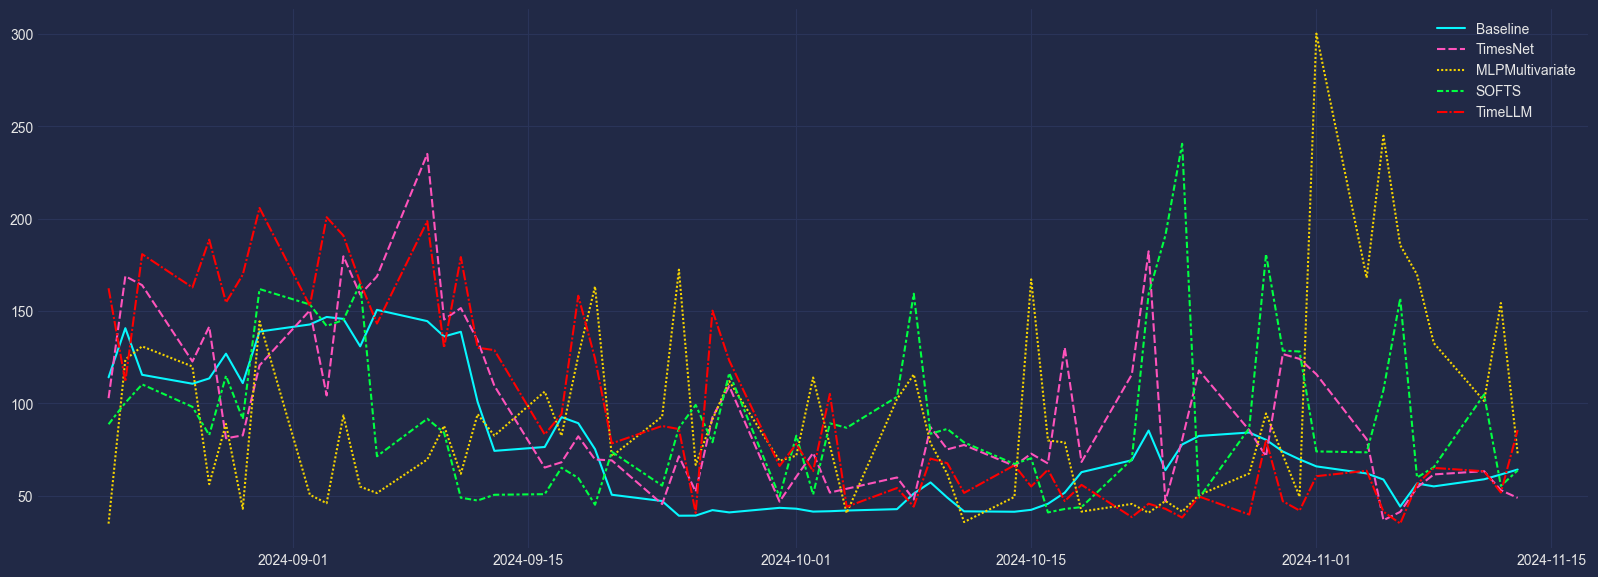

In [68]:
plt.figure(figsize=(20, 7))
sns.lineplot(metrics_df)
plt.show()

In [110]:
metrics = get_metrics(
    df_test["y"],
    predicted_df["TimesNet"].iloc[:n_steps].values,
    df_train["y"],
    "TimesNet",
)
metrics.set_index("model", inplace=True)

In [111]:
metrics_ = get_metrics(
    df_test["y"], predicted_df["TiDE"].iloc[:n_steps].values, df_train["y"], "TiDE"
)
metrics_.set_index("model", inplace=True)
metrics = pd.concat((metrics, metrics_))

In [112]:
metrics_ = get_metrics(
    df_test["y"],
    predicted_df["TimeLLM"].iloc[:n_steps].values,
    df_train["y"],
    "TimeLLM",
)
metrics_.set_index("model", inplace=True)
metrics = pd.concat((metrics, metrics_))

In [113]:
metrics_ = get_metrics(
    df_test["y"],
    predicted_df["TimeGPT"].iloc[:n_steps].values,
    df_train["y"],
    "TimeGPT-1",
)
metrics_.set_index("model", inplace=True)
metrics = pd.concat((metrics, metrics_))
metrics

MAE           MSE        RMSE         R²      MAPE  \
model                                                                  
TimesNet    39.673641   2750.373319   52.444002   0.226935  1.468949   
TiDE        65.675667   5492.907171   74.114150  -0.543926  2.482167   
TimeLLM     69.556087   5933.628558   77.030050  -0.667802  2.621135   
TimeGPT-1  183.921481  53577.520453  231.468185 -14.059368  6.799159   

              sMAPE       MASE  Mean residuals  
model                                           
TimesNet   1.480480   6.665267       16.927563  
TiDE       2.449725  11.033670      -48.333757  
TimeLLM    2.591964  11.685590      -42.722990  
TimeGPT-1  7.177801  30.899250      172.762312

# TimeGPT

In [69]:
nixtla_client = NixtlaClient(
    api_key="nixak-VOgcWljWgVvCdegiw6PZWYAMHIIpuOIgBlrMNBtWTy7bD8p4RZhK3CZFrBaeamOao0BAv9NRGiq7m94D"
)

In [72]:
nixtla_client.usage()["month"]

{'usage': 8, 'limit': 50}

In [71]:
exog_cols

['DX-Y.NYB',
 'WTI',
 'IRX',
 'GDX',
 'EURUSD',
 'VIX',
 'GSPC',
 'CPI',
 'TNX',
 'DJI',
 'SI']

In [73]:
index = []
errors = []
for i, h in enumerate(tqdm(range(-n_steps * 2, -n_steps + 1))):
    print(nixtla_client.usage()["month"])
    Y_ts = df[["ds", "unique_id", "y"]].copy()
    df_train = df.iloc[:h]
    Y_train = Y_ts.iloc[:h]
    if h + n_steps == 0:
        Y_test = Y_ts.iloc[h:]
    else:
        Y_test = Y_ts.iloc[h : h + n_steps]
    fcst_df = nixtla_client.forecast(
        df_train,
        h=n_steps,
        level=[LEVEL],
        hist_exog_list=exog_cols,
        finetune_steps=500,
        finetune_depth=5,
        finetune_loss="default",
        model="timegpt-1-long-horizon",
    )
    index.append(Y_train.ds[-1])
    mae = mean_absolute_error(Y_test["y"].values, fcst_df["TimeGPT"])
    errors.append(mae)
    print(errors)


  0%|                                                                                           | 0/61 [00:00<?, ?it/s]INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...


{'usage': 8, 'limit': 50}


INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...

  2%|█▎                                                                                 | 1/61 [00:43<43:26, 43.44s/it]

[177.96127374023442]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 9, 'limit': 50}



  3%|██▋                                                                                | 2/61 [01:30<44:33, 45.31s/it]

[177.96127374023442, 62.23821943684896]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 10, 'limit': 50}



  5%|████                                                                               | 3/61 [02:16<44:08, 45.66s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 11, 'limit': 50}



  7%|█████▍                                                                             | 4/61 [02:48<38:29, 40.51s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 12, 'limit': 50}


ERROR:nixtla.nixtla_client:Attempt 1 failed with error: Server disconnected without sending a response.

  8%|██████▊                                                                            | 5/61 [03:37<40:29, 43.38s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 2, 'limit': 50}



 10%|████████▏                                                                          | 6/61 [04:25<41:22, 45.14s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 3, 'limit': 50}



 11%|█████████▌                                                                         | 7/61 [05:08<39:52, 44.30s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 4, 'limit': 50}


ERROR:nixtla.nixtla_client:Attempt 1 failed with error: The read operation timed out

 13%|██████████▉                                                                        | 8/61 [07:03<59:01, 66.82s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 5, 'limit': 50}



 15%|████████████▏                                                                      | 9/61 [07:28<46:33, 53.73s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 7, 'limit': 50}



 16%|█████████████▍                                                                    | 10/61 [08:10<42:42, 50.25s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 8, 'limit': 50}



 18%|██████████████▊                                                                   | 11/61 [08:36<35:35, 42.71s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 9, 'limit': 50}



 20%|████████████████▏                                                                 | 12/61 [09:17<34:35, 42.35s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 10, 'limit': 50}



 21%|█████████████████▍                                                                | 13/61 [09:59<33:44, 42.17s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 11, 'limit': 50}



 23%|██████████████████▊                                                               | 14/61 [10:26<29:28, 37.63s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 12, 'limit': 50}



 25%|████████████████████▏                                                             | 15/61 [10:52<26:02, 33.98s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 13, 'limit': 50}



 26%|█████████████████████▌                                                            | 16/61 [11:33<27:09, 36.21s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 14, 'limit': 50}



 28%|██████████████████████▊                                                           | 17/61 [11:59<24:16, 33.11s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 15, 'limit': 50}



 30%|████████████████████████▏                                                         | 18/61 [12:41<25:31, 35.61s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 16, 'limit': 50}



 31%|█████████████████████████▌                                                        | 19/61 [13:23<26:19, 37.60s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 17, 'limit': 50}



 33%|██████████████████████████▉                                                       | 20/61 [14:04<26:27, 38.72s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 18, 'limit': 50}



 34%|████████████████████████████▏                                                     | 21/61 [14:46<26:32, 39.81s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 19, 'limit': 50}



 36%|█████████████████████████████▌                                                    | 22/61 [15:28<26:15, 40.39s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 20, 'limit': 50}



 38%|██████████████████████████████▉                                                   | 23/61 [16:15<26:52, 42.43s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417, 243.05764856770833]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 21, 'limit': 50}



 39%|████████████████████████████████▎                                                 | 24/61 [16:57<25:59, 42.14s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417, 243.05764856770833, 284.71316352864585]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 22, 'limit': 50}


ERROR:nixtla.nixtla_client:Attempt 1 failed with error: The read operation timed out

 41%|█████████████████████████████████▌                                                | 25/61 [18:35<35:21, 58.92s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417, 243.05764856770833, 284.71316352864585, 289.97899934244793]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 23, 'limit': 50}



 43%|██████████████████████████████████▉                                               | 26/61 [19:17<31:20, 53.72s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417, 243.05764856770833, 284.71316352864585, 289.97899934244793, 298.60218515625]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 25, 'limit': 50}



 44%|████████████████████████████████████▎                                             | 27/61 [20:03<29:09, 51.45s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417, 243.05764856770833, 284.71316352864585, 289.97899934244793, 298.60218515625, 332.4033843033855]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 26, 'limit': 50}



 46%|█████████████████████████████████████▋                                            | 28/61 [20:45<26:43, 48.60s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417, 243.05764856770833, 284.71316352864585, 289.97899934244793, 298.60218515625, 332.4033843033855, 334.47987426432303]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 27, 'limit': 50}



 48%|██████████████████████████████████████▉                                           | 29/61 [21:31<25:33, 47.92s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417, 243.05764856770833, 284.71316352864585, 289.97899934244793, 298.60218515625, 332.4033843033855, 334.47987426432303, 309.87579337239583]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 28, 'limit': 50}



 49%|████████████████████████████████████████▎                                         | 30/61 [22:13<23:47, 46.04s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417, 243.05764856770833, 284.71316352864585, 289.97899934244793, 298.60218515625, 332.4033843033855, 334.47987426432303, 309.87579337239583, 307.1476575585937]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 29, 'limit': 50}



 51%|█████████████████████████████████████████▋                                        | 31/61 [23:01<23:22, 46.76s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417, 243.05764856770833, 284.71316352864585, 289.97899934244793, 298.60218515625, 332.4033843033855, 334.47987426432303, 309.87579337239583, 307.1476575585937, 254.4007104459636]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 30, 'limit': 50}



 52%|███████████████████████████████████████████                                       | 32/61 [23:47<22:30, 46.58s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417, 243.05764856770833, 284.71316352864585, 289.97899934244793, 298.60218515625, 332.4033843033855, 334.47987426432303, 309.87579337239583, 307.1476575585937, 254.4007104459636, 226.8720379654948]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 31, 'limit': 50}



 54%|████████████████████████████████████████████▎                                     | 33/61 [24:36<22:01, 47.18s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417, 243.05764856770833, 284.71316352864585, 289.97899934244793, 298.60218515625, 332.4033843033855, 334.47987426432303, 309.87579337239583, 307.1476575585937, 254.4007104459636, 226.8720379654948, 146.8435481217448]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 32, 'limit': 50}



 56%|█████████████████████████████████████████████▋                                    | 34/61 [25:18<20:30, 45.58s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417, 243.05764856770833, 284.71316352864585, 289.97899934244793, 298.60218515625, 332.4033843033855, 334.47987426432303, 309.87579337239583, 307.1476575585937, 254.4007104459636, 226.8720379654948, 146.8435481217448, 68.58116738606772]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 33, 'limit': 50}



 57%|███████████████████████████████████████████████                                   | 35/61 [25:43<17:09, 39.60s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417, 243.05764856770833, 284.71316352864585, 289.97899934244793, 298.60218515625, 332.4033843033855, 334.47987426432303, 309.87579337239583, 307.1476575585937, 254.4007104459636, 226.8720379654948, 146.8435481217448, 68.58116738606772, 40.77400703450523]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 34, 'limit': 50}



 59%|████████████████████████████████████████████████▍                                 | 36/61 [26:09<14:43, 35.32s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417, 243.05764856770833, 284.71316352864585, 289.97899934244793, 298.60218515625, 332.4033843033855, 334.47987426432303, 309.87579337239583, 307.1476575585937, 254.4007104459636, 226.8720379654948, 146.8435481217448, 68.58116738606772, 40.77400703450523, 39.79761333333329]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 35, 'limit': 50}



 61%|█████████████████████████████████████████████████▋                                | 37/61 [26:50<14:52, 37.20s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417, 243.05764856770833, 284.71316352864585, 289.97899934244793, 298.60218515625, 332.4033843033855, 334.47987426432303, 309.87579337239583, 307.1476575585937, 254.4007104459636, 226.8720379654948, 146.8435481217448, 68.58116738606772, 40.77400703450523, 39.79761333333329, 45.04411992187501]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 36, 'limit': 50}



 62%|███████████████████████████████████████████████████                               | 38/61 [27:15<12:51, 33.56s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417, 243.05764856770833, 284.71316352864585, 289.97899934244793, 298.60218515625, 332.4033843033855, 334.47987426432303, 309.87579337239583, 307.1476575585937, 254.4007104459636, 226.8720379654948, 146.8435481217448, 68.58116738606772, 40.77400703450523, 39.79761333333329, 45.04411992187501, 57.13134085286459]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 37, 'limit': 50}


ERROR:nixtla.nixtla_client:Attempt 1 failed with error: The read operation timed out

 64%|████████████████████████████████████████████████████▍                             | 39/61 [29:10<21:12, 57.86s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417, 243.05764856770833, 284.71316352864585, 289.97899934244793, 298.60218515625, 332.4033843033855, 334.47987426432303, 309.87579337239583, 307.1476575585937, 254.4007104459636, 226.8720379654948, 146.8435481217448, 68.58116738606772, 40.77400703450523, 39.79761333333329, 45.04411992187501, 57.13134085286459, 49.601106861979154]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 38, 'limit': 50}


ERROR:nixtla.nixtla_client:Attempt 1 failed with error: status_code: 502, body: Could not parse JSON: b'Missing request, possibly due to expiry or cancellation'
ERROR:nixtla.nixtla_client:Attempt 2 failed with error: The read operation timed out

 66%|█████████████████████████████████████████████████████▊                            | 40/61 [31:32<29:03, 83.02s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417, 243.05764856770833, 284.71316352864585, 289.97899934244793, 298.60218515625, 332.4033843033855, 334.47987426432303, 309.87579337239583, 307.1476575585937, 254.4007104459636, 226.8720379654948, 146.8435481217448, 68.58116738606772, 40.77400703450523, 39.79761333333329, 45.04411992187501, 57.13134085286459, 49.601106861979154, 87.20383751953126]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 40, 'limit': 50}



 67%|███████████████████████████████████████████████████████                           | 41/61 [32:19<24:08, 72.40s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417, 243.05764856770833, 284.71316352864585, 289.97899934244793, 298.60218515625, 332.4033843033855, 334.47987426432303, 309.87579337239583, 307.1476575585937, 254.4007104459636, 226.8720379654948, 146.8435481217448, 68.58116738606772, 40.77400703450523, 39.79761333333329, 45.04411992187501, 57.13134085286459, 49.601106861979154, 87.20383751953126, 146.19187581380206]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 42, 'limit': 50}



 69%|████████████████████████████████████████████████████████▍                         | 42/61 [33:07<20:33, 64.93s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417, 243.05764856770833, 284.71316352864585, 289.97899934244793, 298.60218515625, 332.4033843033855, 334.47987426432303, 309.87579337239583, 307.1476575585937, 254.4007104459636, 226.8720379654948, 146.8435481217448, 68.58116738606772, 40.77400703450523, 39.79761333333329, 45.04411992187501, 57.13134085286459, 49.601106861979154, 87.20383751953126, 146.19187581380206, 217.34346178385414]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 43, 'limit': 50}


ERROR:nixtla.nixtla_client:Attempt 1 failed with error: status_code: 502, body: Could not parse JSON: b'Missing request, possibly due to expiry or cancellation'
ERROR:nixtla.nixtla_client:Attempt 2 failed with error: The read operation timed out
ERROR:nixtla.nixtla_client:Attempt 3 failed with error: The read operation timed out

 70%|█████████████████████████████████████████████████████████                        | 43/61 [37:02<34:46, 115.91s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417, 243.05764856770833, 284.71316352864585, 289.97899934244793, 298.60218515625, 332.4033843033855, 334.47987426432303, 309.87579337239583, 307.1476575585937, 254.4007104459636, 226.8720379654948, 146.8435481217448, 68.58116738606772, 40.77400703450523, 39.79761333333329, 45.04411992187501, 57.13134085286459, 49.601106861979154, 87.20383751953126, 146.19187581380206, 217.34346178385414, 354.78848724609367]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 45, 'limit': 50}



 72%|███████████████████████████████████████████████████████████▏                      | 44/61 [37:28<25:11, 88.93s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417, 243.05764856770833, 284.71316352864585, 289.97899934244793, 298.60218515625, 332.4033843033855, 334.47987426432303, 309.87579337239583, 307.1476575585937, 254.4007104459636, 226.8720379654948, 146.8435481217448, 68.58116738606772, 40.77400703450523, 39.79761333333329, 45.04411992187501, 57.13134085286459, 49.601106861979154, 87.20383751953126, 146.19187581380206, 217.34346178385414, 354.78848724609367, 422.0099856184896]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 47, 'limit': 50}


ERROR:nixtla.nixtla_client:Attempt 1 failed with error: The read operation timed out

 74%|████████████████████████████████████████████████████████████▍                     | 45/61 [39:06<24:28, 91.79s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417, 243.05764856770833, 284.71316352864585, 289.97899934244793, 298.60218515625, 332.4033843033855, 334.47987426432303, 309.87579337239583, 307.1476575585937, 254.4007104459636, 226.8720379654948, 146.8435481217448, 68.58116738606772, 40.77400703450523, 39.79761333333329, 45.04411992187501, 57.13134085286459, 49.601106861979154, 87.20383751953126, 146.19187581380206, 217.34346178385414, 354.78848724609367, 422.0099856184896, 386.8994964713541]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 48, 'limit': 50}



 75%|█████████████████████████████████████████████████████████████▊                    | 46/61 [39:32<17:58, 71.92s/it]

[177.96127374023442, 62.23821943684896, 190.6361887011719, 221.5450428873698, 157.96694792643228, 51.80174432617185, 92.11932471028646, 49.52329165039065, 56.585047558593764, 102.80825484375, 97.37186825520831, 138.1777291080729, 174.70474410807293, 168.46579996093752, 99.77041829427081, 74.82619748046878, 78.24365174479165, 112.68457620442706, 131.47620255859377, 146.32092341145838, 152.73721011718746, 219.8742019010417, 243.05764856770833, 284.71316352864585, 289.97899934244793, 298.60218515625, 332.4033843033855, 334.47987426432303, 309.87579337239583, 307.1476575585937, 254.4007104459636, 226.8720379654948, 146.8435481217448, 68.58116738606772, 40.77400703450523, 39.79761333333329, 45.04411992187501, 57.13134085286459, 49.601106861979154, 87.20383751953126, 146.19187581380206, 217.34346178385414, 354.78848724609367, 422.0099856184896, 386.8994964713541, 285.4873815885416]


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: B
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using historical exogenous features: ['DX-Y.NYB', 'WTI', 'IRX', 'GDX', 'EURUSD', 'VIX', 'GSPC', 'CPI', 'TNX', 'DJI', 'SI']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


{'usage': 50, 'limit': 50}


ERROR:nixtla.nixtla_client:Attempt 1 failed with error: Server disconnected without sending a response.
ERROR:nixtla.nixtla_client:Attempt 2 failed with error: Server disconnected without sending a response.
ERROR:nixtla.nixtla_client:Attempt 3 failed with error: Server disconnected without sending a response.
ERROR:nixtla.nixtla_client:Attempt 4 failed with error: Server disconnected without sending a response.
ERROR:nixtla.nixtla_client:Attempt 5 failed with error: Server disconnected without sending a response.
ERROR:nixtla.nixtla_client:Attempt 6 failed with error: Server disconnected without sending a response.
 75%|█████████████████████████████████████████████████████████████▊                    | 46/61 [40:29<13:12, 52.81s/it]


RemoteProtocolError: Server disconnected without sending a response.

In [75]:
errors

[177.96127374023442,
 62.23821943684896,
 190.6361887011719,
 221.5450428873698,
 157.96694792643228,
 51.80174432617185,
 92.11932471028646,
 49.52329165039065,
 56.585047558593764,
 102.80825484375,
 97.37186825520831,
 138.1777291080729,
 174.70474410807293,
 168.46579996093752,
 99.77041829427081,
 74.82619748046878,
 78.24365174479165,
 112.68457620442706,
 131.47620255859377,
 146.32092341145838,
 152.73721011718746,
 219.8742019010417,
 243.05764856770833,
 284.71316352864585,
 289.97899934244793,
 298.60218515625,
 332.4033843033855,
 334.47987426432303,
 309.87579337239583,
 307.1476575585937,
 254.4007104459636,
 226.8720379654948,
 146.8435481217448,
 68.58116738606772,
 40.77400703450523,
 39.79761333333329,
 45.04411992187501,
 57.13134085286459,
 49.601106861979154,
 87.20383751953126,
 146.19187581380206,
 217.34346178385414,
 354.78848724609367,
 422.0099856184896,
 386.8994964713541,
 285.4873815885416]

In [115]:
def weighted_median_row(row, weights):
    """
    Вычисление взвешенной медианы для одной строки.
    """
    values = row.values
    sorted_indices = np.argsort(values)
    sorted_values = values[sorted_indices]
    sorted_weights = np.array(weights)[sorted_indices]

    cumulative_weights = np.cumsum(sorted_weights)
    total_weight = cumulative_weights[-1]
    median_index = np.searchsorted(cumulative_weights, total_weight / 2)
    return sorted_values[median_index]

In [116]:
get_metrics(
    df_test["y"],
    predicted_df[["TimesNet", "TiDE", "TimeGPT", "TimeLLM"]]
    .apply(weighted_median_row, weights=weights, axis=1)
    .values,
    df_train["y"],
    "Median",
)

model        MAE          MSE       RMSE        R²      MAPE    sMAPE  \
0  Median  39.673641  2750.373319  52.444002  0.226935  1.468949  1.48048   

       MASE  Mean residuals  
0  6.665267       16.927563

In [117]:
models = ["TimesNet", "TiDE", "TimeGPT", "TimeLLM"]

In [118]:
pred_df = predicted_df[models].copy()

In [119]:
pred_df["Weighted_Median"] = pred_df.apply(weighted_median_row, weights=weights, axis=1)

In [120]:
pred_df["ds"] = predicted_df.ds
pred_df["unique_id"] = predicted_df.unique_id

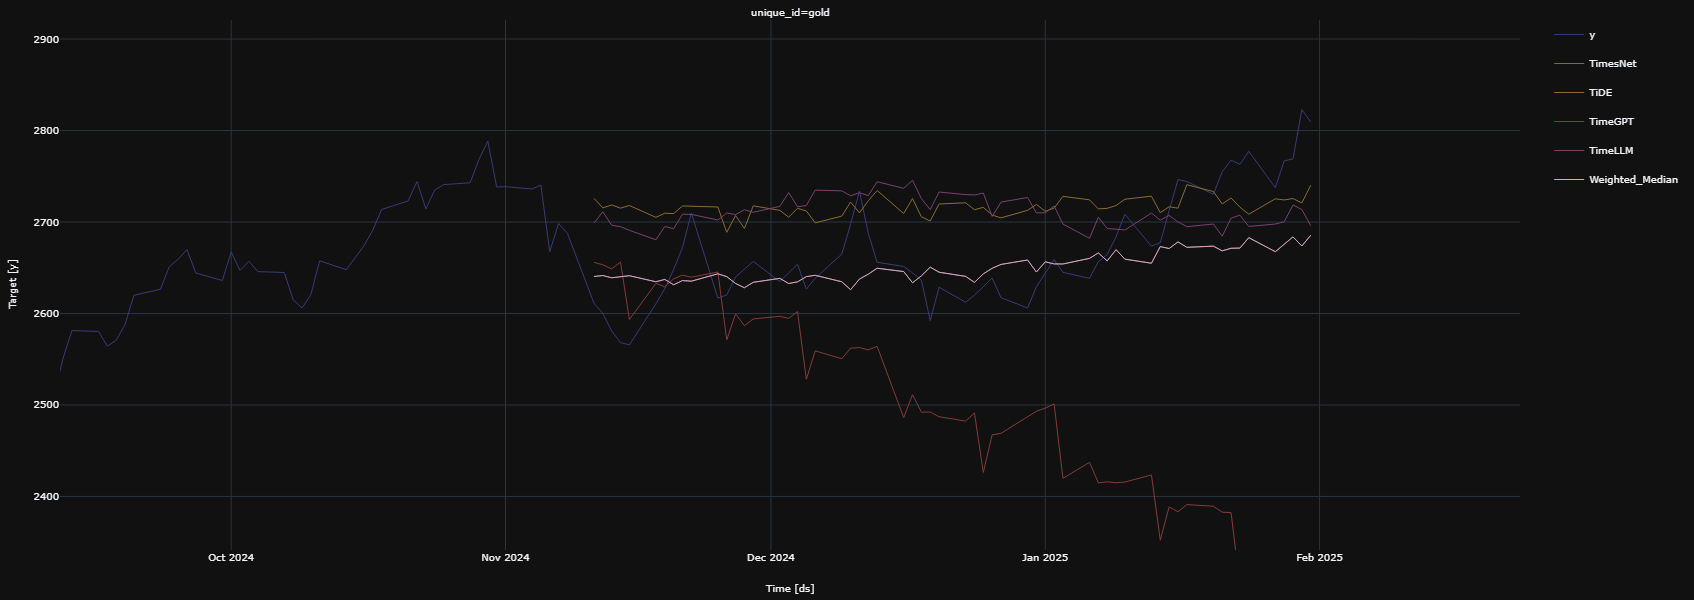

In [121]:
fig = StatsForecast.plot(
    Y_ts, pred_df, max_insample_length=n_steps * 2, engine="plotly"
)
fig.update_layout(width=1400, height=600, template="plotly_dark")
fig.show()

In [122]:
def uncertainty_row(row):
    """
    Вычисление неопределенности для одной строки.
    """
    values = row[:-3].values  # Пропускаем колонку Weighted_Median
    weighted_median = row["Weighted_Median"]
    mad = np.mean(
        np.abs(values - weighted_median)
    )  # Среднее абсолютное отклонение (MAD)
    std = np.std(values)  # Стандартное отклонение
    value_range = np.max(values) - np.min(values)  # Размах
    return pd.Series({"MAD": mad, "STD": std, "Range": value_range})

In [123]:
uncertainty_metrics = pred_df.apply(uncertainty_row, axis=1)

In [124]:
pred_df = pd.concat([pred_df, uncertainty_metrics], axis=1)

In [125]:
pred_df

TimesNet         TiDE    TimeGPT      TimeLLM  Weighted_Median  \
Date                                                                            
2024-11-11  2640.417725  2725.893066  2655.8848  2698.923828      2640.417725   
2024-11-12  2641.496338  2715.488037  2653.2460  2711.227295      2641.496338   
2024-11-13  2639.044434  2718.629150  2648.7603  2696.461426      2639.044434   
2024-11-14  2640.496338  2715.191162  2656.2373  2694.924561      2640.496338   
2024-11-15  2641.306641  2718.060059  2593.4526  2690.961426      2641.306641   
2024-11-18  2634.673584  2705.116211  2632.9540  2680.554443      2634.673584   
2024-11-19  2637.262695  2709.608154  2629.2786  2695.141602      2637.262695   
2024-11-20  2631.423584  2709.228027  2637.8538  2692.745850      2631.423584   
2024-11-21  2636.007080  2717.550049  2641.9011  2708.549805      2636.007080   
2024-11-22  2635.329102  2717.144043  2639.6628  2708.382812      2635.329102   
2024-11-25  2643.352783  2716.421143  2645.3616  2702.209961      2643.352783   
2024-11-26  2640.356201  2688.713135  2571.1445  2709.871338      2640.356201   
2024-11-27  2632.800049  2707.088135  2599.5723  2708.115967      2632.800049   
2024-11-28  2628.163818  2692.931152  2586.7260  2713.429443      2628.163818   
2024-11-29  2634.105957  2717.704102  2594.0980  2710.628174      2634.105957   
2024-12-02  2638.423828  2712.735107  2596.9330  2717.076904      2638.423828   
2024-12-03  2632.791260  2705.356201  2594.6716  2732.235352      2632.791260   
2024-12-04  2634.595947  2714.968018  2602.1494  2716.693604      2634.595947   
2024-12-05  2640.297607  2712.100098  2528.0586  2718.046143      2640.297607   
2024-12-06  2641.745605  2699.093018  2559.1826  2734.896729      2641.745605   
2024-12-09  2634.716064  2706.449219  2550.5044  2734.067627      2634.716064   
2024-12-10  2626.002686  2721.869141  2562.0273  2728.684570      2626.002686   
2024-12-11  2637.638672  2709.944092  2562.7498  2731.999023      2637.638672   
2024-12-12  2642.969727  2723.172119  2560.2522  2728.917480      2642.969727   
2024-12-13  2649.492188  2734.474121  2564.1418  2744.073486      2649.492188   
2024-12-16  2645.855957  2709.286133  2486.1490  2736.816650      2645.855957   
2024-12-17  2633.604736  2725.708008  2511.3044  2745.609375      2633.604736   
2024-12-18  2641.147217  2705.653076  2492.0896  2725.637207      2641.147217   
2024-12-19  2650.661621  2701.180176  2492.2786  2713.495850      2650.661621   
2024-12-20  2645.137939  2719.712158  2487.1704  2732.794189      2645.137939   
2024-12-23  2640.580566  2720.998047  2482.4040  2729.960449      2640.580566   
2024-12-24  2634.026123  2713.451172  2491.1504  2729.556396      2634.026123   
2024-12-25  2643.332764  2716.040039  2426.2324  2731.681396      2643.332764   
2024-12-26  2649.440186  2707.558105  2467.3910  2705.969971      2649.440186   
2024-12-27  2653.637939  2704.509033  2469.0150  2721.770020      2653.637939   
2024-12-30  2658.462646  2712.769043  2487.1833  2726.811768      2658.462646   
2024-12-31  2645.325928  2719.227051  2493.1187  2709.962158      2645.325928   
2025-01-01  2656.492920  2711.707031  2496.5718  2710.091797      2656.492920   
2025-01-02  2654.183350  2715.209229  2501.1980  2717.567627      2654.183350   
2025-01-03  2654.129395  2728.075195  2419.7722  2697.749023      2654.129395   
2025-01-06  2660.253662  2724.264160  2437.3032  2682.213135      2660.253662   
2025-01-07  2666.229736  2714.299072  2414.8472  2705.245361      2666.229736   
2025-01-08  2657.524170  2714.969238  2416.0183  2692.939697      2657.524170   
2025-01-09  2669.759521  2718.029053  2415.0027  2691.715332      2669.759521   
2025-01-10  2659.384033  2724.917236  2415.7622  2691.309326      2659.384033   
2025-01-13  2654.961426  2728.221191  2423.5278  2709.785889      2654.961426   
2025-01-14  2673.174316  2710.247070  2352.1323  2702.061768      2673.174316   
2025-01-15  2671.009521  2716.678223  2388.550

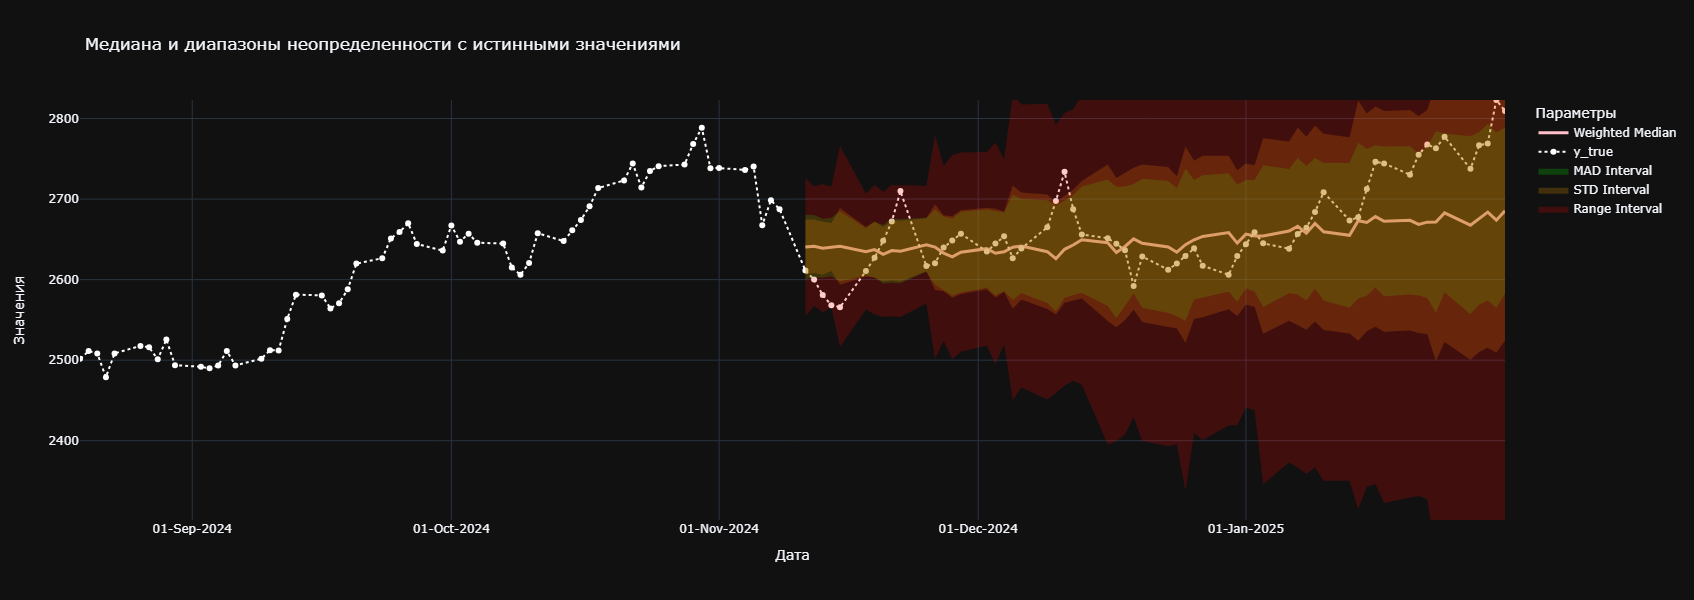

In [126]:
fig = go.Figure()

# Добавление медианы
fig.add_trace(
    go.Scatter(
        x=pred_df.index,
        y=pred_df["Weighted_Median"],
        mode="lines",
        name="Weighted Median",
        line=dict(color="pink", width=3),
    )
)

# Добавление истинных значений
fig.add_trace(
    go.Scatter(
        x=df.index,
        y=df["y"],
        mode="lines+markers",
        name="y_true",
        line=dict(color="white", width=2, dash="dot"),
        marker=dict(size=6),
    )
)

# Добавление диапазонов неопределенности
# MAD
fig.add_trace(
    go.Scatter(
        x=pred_df.index.tolist() + pred_df.index[::-1].tolist(),
        y=(pred_df["Weighted_Median"] + pred_df["MAD"]).tolist()
        + (pred_df["Weighted_Median"] - pred_df["MAD"]).iloc[::-1].tolist(),
        fill="toself",
        fillcolor="rgba(0, 255, 0, 0.2)",
        line=dict(color="rgba(255,255,255,0)"),
        name="MAD Interval",
    )
)

# STD
fig.add_trace(
    go.Scatter(
        x=pred_df.index.tolist() + pred_df.index[::-1].tolist(),
        y=(pred_df["Weighted_Median"] + pred_df["STD"]).tolist()
        + (pred_df["Weighted_Median"] - pred_df["STD"]).iloc[::-1].tolist(),
        fill="toself",
        fillcolor="rgba(255, 165, 0, 0.2)",
        line=dict(color="rgba(255,255,255,0)"),
        name="STD Interval",
    )
)

# Range
fig.add_trace(
    go.Scatter(
        x=pred_df.index.tolist() + pred_df.index[::-1].tolist(),
        y=(pred_df["Weighted_Median"] + pred_df["Range"]).tolist()
        + (pred_df["Weighted_Median"] - pred_df["Range"]).iloc[::-1].tolist(),
        fill="toself",
        fillcolor="rgba(255, 0, 0, 0.2)",
        line=dict(color="rgba(255,255,255,0)"),
        name="Range Interval",
    )
)

# Настройка графика
fig.update_layout(
    title="Медиана и диапазоны неопределенности с истинными значениями",
    xaxis_title="Дата",
    yaxis_title="Значения",
    legend_title="Параметры",
    template="plotly_dark",
    xaxis=dict(
        tickformat="%d-%b-%Y", type="date", range=[df.index[-n_steps * 2], df.index[-1]]
    ),
    yaxis=dict(
        range=[
            min(min(pred_df[models].min()), df.iloc[-n_steps * 2 :].y.min()),
            max(max(pred_df[models].max()), df.iloc[-n_steps * 2 :].y.max()),
        ]
    ),
    width=1400,
    height=600,
)

# Показ графика
fig.show()

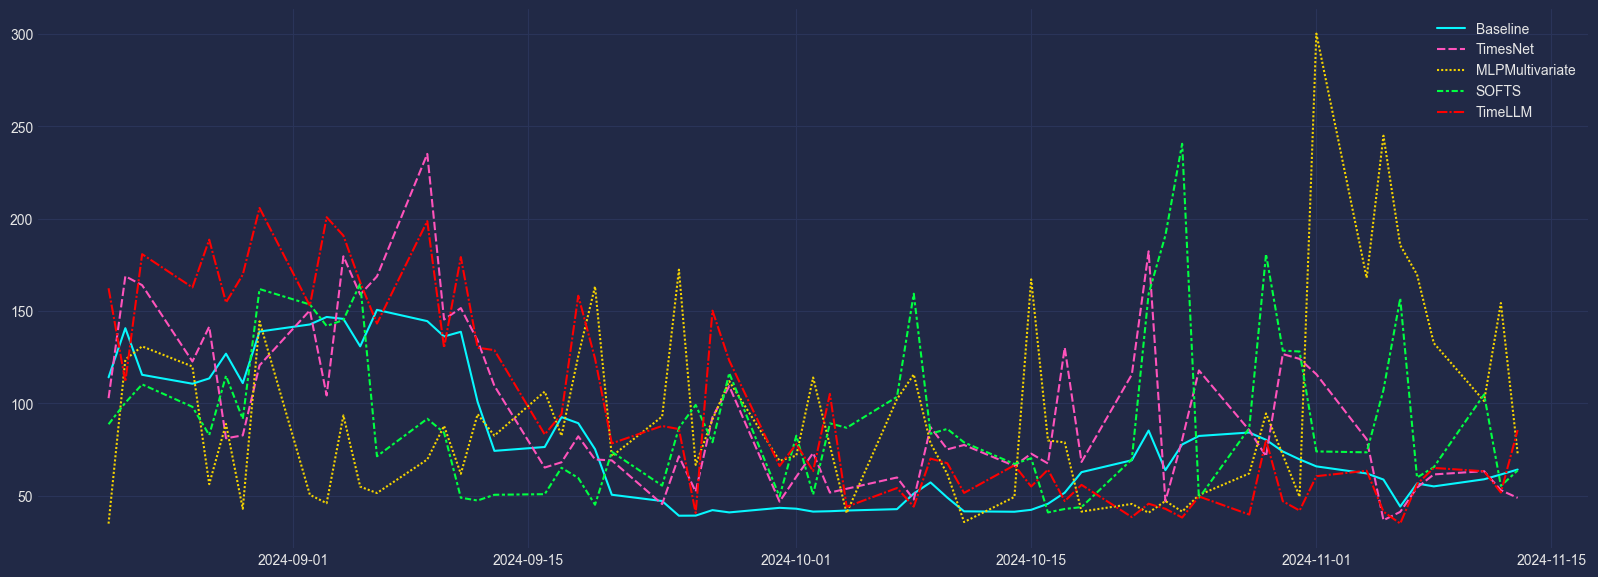

In [68]:
plt.figure(figsize=(20, 7))
sns.lineplot(metrics_df)
plt.show()

# Conclusion

As we can see, none of the models turned out to be better than baseline in the studied period, which indicates the absence of a pattern in the price of gold.